# 1. Data Pre-processing

In [1]:
# load packages
import os

import matplotlib.pyplot as plt  # For plotting
import numpy as np
import pandas as pd
import geopandas as gpd

# for converting the DataFrame to GeoDataFrame
from shapely.geometry import Point
# For plotting
import matplotlib.pyplot as plt

import seaborn as sns
from sklearn.cluster import KMeans

In [2]:
# home lsoa
df_homelsoa_raw = pd.read_csv(
    "raw_data/london-home-postcode-data.csv",
    low_memory=False,
)

# lsoa where the accident happen
df_reallsoa_raw = pd.read_csv(
    "raw_data/collision-location-data.csv",
    low_memory=False,
)

# deprivations
df_id_lsoa_raw = pd.read_excel("raw_data/ID 2019 for London.xlsx", sheet_name='IMD 2019')

# population density
df_pop_raw = pd.read_excel(
    "raw_data/SAPE22DT11-mid-2019-lsoa-population-density.xlsx", sheet_name='Mid-2019 Population Density', header=4)

# Road Length
df_roadlength_raw = pd.read_csv(
    "raw_data/lsoa-reference-data.csv",
    low_memory=False,
)

# for detailed casualties
df_extractcasualty_raw = pd.read_csv(
    "raw_data/2019-gla-data-extract-casualty.csv",
    low_memory=False,
)

# for more detailed casualties
df_extractattendant_raw = pd.read_csv(
    "raw_data/2019-gla-data-extract-attendant.csv",
    low_memory=False,
)

# read the basemap of London LSOAs
gdf_lsoa_raw = gpd.read_file(
    f"zip://raw_data/statistical-gis-boundaries-london.zip!statistical-gis-boundaries-london/ESRI/LSOA_2011_London_gen_MHW.shp")

In [3]:
# read the basemap of London LSOAs
gdf_lsoaarcgis_raw = gpd.read_file(
    f"zip://raw_data/Lower_Super_Output_Area_(LSOA)_IMD2019__(WGS84)-shp.zip!5878ebcf-f091-4bde-8864-aa547dd45afd2020330-1-8g4usn.8evuq.shp")

In [4]:
gdf_lsoaarcgis_raw.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 34753 entries, 0 to 34752
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   FID         34753 non-null  int64   
 1   lsoa11cd    34753 non-null  object  
 2   lsoa11nm    34753 non-null  object  
 3   IMDRank     34753 non-null  int64   
 4   IMDDecil    34753 non-null  int64   
 5   Shape__Are  34753 non-null  float64 
 6   Shape__Len  34753 non-null  float64 
 7   geometry    34753 non-null  geometry
dtypes: float64(2), geometry(1), int64(3), object(2)
memory usage: 2.1+ MB


In [5]:
df_lsoa_raw = gdf_lsoa_raw.drop(columns='geometry')

In [6]:
df_lsoa_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4835 entries, 0 to 4834
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   LSOA11CD   4835 non-null   object 
 1   LSOA11NM   4835 non-null   object 
 2   MSOA11CD   4835 non-null   object 
 3   MSOA11NM   4835 non-null   object 
 4   LAD11CD    4835 non-null   object 
 5   LAD11NM    4835 non-null   object 
 6   RGN11CD    4835 non-null   object 
 7   RGN11NM    4835 non-null   object 
 8   USUALRES   4835 non-null   int64  
 9   HHOLDRES   4835 non-null   int64  
 10  COMESTRES  4835 non-null   int64  
 11  POPDEN     4835 non-null   float64
 12  HHOLDS     4835 non-null   int64  
 13  AVHHOLDSZ  4835 non-null   float64
dtypes: float64(2), int64(4), object(8)
memory usage: 529.0+ KB


In [7]:
gdf_lsoa_raw = gdf_lsoaarcgis_raw.merge(df_lsoa_raw, left_on='lsoa11cd', right_on='LSOA11CD')

In [8]:
columns_to_drop = ['FID', 'lsoa11cd', 'lsoa11nm', 'IMDRank', 'IMDDecil', 'Shape__Are', 'Shape__Len']
gdf_lsoa_raw = gdf_lsoa_raw.drop(columns=columns_to_drop).copy()

In [9]:
gdf_lsoa_raw.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 4835 entries, 0 to 4834
Data columns (total 15 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   geometry   4835 non-null   geometry
 1   LSOA11CD   4835 non-null   object  
 2   LSOA11NM   4835 non-null   object  
 3   MSOA11CD   4835 non-null   object  
 4   MSOA11NM   4835 non-null   object  
 5   LAD11CD    4835 non-null   object  
 6   LAD11NM    4835 non-null   object  
 7   RGN11CD    4835 non-null   object  
 8   RGN11NM    4835 non-null   object  
 9   USUALRES   4835 non-null   int64   
 10  HHOLDRES   4835 non-null   int64   
 11  COMESTRES  4835 non-null   int64   
 12  POPDEN     4835 non-null   float64 
 13  HHOLDS     4835 non-null   int64   
 14  AVHHOLDSZ  4835 non-null   float64 
dtypes: float64(2), geometry(1), int64(4), object(8)
memory usage: 566.7+ KB


In [10]:
# filter data to get the dat of year 2019
df_homelsoa_2019_raw = df_homelsoa_raw[df_homelsoa_raw['Year'] == 2019]
df_reallsoa_2019_raw = df_reallsoa_raw[df_reallsoa_raw['Year'] == 2019]

In [11]:
# add the new 'Collision Location LSOA Code' column to df_homelsoa_2019_raw GeoDataFrame
df_lsoa_2019_raw = df_homelsoa_2019_raw.merge(df_reallsoa_2019_raw[['Casualty ID', 'Collision Location LSOA Code']],
                                  left_on='Casualty ID', right_on='Casualty ID', how='left')

In [12]:
df_lsoa_2019_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24189 entries, 0 to 24188
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Date                          24189 non-null  object 
 1   Year                          24189 non-null  int64  
 2   Casualty Home Borough         24189 non-null  object 
 3   Collision ID                  24189 non-null  int64  
 4   Vehicle ID                    24189 non-null  object 
 5   Casualty ID                   24189 non-null  object 
 6   Casualty Severity             24189 non-null  object 
 7   Casualty Mode of Travel       24189 non-null  object 
 8   Casualty Home LSOA Code       24189 non-null  object 
 9   Unnamed: 9                    0 non-null      float64
 10  Unnamed: 10                   0 non-null      float64
 11  Unnamed: 11                   0 non-null      float64
 12  Unnamed: 12                   0 non-null      float64
 13  U

In [13]:
df_lsoa_2019_raw = df_lsoa_2019_raw.loc[:, ~df_lsoa_2019_raw.columns.str.contains('^Unnamed')].copy()
df_lsoa_2019_raw.columns = df_lsoa_2019_raw.columns.str.replace(' ', '_').copy()

In [14]:
df_lsoa_2019_raw.info()
# df_lsoa_2019_raw.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24189 entries, 0 to 24188
Data columns (total 10 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   Date                          24189 non-null  object
 1   Year                          24189 non-null  int64 
 2   Casualty_Home_Borough         24189 non-null  object
 3   Collision_ID                  24189 non-null  int64 
 4   Vehicle_ID                    24189 non-null  object
 5   Casualty_ID                   24189 non-null  object
 6   Casualty_Severity             24189 non-null  object
 7   Casualty_Mode_of_Travel       24189 non-null  object
 8   Casualty_Home_LSOA_Code       24189 non-null  object
 9   Collision_Location_LSOA_Code  24143 non-null  object
dtypes: int64(2), object(8)
memory usage: 1.8+ MB


In [15]:
# df_lsoa_2019_raw.to_csv('df_lsoa_2019_raw.csv', index=False)

In [16]:
# # Fill rows without a value in the 'Collision_Location_LSOA_Code' column with the value
#in the 'Casualty_Home_LSOA_Code' column of the corresponding row
df_lsoa_2019_raw['Collision_Location_LSOA_Code'] = df_lsoa_2019_raw[
'Collision_Location_LSOA_Code'].fillna(df_lsoa_2019_raw['Casualty_Home_LSOA_Code'])

In [17]:
df_lsoa_2019_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24189 entries, 0 to 24188
Data columns (total 10 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   Date                          24189 non-null  object
 1   Year                          24189 non-null  int64 
 2   Casualty_Home_Borough         24189 non-null  object
 3   Collision_ID                  24189 non-null  int64 
 4   Vehicle_ID                    24189 non-null  object
 5   Casualty_ID                   24189 non-null  object
 6   Casualty_Severity             24189 non-null  object
 7   Casualty_Mode_of_Travel       24189 non-null  object
 8   Casualty_Home_LSOA_Code       24189 non-null  object
 9   Collision_Location_LSOA_Code  24189 non-null  object
dtypes: int64(2), object(8)
memory usage: 1.8+ MB


In [18]:
# df_lsoa_2019_raw.to_csv('df_lsoa_2019_raw1.csv', index=False)

In [19]:
df_lsoa_2019_raw['local'] = (
    df_lsoa_2019_raw['Casualty_Home_LSOA_Code'] == df_lsoa_2019_raw['Collision_Location_LSOA_Code']).astype(int)

In [20]:
df_lsoa_2019_raw.info()
# df_lsoa_2019_raw.to_csv('df_lsoa_2019_raw_local.csv', index=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24189 entries, 0 to 24188
Data columns (total 11 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   Date                          24189 non-null  object
 1   Year                          24189 non-null  int64 
 2   Casualty_Home_Borough         24189 non-null  object
 3   Collision_ID                  24189 non-null  int64 
 4   Vehicle_ID                    24189 non-null  object
 5   Casualty_ID                   24189 non-null  object
 6   Casualty_Severity             24189 non-null  object
 7   Casualty_Mode_of_Travel       24189 non-null  object
 8   Casualty_Home_LSOA_Code       24189 non-null  object
 9   Collision_Location_LSOA_Code  24189 non-null  object
 10  local                         24189 non-null  int64 
dtypes: int64(3), object(8)
memory usage: 2.0+ MB


In [21]:
# gdf_lsoa_raw.info()

In [22]:
# Drop columns that won't be used
columns_to_drop_lsoa_2019_raw = ['MSOA11CD', 'MSOA11NM', 'RGN11CD', 'RGN11NM', 'USUALRES', 'HHOLDRES', 'COMESTRES', 'POPDEN', 'HHOLDS', 'AVHHOLDSZ']
gdf_lsoa_2019_raw = gdf_lsoa_raw.drop(columns=columns_to_drop_lsoa_2019_raw)

In [23]:
gdf_lsoa_2019_raw.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 4835 entries, 0 to 4834
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   geometry  4835 non-null   geometry
 1   LSOA11CD  4835 non-null   object  
 2   LSOA11NM  4835 non-null   object  
 3   LAD11CD   4835 non-null   object  
 4   LAD11NM   4835 non-null   object  
dtypes: geometry(1), object(4)
memory usage: 189.0+ KB


In [24]:
df_pop_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34753 entries, 0 to 34752
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   LSOA Code            34753 non-null  object 
 1   LSOA Name            34753 non-null  object 
 2   Mid-2019 population  34753 non-null  int64  
 3   Area Sq Km           34753 non-null  float64
 4   People per Sq Km     34753 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 1.3+ MB


In [25]:
df_pop_raw.columns = df_pop_raw.columns.str.replace(' ', '_').copy()
df_pop_raw.columns = df_pop_raw.columns.str.replace('-', '_').copy()

In [26]:
df_pop_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34753 entries, 0 to 34752
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   LSOA_Code            34753 non-null  object 
 1   LSOA_Name            34753 non-null  object 
 2   Mid_2019_population  34753 non-null  int64  
 3   Area_Sq_Km           34753 non-null  float64
 4   People_per_Sq_Km     34753 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 1.3+ MB


In [27]:
# add the new 'Mid_2019_population' and 'People_per_Sq_Km' column to gdf_lsoa_2019_raw GeoDataFrame
gdf_lsoa_2019_with_popden_raw = gdf_lsoa_2019_raw.merge(df_pop_raw[['LSOA_Code', 'Mid_2019_population', 'People_per_Sq_Km']],
                                  left_on='LSOA11CD', right_on='LSOA_Code', how='left')

In [28]:
gdf_lsoa_2019_with_popden_raw = gdf_lsoa_2019_with_popden_raw.drop(columns=['LSOA_Code'])

In [29]:
gdf_lsoa_2019_with_popden_raw.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 4835 entries, 0 to 4834
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   geometry             4835 non-null   geometry
 1   LSOA11CD             4835 non-null   object  
 2   LSOA11NM             4835 non-null   object  
 3   LAD11CD              4835 non-null   object  
 4   LAD11NM              4835 non-null   object  
 5   Mid_2019_population  4835 non-null   int64   
 6   People_per_Sq_Km     4835 non-null   float64 
dtypes: float64(1), geometry(1), int64(1), object(4)
memory usage: 264.5+ KB


In [30]:
df_roadlength_raw.columns = df_roadlength_raw.columns.str.replace(' ', '_').copy()
df_roadlength_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9829 entries, 0 to 9828
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Census_Year  9829 non-null   int64  
 1   LSOA_Code    9829 non-null   object 
 2   Road_Length  9829 non-null   float64
 3   Population   9829 non-null   int64  
 4   IMD_Decile   9829 non-null   int64  
dtypes: float64(1), int64(3), object(1)
memory usage: 384.1+ KB


In [31]:
# Filter to get length data for each LSOA close to the year 2019
df_roadlength_2019_raw = df_roadlength_raw[df_roadlength_raw['Census_Year'] == 2014]

In [32]:
df_roadlength_2019_raw.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4835 entries, 0 to 4834
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Census_Year  4835 non-null   int64  
 1   LSOA_Code    4835 non-null   object 
 2   Road_Length  4835 non-null   float64
 3   Population   4835 non-null   int64  
 4   IMD_Decile   4835 non-null   int64  
dtypes: float64(1), int64(3), object(1)
memory usage: 226.6+ KB


In [33]:
# add the new 'Road_Length' column to gdf_lsoa_2019_with_p_a_r_raw GeoDataFrame
gdf_lsoa_2019_with_p_a_r_raw = gdf_lsoa_2019_with_popden_raw.merge(df_roadlength_2019_raw[['LSOA_Code', 'Road_Length']],
                                  left_on='LSOA11CD', right_on='LSOA_Code', how='left')
gdf_lsoa_2019_with_p_a_r_raw = gdf_lsoa_2019_with_p_a_r_raw.drop(columns=['LSOA_Code'])

In [34]:
gdf_lsoa_2019_with_p_a_r_raw.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 4835 entries, 0 to 4834
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   geometry             4835 non-null   geometry
 1   LSOA11CD             4835 non-null   object  
 2   LSOA11NM             4835 non-null   object  
 3   LAD11CD              4835 non-null   object  
 4   LAD11NM              4835 non-null   object  
 5   Mid_2019_population  4835 non-null   int64   
 6   People_per_Sq_Km     4835 non-null   float64 
 7   Road_Length          4835 non-null   float64 
dtypes: float64(2), geometry(1), int64(1), object(4)
memory usage: 302.3+ KB


In [35]:
df_id_lsoa_raw.columns = df_id_lsoa_raw.columns.str.replace(' ', '_').copy()
df_id_lsoa_raw.columns = df_id_lsoa_raw.columns.str.replace(',', '').copy()
df_id_lsoa_raw.columns = df_id_lsoa_raw.columns.str.replace('(', '').copy()
df_id_lsoa_raw.columns = df_id_lsoa_raw.columns.str.replace(')', '').copy()
df_id_lsoa_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4835 entries, 0 to 4834
Data columns (total 28 columns):
 #   Column                                                                          Non-Null Count  Dtype  
---  ------                                                                          --------------  -----  
 0   LSOA_code_2011                                                                  4835 non-null   object 
 1   LSOA_name_2011                                                                  4835 non-null   object 
 2   Local_Authority_District_code_2019                                              4835 non-null   object 
 3   Local_Authority_District_name_2019                                              4835 non-null   object 
 4   Index_of_Multiple_Deprivation_IMD_Score                                         4835 non-null   float64
 5   Index_of_Multiple_Deprivation_IMD_Rank_where_1_is_most_deprived                 4835 non-null   int64  
 6   Index_of_Multipl

In [36]:
columns_to_keep_id_lsoa_raw = ['LSOA_code_2011'] + [
    col
    for col in df_id_lsoa_raw.columns
    if 'Score' in col and 'Index_of_Multiple_Deprivation_IMD_Score' not in col
]
df_id_lsoa_2019_raw = df_id_lsoa_raw[columns_to_keep_id_lsoa_raw]

In [37]:
df_id_lsoa_2019_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4835 entries, 0 to 4834
Data columns (total 8 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   LSOA_code_2011                           4835 non-null   object 
 1   Income_Score_rate                        4835 non-null   float64
 2   Employment_Score_rate                    4835 non-null   float64
 3   Education_Skills_and_Training_Score      4835 non-null   float64
 4   Health_Deprivation_and_Disability_Score  4835 non-null   float64
 5   Crime_Score                              4835 non-null   float64
 6   Barriers_to_Housing_and_Services_Score   4835 non-null   float64
 7   Living_Environment_Score                 4835 non-null   float64
dtypes: float64(7), object(1)
memory usage: 302.3+ KB


In [38]:
# add the new columns to gdf_lsoa_2019_with_p_a_r_raw GeoDataFrame
gdf_lsoa_2019_with_p_r_a_id_raw = gdf_lsoa_2019_with_p_a_r_raw.merge(
    df_id_lsoa_2019_raw, left_on='LSOA11CD', right_on='LSOA_code_2011', how='left')
gdf_2019_raw = gdf_lsoa_2019_with_p_r_a_id_raw.drop(columns=['LSOA_code_2011']).copy()

In [39]:
gdf_2019_raw.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 4835 entries, 0 to 4834
Data columns (total 15 columns):
 #   Column                                   Non-Null Count  Dtype   
---  ------                                   --------------  -----   
 0   geometry                                 4835 non-null   geometry
 1   LSOA11CD                                 4835 non-null   object  
 2   LSOA11NM                                 4835 non-null   object  
 3   LAD11CD                                  4835 non-null   object  
 4   LAD11NM                                  4835 non-null   object  
 5   Mid_2019_population                      4835 non-null   int64   
 6   People_per_Sq_Km                         4835 non-null   float64 
 7   Road_Length                              4835 non-null   float64 
 8   Income_Score_rate                        4835 non-null   float64 
 9   Employment_Score_rate                    4835 non-null   float64 
 10  Education_Skills_and_Trainin

## 1.1 Traffic accident rates

In [40]:
df_lsoa_2019_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24189 entries, 0 to 24188
Data columns (total 11 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   Date                          24189 non-null  object
 1   Year                          24189 non-null  int64 
 2   Casualty_Home_Borough         24189 non-null  object
 3   Collision_ID                  24189 non-null  int64 
 4   Vehicle_ID                    24189 non-null  object
 5   Casualty_ID                   24189 non-null  object
 6   Casualty_Severity             24189 non-null  object
 7   Casualty_Mode_of_Travel       24189 non-null  object
 8   Casualty_Home_LSOA_Code       24189 non-null  object
 9   Collision_Location_LSOA_Code  24189 non-null  object
 10  local                         24189 non-null  int64 
dtypes: int64(3), object(8)
memory usage: 2.0+ MB


In [41]:
# Perform statistics on the Casualty_Home_LSOA_Code column
df_homelsoa_overall_raw = df_lsoa_2019_raw.groupby('Casualty_Home_LSOA_Code').size().reset_index(name='home_overall_number').copy()

In [42]:
df_homelsoa_overall_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4709 entries, 0 to 4708
Data columns (total 2 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Casualty_Home_LSOA_Code  4709 non-null   object
 1   home_overall_number      4709 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 73.7+ KB


In [43]:
# add the new column to gdf_2019_raw GeoDataFrame
gdf_home_overall_2019_raw = gdf_2019_raw.merge(
    df_homelsoa_overall_raw, left_on='LSOA11CD', right_on='Casualty_Home_LSOA_Code', how='left')
# Use the fillna method to fill NaN values ​​with 0
gdf_home_overall_2019_raw['home_overall_number'] = gdf_home_overall_2019_raw['home_overall_number'].fillna(0)
gdf_home_overall_2019_raw = gdf_home_overall_2019_raw.drop(columns=['Casualty_Home_LSOA_Code']).copy()

In [44]:
gdf_home_overall_2019_raw.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 4835 entries, 0 to 4834
Data columns (total 16 columns):
 #   Column                                   Non-Null Count  Dtype   
---  ------                                   --------------  -----   
 0   geometry                                 4835 non-null   geometry
 1   LSOA11CD                                 4835 non-null   object  
 2   LSOA11NM                                 4835 non-null   object  
 3   LAD11CD                                  4835 non-null   object  
 4   LAD11NM                                  4835 non-null   object  
 5   Mid_2019_population                      4835 non-null   int64   
 6   People_per_Sq_Km                         4835 non-null   float64 
 7   Road_Length                              4835 non-null   float64 
 8   Income_Score_rate                        4835 non-null   float64 
 9   Employment_Score_rate                    4835 non-null   float64 
 10  Education_Skills_and_Trainin

In [46]:
gdf_home_overall_2019_raw.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 4835 entries, 0 to 4834
Data columns (total 17 columns):
 #   Column                                   Non-Null Count  Dtype   
---  ------                                   --------------  -----   
 0   geometry                                 4835 non-null   geometry
 1   LSOA11CD                                 4835 non-null   object  
 2   LSOA11NM                                 4835 non-null   object  
 3   LAD11CD                                  4835 non-null   object  
 4   LAD11NM                                  4835 non-null   object  
 5   Mid_2019_population                      4835 non-null   int64   
 6   People_per_Sq_Km                         4835 non-null   float64 
 7   Road_Length                              4835 non-null   float64 
 8   Income_Score_rate                        4835 non-null   float64 
 9   Employment_Score_rate                    4835 non-null   float64 
 10  Education_Skills_and_Trainin

In [47]:
# gdf_home_overall_2019_raw.crs

In [48]:
# convert the coordinate system of gdf_home_overall_2019_raw to EPSG:27700
gdf_home_overall_2019_raw = gdf_home_overall_2019_raw.to_crs('EPSG:27700')

In [49]:
# gdf_home_overall_2019_raw.crs

In [50]:
gdf_home_overall_2019_den = gdf_home_overall_2019_raw.copy()

In [51]:
gdf_home_overall_2019_den.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 4835 entries, 0 to 4834
Data columns (total 17 columns):
 #   Column                                   Non-Null Count  Dtype   
---  ------                                   --------------  -----   
 0   geometry                                 4835 non-null   geometry
 1   LSOA11CD                                 4835 non-null   object  
 2   LSOA11NM                                 4835 non-null   object  
 3   LAD11CD                                  4835 non-null   object  
 4   LAD11NM                                  4835 non-null   object  
 5   Mid_2019_population                      4835 non-null   int64   
 6   People_per_Sq_Km                         4835 non-null   float64 
 7   Road_Length                              4835 non-null   float64 
 8   Income_Score_rate                        4835 non-null   float64 
 9   Employment_Score_rate                    4835 non-null   float64 
 10  Education_Skills_and_Trainin

In [52]:
# 首先计算每个单元的面积（以平方千米为单位） (因为默认面积单位是平方米，转换为平方千米)
gdf_home_overall_2019_den['area_sq_km'] = gdf_home_overall_2019_den['geometry'].area / 10**6

In [53]:
# 然后计算每平方千米的事故数量
gdf_home_overall_2019_den['overall_home_den_casrate'] = gdf_home_overall_2019_den['home_overall_number'] / gdf_home_overall_2019_den['area_sq_km']

In [54]:
# caculate the road length density
gdf_home_overall_2019_den['Road_Length'] = gdf_home_overall_2019_den['Road_Length'] / gdf_home_overall_2019_den['area_sq_km']

In [55]:
gdf_home_overall_2019_den.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 4835 entries, 0 to 4834
Data columns (total 19 columns):
 #   Column                                   Non-Null Count  Dtype   
---  ------                                   --------------  -----   
 0   geometry                                 4835 non-null   geometry
 1   LSOA11CD                                 4835 non-null   object  
 2   LSOA11NM                                 4835 non-null   object  
 3   LAD11CD                                  4835 non-null   object  
 4   LAD11NM                                  4835 non-null   object  
 5   Mid_2019_population                      4835 non-null   int64   
 6   People_per_Sq_Km                         4835 non-null   float64 
 7   Road_Length                              4835 non-null   float64 
 8   Income_Score_rate                        4835 non-null   float64 
 9   Employment_Score_rate                    4835 non-null   float64 
 10  Education_Skills_and_Trainin

# study area and data

In [56]:
import matplotlib.pyplot as plt
import geopandas as gpd
import matplotlib.lines as mlines
from matplotlib_scalebar.scalebar import ScaleBar
from matplotlib.patches import FancyArrow
from matplotlib.offsetbox import AnchoredOffsetbox, TextArea, VPacker

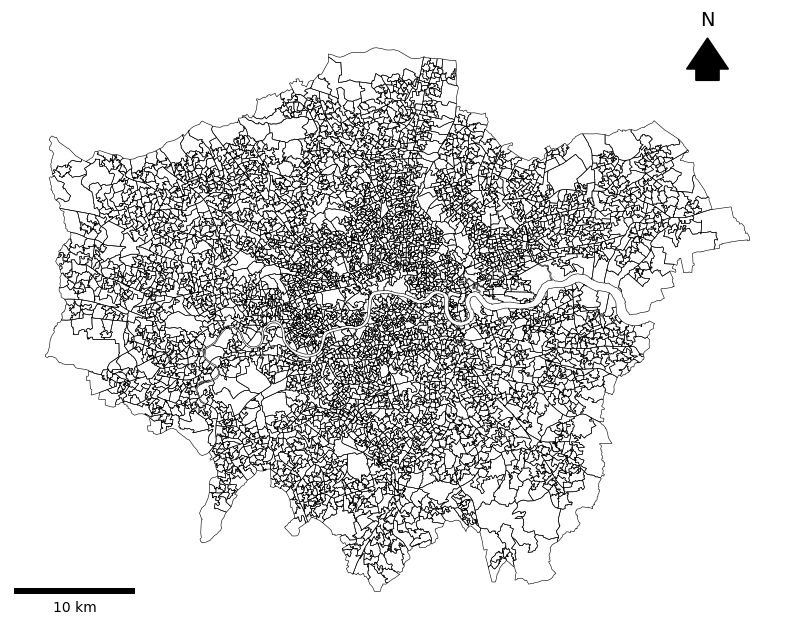

In [57]:
import matplotlib.pyplot as plt
import geopandas as gpd
from matplotlib.colors import LinearSegmentedColormap, Normalize
from matplotlib_scalebar.scalebar import ScaleBar
import matplotlib.lines as mlines
from matplotlib.patches import FancyArrow

def add_north_arrow(ax, xy=(0.9, 0.9), size=14, pad=0.1):
    """
    在给定的轴上添加指北针
    :param ax: Matplotlib 轴对象
    :param xy: 指北针的位置 (右上角)
    :param size: 箭头大小
    :param pad: 箭头和文本之间的间距
    """
    # 创建指北针箭头
    arrow = FancyArrow(x=xy[0], y=xy[1], dx=0, dy=0.019, width=0.03, color='black', transform=ax.transAxes, 
                       head_width=0.054, head_length=0.0519)
    ax.add_patch(arrow)

    # 创建"N"文本
    text = AnchoredOffsetbox(loc='center', child=TextArea("N", textprops=dict(size=size)),
                             pad=pad, frameon=False, bbox_to_anchor=(xy[0], xy[1] + 0.1), 
                             bbox_transform=ax.transAxes, borderpad=0)
    ax.add_artist(text)

# 创建一个图形对象
fig, ax = plt.subplots(figsize=(10, 9))

# 绘制地图
gdf_home_overall_2019_den.boundary.plot(ax=ax, edgecolor='black', linewidth=0.419)

# 添加比例尺
scalebar = ScaleBar(1, location='lower left')
ax.add_artist(scalebar)

# 添加指北针
add_north_arrow(ax)

# 移除坐标轴
ax.set_axis_off()

# 保存图片
#plt.savefig('vis/3/study_area.png', dpi=300, bbox_inches='tight')

# 显示图形
plt.show()

# 2. Research question 1

The study subjects are LSOAs of the casualties' homes.
This part of the study gives access to areas at high risk of road safety inequalities

In [58]:
import libpysal as lps
from esda.moran import Moran
from splot.esda import moran_scatterplot

/opt/conda/lib/python3.11/site-packages/libpysal/cg/alpha_shapes.py:38: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit
/opt/conda/lib/python3.11/site-packages/libpysal/cg/alpha_shapes.py:164: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit
/opt/conda/lib/python3.11/site-packages/libpysal/cg/alpha_shapes.py:198: NumbaDeprecationWarning: The 'nopython' keyw

In [59]:
gdf_home_overall_2019_den.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 4835 entries, 0 to 4834
Data columns (total 19 columns):
 #   Column                                   Non-Null Count  Dtype   
---  ------                                   --------------  -----   
 0   geometry                                 4835 non-null   geometry
 1   LSOA11CD                                 4835 non-null   object  
 2   LSOA11NM                                 4835 non-null   object  
 3   LAD11CD                                  4835 non-null   object  
 4   LAD11NM                                  4835 non-null   object  
 5   Mid_2019_population                      4835 non-null   int64   
 6   People_per_Sq_Km                         4835 non-null   float64 
 7   Road_Length                              4835 non-null   float64 
 8   Income_Score_rate                        4835 non-null   float64 
 9   Employment_Score_rate                    4835 non-null   float64 
 10  Education_Skills_and_Trainin

In [60]:
#import numpy as np
#import pandas as pd

def gini_exact(values):
    """
    Computes the exact value of the Gini coefficient.
    Parameters:
    values ​​(array-like): a list or array containing the values.
    
    Returns:
    float: The Gini coefficient.
    """
    # Make sure all input data is non-negative, which is the prerequisite for calculating the Gini coefficient
    values = np.asarray(values)
    if np.any(values < 0):
        raise ValueError("All input values ​​should be non-negative.")

    # Sort the data
    sorted_values = np.sort(values)
    n = len(values)
    
    # Calculate the cumulative share under the Lorenz curve
    cumulative_values = np.cumsum(sorted_values)
    # The area between the Lorenz curve and the diagonal can be calculated by cumulative sum
    lorentz_area = cumulative_values.sum() / cumulative_values[-1]
    # Theoretical area under the Lorentz curve (if perfectly equal)
    fair_area = 0.5 * n * (n + 1)
    
    # The Gini coefficient is twice the area between the Lorenz curve and the diagonal
    gini = (fair_area - lorentz_area) / fair_area
    return gini

# Select the 'overall_home_den_casrate' column and remove any missing values
data = gdf_home_overall_2019_den['overall_home_den_casrate'].dropna().values

# Calculate the Gini coefficient
gini_index = gini_exact(data)
print("The Gini coefficient is:", gini_index)

The Gini coefficient is: 0.9998904944729481


In [61]:
# create a Queen contiguity spatial weights matrix from the DataFrame 'gdf_bor'
w_home_overall_gm = lps.weights.Queen.from_dataframe(gdf_home_overall_2019_den)
# Transform the spatial weights matrix to row-standardized form
w_home_overall_gm.transform = 'r'
# selection of columns to be analysed
y_home_overall_gm = gdf_home_overall_2019_den['overall_home_den_casrate']

# set the random seed for reproducibility
np.random.seed(914113)

# calculate Moran's I
mi_home_overall_gm = Moran(y_home_overall_gm, w_home_overall_gm)

# create a DataFrame to hold results
df_home_overall_gm = pd.DataFrame({
    "Moran's I": [mi_home_overall_gm.I],
    "P-value": [mi_home_overall_gm.p_sim]
})

In [62]:
df_home_overall_gm

Moran's I  P-value
0   0.373071    0.001

In [63]:
#pip install jenkspy

In [64]:
#pip install geopandas momepy
# from pysal.lib import weights

In [65]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from libpysal.weights import Queen
from esda.moran import Moran_Local
import jenkspy #pip install jenkspy
import matplotlib.lines as mlines

In [66]:
# Local Moran's I for home overall LSOAs

# Creating the Queen neighbourhood weight matrix
w_home_overall_lm = Queen.from_dataframe(gdf_home_overall_2019_den)
w_home_overall_lm.transform = 'r'

# Select the columns to be analysed
y_home_overall_lm = gdf_home_overall_2019_den['overall_home_den_casrate']

# Calculate the local Moran's I
moran_loc_home_overall_lm = Moran_Local(y_home_overall_lm, w_home_overall_lm)

# Add localised Moran's I results to GeoDataFrame
gdf_home_overall_2019_den['local_moran'] = moran_loc_home_overall_lm.Is
gdf_home_overall_2019_den['local_pvalue'] = moran_loc_home_overall_lm.p_sim
gdf_home_overall_2019_den['local_quadrant'] = moran_loc_home_overall_lm.q

# Create a new column to represent significance and partitioning
sig = 1 * (gdf_home_overall_2019_den['local_pvalue'] <= 0.05)
gdf_home_overall_2019_den['cl'] = sig * gdf_home_overall_2019_den['local_quadrant']

# Labels assigned according to partition number
labels = ['Not significant', 'HH', 'LH', 'LL', 'HL']
gdf_home_overall_2019_den['cl_label'] = gdf_home_overall_2019_den['cl'].apply(lambda x: labels[x])



# Local Moran's I for home overall LSOAs

#import pandas as pd
#import numpy as np
#import jenkspy
# Filter out data with a value of 0
values_overall = gdf_home_overall_2019_den['overall_home_den_casrate']
values_non_zero_overall = values_overall[values_overall > 0]

# Natural breakpoint classification with jenkspy
breaks_overall = jenkspy.jenks_breaks(values_non_zero_overall, n_classes=3)

# Define a function to assign risk categories based on classification results
def classify_risk(row, breaks):
    if row == 0:
        return 'Low Risk'
    elif row <= breaks[1]:
        return 'Low Risk'
    elif row <= breaks[2]:
        return 'Medium Risk'
    else:
        return 'High Risk'

# Apply classification functions to data frames
gdf_home_overall_2019_den['risk_category_natural'] = gdf_home_overall_2019_den['overall_home_den_casrate'].apply(
    classify_risk, breaks=breaks_overall)



# Risk level for home overall LSOAs

# Define new column ‘risk_level’
def determine_risk_level(row):
    if row['cl_label'] in ['HH', 'HL']:
        return 'High Risk'
    elif row['cl_label'] in ['LH', 'LL']:
        return 'Low Risk'
    elif row['cl_label'] == 'Not significant':
        if row['risk_category_natural'] == 'High Risk':
            return 'High Risk'
        elif row['risk_category_natural'] == 'Medium Risk':
            return 'Medium Risk'
        elif row['risk_category_natural'] == 'Low Risk':
            return 'Low Risk'
    return None

gdf_home_overall_2019_den['risk_level'] = gdf_home_overall_2019_den.apply(determine_risk_level, axis=1)

In [67]:
# Local Moran's I for home overall LSOAs
print(gdf_home_overall_2019_den[['local_moran', 'local_pvalue', 'cl', 'cl_label']].head())
# Jenkspy for home overall LSOAs
breaks_overall, gdf_home_overall_2019_den.head()
# Risk level for home overall LSOAs
print(gdf_home_overall_2019_den[['cl_label', 'risk_category_natural', 'risk_level']])

   local_moran  local_pvalue  cl         cl_label
0     0.304811         0.262   0  Not significant
1     0.439895         0.200   0  Not significant
2    -0.672189         0.117   0  Not significant
3     0.085780         0.477   0  Not significant
4     0.040320         0.407   0  Not significant
             cl_label risk_category_natural   risk_level
0     Not significant              Low Risk     Low Risk
1     Not significant              Low Risk     Low Risk
2     Not significant           Medium Risk  Medium Risk
3     Not significant              Low Risk     Low Risk
4     Not significant           Medium Risk  Medium Risk
...               ...                   ...          ...
4830               HH           Medium Risk    High Risk
4831               HH             High Risk    High Risk
4832  Not significant           Medium Risk  Medium Risk
4833  Not significant             High Risk    High Risk
4834  Not significant           Medium Risk  Medium Risk

[4835 rows x 3 

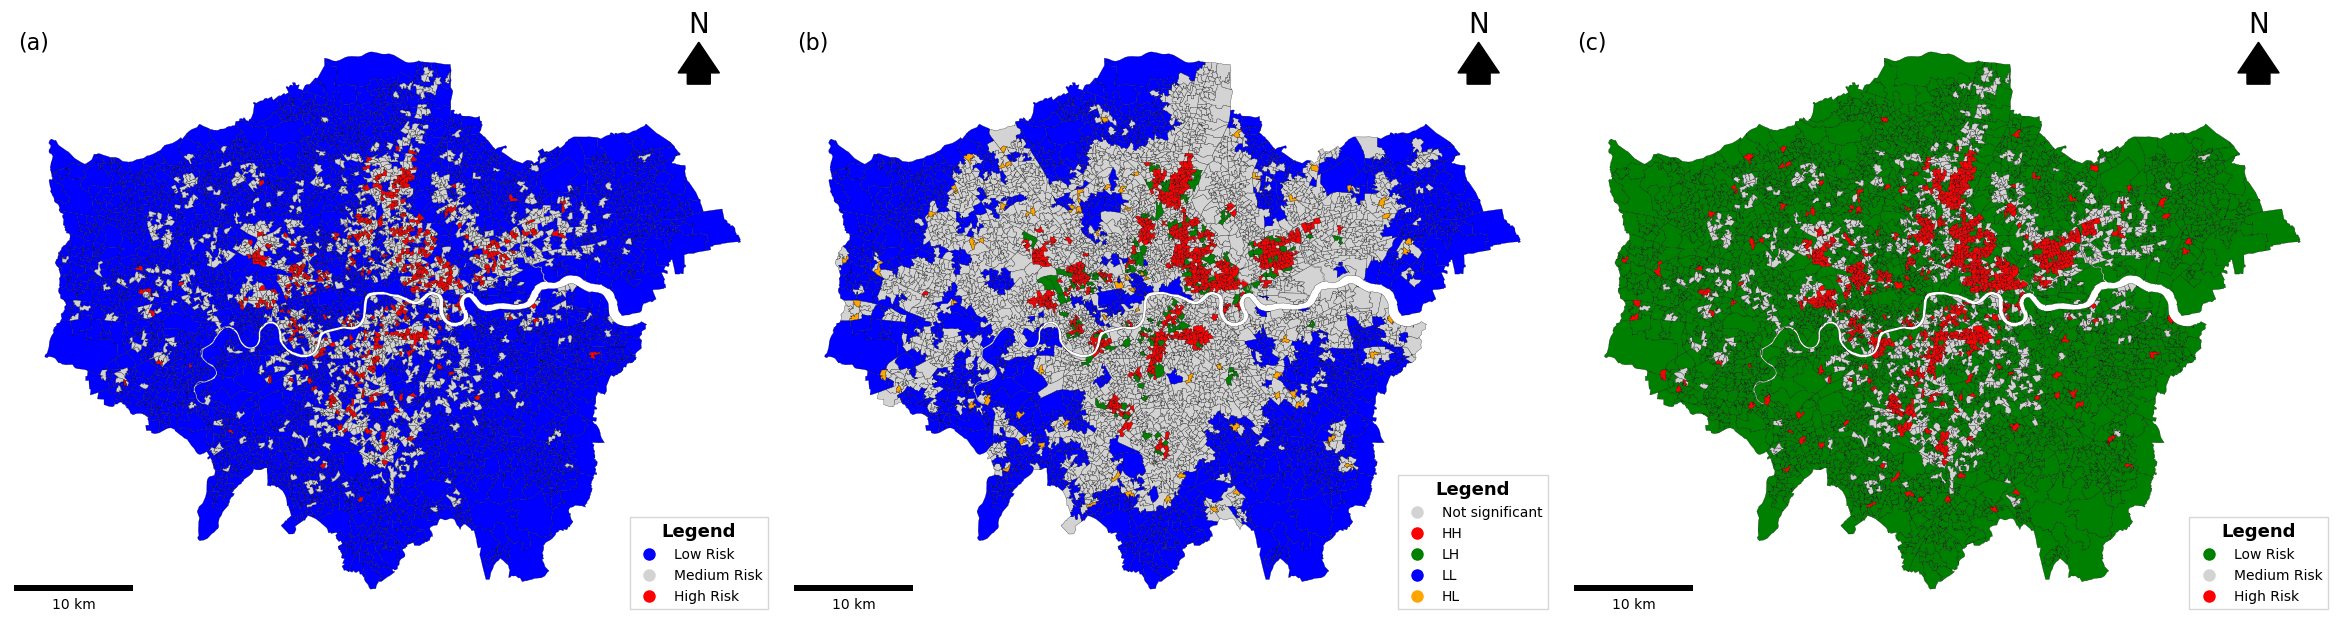

In [70]:
import matplotlib.pyplot as plt
import geopandas as gpd
import matplotlib.lines as mlines
from matplotlib_scalebar.scalebar import ScaleBar
from matplotlib.patches import FancyArrow
from matplotlib.offsetbox import AnchoredOffsetbox, TextArea, VPacker

# Define the color mappings for each plot
color_mapping_natural = {
    'Low Risk': 'blue',
    'Medium Risk': 'lightgrey',
    'High Risk': 'red'
}

color_mapping_cl_label = {
    'Not significant': 'lightgrey',
    'HH': 'red',
    'LH': 'green',
    'LL': 'blue',
    'HL': 'orange'
}

color_mapping_risk_level = {
    'Low Risk': 'green',
    'Medium Risk': 'lightgrey',
    'High Risk': 'red'
}

def add_north_arrow(ax, xy=(0.9, 0.9), size=20, pad=0.1):
    """
    Adds a compass to the given axis
    :param ax: Matplotlib axis object
    :param xy: position of the compass (top right corner)
    :param size: Arrow size
    :param pad: distance between the arrow and the text
    """
    # Create a compass arrow
    arrow = FancyArrow(x=xy[0], y=xy[1], dx=0, dy=0.019, width=0.03, color='black', transform=ax.transAxes, 
                       head_width=0.054, head_length=0.0519)
    ax.add_patch(arrow)

    # Create ‘N’ text
    text = AnchoredOffsetbox(loc='center', child=TextArea("N", textprops=dict(size=size)),
                             pad=pad, frameon=False, bbox_to_anchor=(xy[0], xy[1] + 0.1), 
                             bbox_transform=ax.transAxes, borderpad=0)
    ax.add_artist(text)

# Plotting the three subplots
fig, axs = plt.subplots(1, 3, figsize=(30, 10), gridspec_kw={'wspace': 0.019})

# First plot: risk_category_natural
for risk_category, color in color_mapping_natural.items():
    subset = gdf_home_overall_2019_den[gdf_home_overall_2019_den['risk_category_natural'] == risk_category]
    subset.plot(ax=axs[0], color=color, edgecolor='black', linewidth=0.19)
axs[0].text(0.01, 0.99, '(a)', transform=axs[0].transAxes, fontsize=16, verticalalignment='top')
handles = [mlines.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=label) 
           for label, color in color_mapping_natural.items()]
legend = axs[0].legend(handles=handles, title='Legend', loc='lower right', title_fontsize='13', fancybox=False)
plt.setp(legend.get_title(), ha='left', fontweight='bold')
axs[0].set_axis_off()

# Add scale bar to the first plot
scalebar = ScaleBar(1, location='lower left')  # 1 represents 1 data unit, modify as needed for your units
axs[0].add_artist(scalebar)

# Add north arrow to the first plot
add_north_arrow(axs[0])

# Second plot: cl_label
for label, color in color_mapping_cl_label.items():
    subset = gdf_home_overall_2019_den[gdf_home_overall_2019_den['cl_label'] == label]
    subset.plot(ax=axs[1], color=color, edgecolor='black', linewidth=0.19)
axs[1].text(0.01, 0.99, '(b)', transform=axs[1].transAxes, fontsize=16, verticalalignment='top')
handles = [mlines.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=label) 
           for label, color in color_mapping_cl_label.items()]
legend = axs[1].legend(handles=handles, title='Legend', loc='lower right', title_fontsize='13', fancybox=False)
plt.setp(legend.get_title(), ha='left', fontweight='bold')
axs[1].set_axis_off()

# Add scale bar to the second plot
scalebar = ScaleBar(1, location='lower left')  # Modify units as needed
axs[1].add_artist(scalebar)

# Add north arrow to the second plot
add_north_arrow(axs[1])

# Third plot: risk_level
for risk_category, color in color_mapping_risk_level.items():
    subset = gdf_home_overall_2019_den[gdf_home_overall_2019_den['risk_level'] == risk_category]
    subset.plot(ax=axs[2], color=color, edgecolor='black', linewidth=0.19)
axs[2].text(0.01, 0.99, '(c)', transform=axs[2].transAxes, fontsize=16, verticalalignment='top')
handles = [mlines.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=label) 
           for label, color in color_mapping_risk_level.items()]
legend = axs[2].legend(handles=handles, title='Legend', loc='lower right', title_fontsize='13', fancybox=False)
plt.setp(legend.get_title(), ha='left', fontweight='bold')
axs[2].set_axis_off()

# Add scale bar to the third plot
scalebar = ScaleBar(1, location='lower left')  # Modify units as needed
axs[2].add_artist(scalebar)

# Add north arrow to the third plot
add_north_arrow(axs[2])

# Save the combined plot as an image file
#plt.savefig('vis/6/Comparison figure for research question 1.png', dpi=300, bbox_inches='tight')

# Display the combined plot
plt.show()

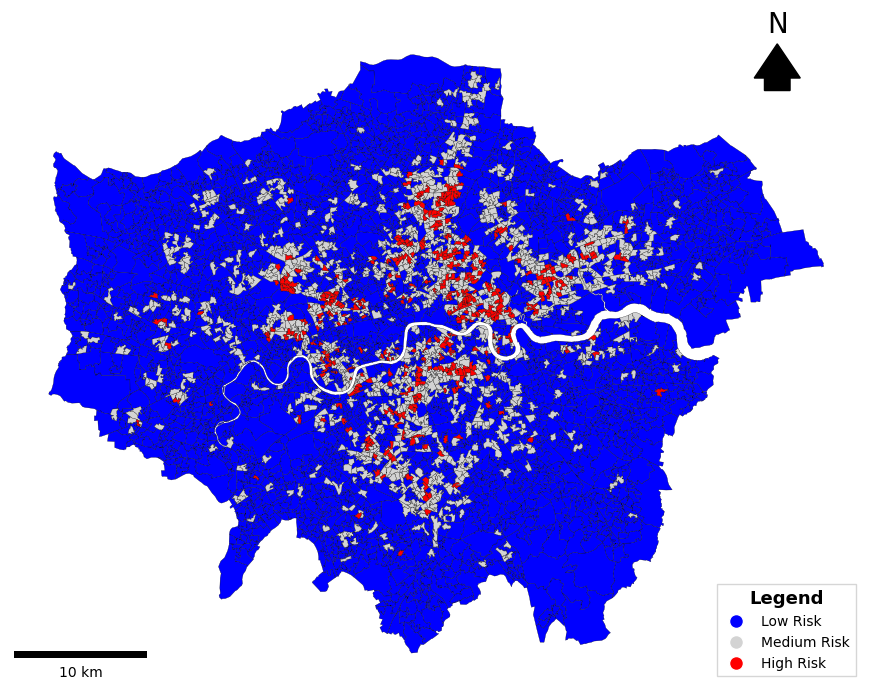

In [71]:
import matplotlib.pyplot as plt
import geopandas as gpd
import matplotlib.lines as mlines
from matplotlib_scalebar.scalebar import ScaleBar
from matplotlib.patches import FancyArrow
from matplotlib.offsetbox import AnchoredOffsetbox, TextArea, VPacker

# Define the color mappings for each plot
color_mapping_natural = {
    'Low Risk': 'blue',
    'Medium Risk': 'lightgrey',
    'High Risk': 'red'
}

def add_north_arrow(ax, xy=(0.9, 0.9), size=20, pad=0.1):
    """
    Adds a compass to the given axis
    :param ax: Matplotlib axis object
    :param xy: position of the compass (top right corner)
    :param size: Arrow size
    :param pad: distance between the arrow and the text
    """
    # Create a compass arrow
    arrow = FancyArrow(x=xy[0], y=xy[1], dx=0, dy=0.019, width=0.03, color='black', transform=ax.transAxes, 
                       head_width=0.054, head_length=0.0519)
    ax.add_patch(arrow)

    # Create ‘N’ text
    text = AnchoredOffsetbox(loc='center', child=TextArea("N", textprops=dict(size=size)),
                             pad=pad, frameon=False, bbox_to_anchor=(xy[0], xy[1] + 0.1), 
                             bbox_transform=ax.transAxes, borderpad=0)
    ax.add_artist(text)

# Plotting the single plot
fig, ax = plt.subplots(figsize=(11, 9))

# Plot: risk_category_natural
for risk_category, color in color_mapping_natural.items():
    subset = gdf_home_overall_2019_den[gdf_home_overall_2019_den['risk_category_natural'] == risk_category]
    subset.plot(ax=ax, color=color, edgecolor='black', linewidth=0.19)
#ax.text(0.01, 0.99, '(a)', transform=ax.transAxes, fontsize=16, verticalalignment='top')
handles = [mlines.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=label) 
           for label, color in color_mapping_natural.items()]
legend = ax.legend(handles=handles, title='Legend', loc='lower right', title_fontsize='13', fancybox=False)
plt.setp(legend.get_title(), ha='left', fontweight='bold')
ax.set_axis_off()

# Add scale bar to the plot
scalebar = ScaleBar(1, location='lower left')  # 1 represents 1 data unit, modify as needed for your units
ax.add_artist(scalebar)

# Add north arrow to the plot
add_north_arrow(ax)

# Save the plot as an image file
#plt.savefig('vis/5/risk_category_natural.png', dpi=300, bbox_inches='tight')

# Display the plot
plt.show()

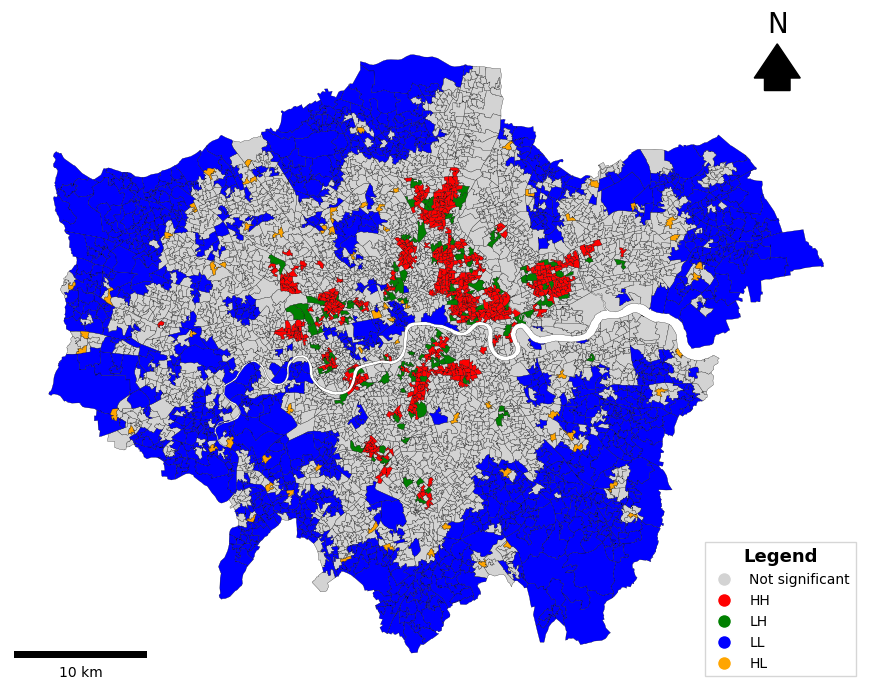

In [72]:
import matplotlib.pyplot as plt
import geopandas as gpd
import matplotlib.lines as mlines
from matplotlib_scalebar.scalebar import ScaleBar
from matplotlib.patches import FancyArrow
from matplotlib.offsetbox import AnchoredOffsetbox, TextArea, VPacker

# Define the color mappings for the plot
color_mapping_cl_label = {
    'Not significant': 'lightgrey',
    'HH': 'red',
    'LH': 'green',
    'LL': 'blue',
    'HL': 'orange'
}

def add_north_arrow(ax, xy=(0.9, 0.9), size=20, pad=0.1):
    """
    Adds a compass to the given axis
    :param ax: Matplotlib axis object
    :param xy: position of the compass (top right corner)
    :param size: Arrow size
    :param pad: distance between the arrow and the text
    """
    # Create a compass arrow
    arrow = FancyArrow(x=xy[0], y=xy[1], dx=0, dy=0.019, width=0.03, color='black', transform=ax.transAxes, 
                       head_width=0.054, head_length=0.0519)
    ax.add_patch(arrow)

    # Create ‘N’ text
    text = AnchoredOffsetbox(loc='center', child=TextArea("N", textprops=dict(size=size)),
                             pad=pad, frameon=False, bbox_to_anchor=(xy[0], xy[1] + 0.1), 
                             bbox_transform=ax.transAxes, borderpad=0)
    ax.add_artist(text)

# Plotting the single plot
fig, ax = plt.subplots(figsize=(11, 9))

# Plot: cl_label
for label, color in color_mapping_cl_label.items():
    subset = gdf_home_overall_2019_den[gdf_home_overall_2019_den['cl_label'] == label]
    subset.plot(ax=ax, color=color, edgecolor='black', linewidth=0.19)
#ax.text(0.01, 0.99, '(b)', transform=ax.transAxes, fontsize=16, verticalalignment='top')
handles = [mlines.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=label) 
           for label, color in color_mapping_cl_label.items()]
legend = ax.legend(handles=handles, title='Legend', loc='lower right', title_fontsize='13', fancybox=False)
plt.setp(legend.get_title(), ha='left', fontweight='bold')
ax.set_axis_off()

# Add scale bar to the plot
scalebar = ScaleBar(1, location='lower left')  # 1 represents 1 data unit, modify as needed for your units
ax.add_artist(scalebar)

# Add north arrow to the plot
add_north_arrow(ax)

# Save the plot as an image file
#plt.savefig('vis/5/cl_label.png', dpi=300, bbox_inches='tight')

# Display the plot
plt.show()

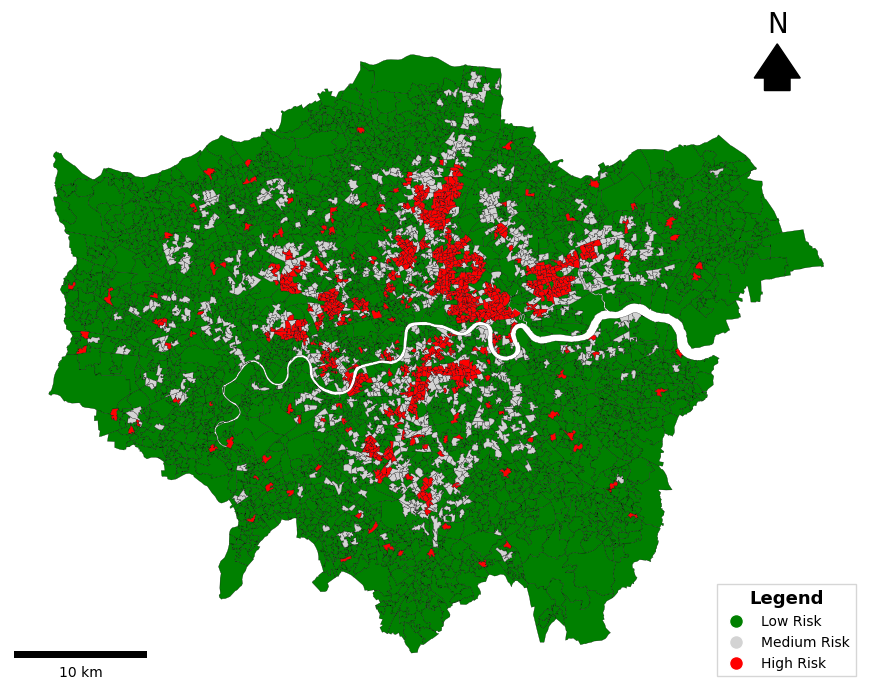

In [73]:
import matplotlib.pyplot as plt
import geopandas as gpd
import matplotlib.lines as mlines
from matplotlib_scalebar.scalebar import ScaleBar
from matplotlib.patches import FancyArrow
from matplotlib.offsetbox import AnchoredOffsetbox, TextArea, VPacker

# Define the color mappings for the plot
color_mapping_risk_level = {
    'Low Risk': 'green',
    'Medium Risk': 'lightgrey',
    'High Risk': 'red'
}

def add_north_arrow(ax, xy=(0.9, 0.9), size=20, pad=0.1):
    """
    Adds a compass to the given axis
    :param ax: Matplotlib axis object
    :param xy: position of the compass (top right corner)
    :param size: Arrow size
    :param pad: distance between the arrow and the text
    """
    # Create a compass arrow
    arrow = FancyArrow(x=xy[0], y=xy[1], dx=0, dy=0.019, width=0.03, color='black', transform=ax.transAxes, 
                       head_width=0.054, head_length=0.0519)
    ax.add_patch(arrow)

    # Create ‘N’ text
    text = AnchoredOffsetbox(loc='center', child=TextArea("N", textprops=dict(size=size)),
                             pad=pad, frameon=False, bbox_to_anchor=(xy[0], xy[1] + 0.1), 
                             bbox_transform=ax.transAxes, borderpad=0)
    ax.add_artist(text)

# Plotting the single plot
fig, ax = plt.subplots(figsize=(11, 9))

# Plot: risk_level
for risk_category, color in color_mapping_risk_level.items():
    subset = gdf_home_overall_2019_den[gdf_home_overall_2019_den['risk_level'] == risk_category]
    subset.plot(ax=ax, color=color, edgecolor='black', linewidth=0.19)
#ax.text(0.01, 0.99, '(c)', transform=ax.transAxes, fontsize=16, verticalalignment='top')
handles = [mlines.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=label) 
           for label, color in color_mapping_risk_level.items()]
legend = ax.legend(handles=handles, title='Legend', loc='lower right', title_fontsize='13', fancybox=False)
plt.setp(legend.get_title(), ha='left', fontweight='bold')
ax.set_axis_off()

# Add scale bar to the plot
scalebar = ScaleBar(1, location='lower left')  # 1 represents 1 data unit, modify as needed for your units
ax.add_artist(scalebar)

# Add north arrow to the plot
add_north_arrow(ax)

# Save the plot as an image file
#plt.savefig('vis/5/risk_level.png', dpi=300, bbox_inches='tight')

# Display the plot
plt.show()

In [74]:
#gdf_home_overall_2019_den.to_csv('processed_data_den/gdf_home_overall_2019_den.csv',index=False)

# 3. Research question 2

#### Before regression

In [75]:
gdf_home_overall_2019_den.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 4835 entries, 0 to 4834
Data columns (total 26 columns):
 #   Column                                   Non-Null Count  Dtype   
---  ------                                   --------------  -----   
 0   geometry                                 4835 non-null   geometry
 1   LSOA11CD                                 4835 non-null   object  
 2   LSOA11NM                                 4835 non-null   object  
 3   LAD11CD                                  4835 non-null   object  
 4   LAD11NM                                  4835 non-null   object  
 5   Mid_2019_population                      4835 non-null   int64   
 6   People_per_Sq_Km                         4835 non-null   float64 
 7   Road_Length                              4835 non-null   float64 
 8   Income_Score_rate                        4835 non-null   float64 
 9   Employment_Score_rate                    4835 non-null   float64 
 10  Education_Skills_and_Trainin

In [76]:
# gdf_home_overall_2019_den.to_file('processed_data/gdf_overall.shp')

In [77]:
# df_home_overall_2019_den = gdf_home_overall_2019_den.copy()

In [78]:
mean_accident_rate_home_overall = gdf_home_overall_2019_den['overall_home_den_casrate'].mean()
var_accident_rate_home_overall = gdf_home_overall_2019_den['overall_home_den_casrate'].var()
print(f"Mean: {mean_accident_rate_home_overall}, Variance: {var_accident_rate_home_overall}")

Mean: 29.041539077858072, Variance: 755.2395660662919


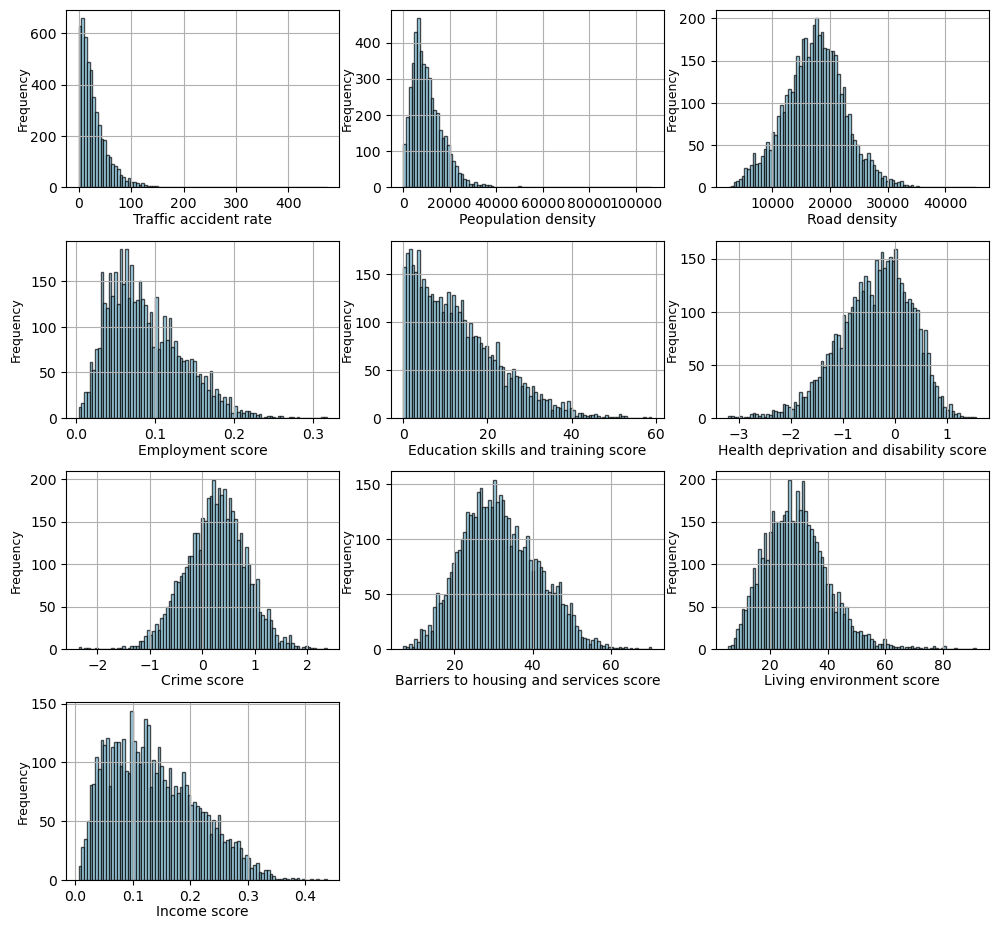

In [79]:
# Histograms of description of data (plotting)

# create subplot
fig, ax = plt.subplots(4, 3, figsize=(11.9, 11.3)) 

# Plotting the histogram
ax[0,0].hist(gdf_home_overall_2019_den.overall_home_den_casrate, bins=91, color='skyblue', edgecolor='black', alpha=0.7)
ax[0,1].hist(gdf_home_overall_2019_den['People_per_Sq_Km'], bins=91, color='skyblue', edgecolor='black', alpha=0.7)
ax[0,2].hist(gdf_home_overall_2019_den['Road_Length'], bins=91, color='skyblue', edgecolor='black', alpha=0.7)
ax[1,0].hist(gdf_home_overall_2019_den['Employment_Score_rate'], bins=91, color='skyblue', edgecolor='black', alpha=0.7)
ax[1,1].hist(gdf_home_overall_2019_den['Education_Skills_and_Training_Score'], bins=91, color='skyblue', edgecolor='black', alpha=0.7)
ax[1,2].hist(gdf_home_overall_2019_den['Health_Deprivation_and_Disability_Score'], bins=91, color='skyblue', edgecolor='black', alpha=0.7)
ax[2,0].hist(gdf_home_overall_2019_den['Crime_Score'], bins=91, color='skyblue', edgecolor='black', alpha=0.7)
ax[2,1].hist(gdf_home_overall_2019_den['Barriers_to_Housing_and_Services_Score'], bins=91, color='skyblue', edgecolor='black', alpha=0.7)
ax[2,2].hist(gdf_home_overall_2019_den['Living_Environment_Score'], bins=91, color='skyblue', edgecolor='black', alpha=0.7)
ax[3,0].hist(gdf_home_overall_2019_den['Income_Score_rate'], bins=91, color='skyblue', edgecolor='black', alpha=0.7)

# hide unused subgraphs ax[2,2].
ax[3,1].set_visible(False)
ax[3,2].set_visible(False)

# Adding labels
ax[0,0].set_xlabel('Traffic accident rate', fontsize=10, labelpad=1)
ax[0,0].set_ylabel('Frequency', fontsize=9, labelpad=0.5)
ax[0,1].set_xlabel('Peopulation density', fontsize=10, labelpad=1)
ax[0,1].set_ylabel('Frequency', fontsize=9, labelpad=0.5)
ax[0,2].set_xlabel('Road density', fontsize=10, labelpad=1)
ax[0,2].set_ylabel('Frequency', fontsize=9, labelpad=0.5)
ax[1,0].set_xlabel('Employment score', fontsize=10, labelpad=1)
ax[1,0].set_ylabel('Frequency', fontsize=9, labelpad=5)
ax[1,1].set_xlabel('Education skills and training score', fontsize=10, labelpad=1)
ax[1,1].set_ylabel('Frequency', fontsize=9, labelpad=0.5)
ax[1,2].set_xlabel('Health deprivation and disability score', fontsize=10, labelpad=1)
ax[1,2].set_ylabel('Frequency', fontsize=9, labelpad=0.5)
ax[2,0].set_xlabel('Crime score', fontsize=10, labelpad=1)
ax[2,0].set_ylabel('Frequency', fontsize=9, labelpad=5)
ax[2,1].set_xlabel('Barriers to housing and services score', fontsize=10, labelpad=1)
ax[2,1].set_ylabel('Frequency', fontsize=9, labelpad=0.5)
ax[2,2].set_xlabel('Living environment score', fontsize=10, labelpad=1)
ax[2,2].set_ylabel('Frequency', fontsize=9, labelpad=0.5)
ax[3,0].set_xlabel('Income score', fontsize=10, labelpad=1)
ax[3,0].set_ylabel('Frequency', fontsize=9, labelpad=0.5)

# plt.title('Histogram of Residuals of the Linear Model')

#fig.text(0.46, -0.0,
#         'Figure 4.3.2. Presentation of data at the scale of London LSOAs',
#         ha='center', va='bottom', fontsize=13)

# Adding grid lines (optional)
ax[0,0].grid(True)
ax[0,1].grid(True)
ax[0,2].grid(True)
ax[1,0].grid(True)
ax[1,1].grid(True)
ax[1,2].grid(True)
ax[2,0].grid(True)
ax[2,1].grid(True)
ax[2,2].grid(True)
ax[3,0].grid(True)

#plt.savefig('vis/3/basic_preprocessing', dpi=311, bbox_inches='tight')
plt.subplots_adjust(wspace=0.19, hspace=0.3)

# Display the plot
plt.show()

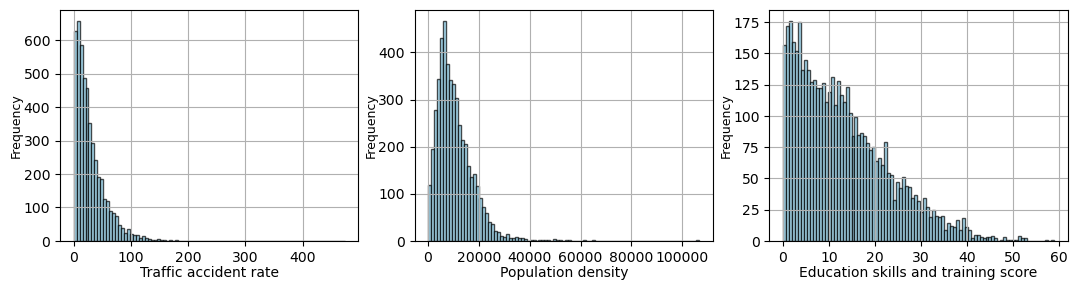

In [167]:
import matplotlib.pyplot as plt

# create subplot with 1 row and 3 columns
fig, ax = plt.subplots(1, 3, figsize=(13, 3)) 

# Plotting the selected histograms
ax[0].hist(gdf_home_overall_2019_den.overall_home_den_casrate, bins=91, color='skyblue', edgecolor='black', alpha=0.7)
ax[1].hist(gdf_home_overall_2019_den['People_per_Sq_Km'], bins=91, color='skyblue', edgecolor='black', alpha=0.7)
ax[2].hist(gdf_home_overall_2019_den['Education_Skills_and_Training_Score'], bins=91, color='skyblue', edgecolor='black', alpha=0.7)

# Adding labels
ax[0].set_xlabel('Traffic accident rate', fontsize=10, labelpad=1)
ax[0].set_ylabel('Frequency', fontsize=9, labelpad=0.5)
ax[1].set_xlabel('Population density', fontsize=10, labelpad=1)
ax[1].set_ylabel('Frequency', fontsize=9, labelpad=0.5)
ax[2].set_xlabel('Education skills and training score', fontsize=10, labelpad=1)
ax[2].set_ylabel('Frequency', fontsize=9, labelpad=0.5)

# Adding grid lines (optional)
ax[0].grid(True)
ax[1].grid(True)
ax[2].grid(True)

plt.savefig('vis/3/3_2', dpi=311, bbox_inches='tight')

# Adjust the layout and show the plot
plt.subplots_adjust(wspace=0.19, hspace=0.3)
plt.show()

In [166]:
gdf_home_overall_2019_den['log_overall_home_den_casrate'] = np.log(gdf_home_overall_2019_den['overall_home_den_casrate'] + 1)

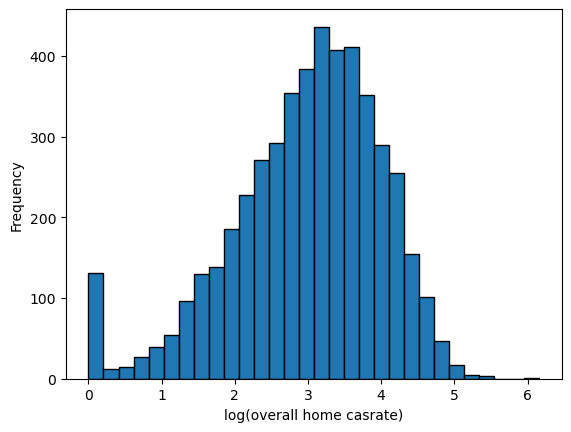

In [81]:
plt.hist(gdf_home_overall_2019_den['log_overall_home_den_casrate'], bins=30, edgecolor='k')
plt.xlabel('log(overall home casrate)')
plt.ylabel('Frequency')
plt.show()

In [82]:
# 对高度偏斜的自变量进行对数变换（加1）
gdf_home_overall_2019_den['log_People_per_Sq_Km'] = np.log(gdf_home_overall_2019_den['People_per_Sq_Km'])
#gdf_home_overall_2019_den['log_Road_Length'] = np.log(gdf_home_overall_2019_den['Road_Length'])
gdf_home_overall_2019_den['log_Education_Skills_and_Training_Score'] = np.log(gdf_home_overall_2019_den['Education_Skills_and_Training_Score'] + 1)

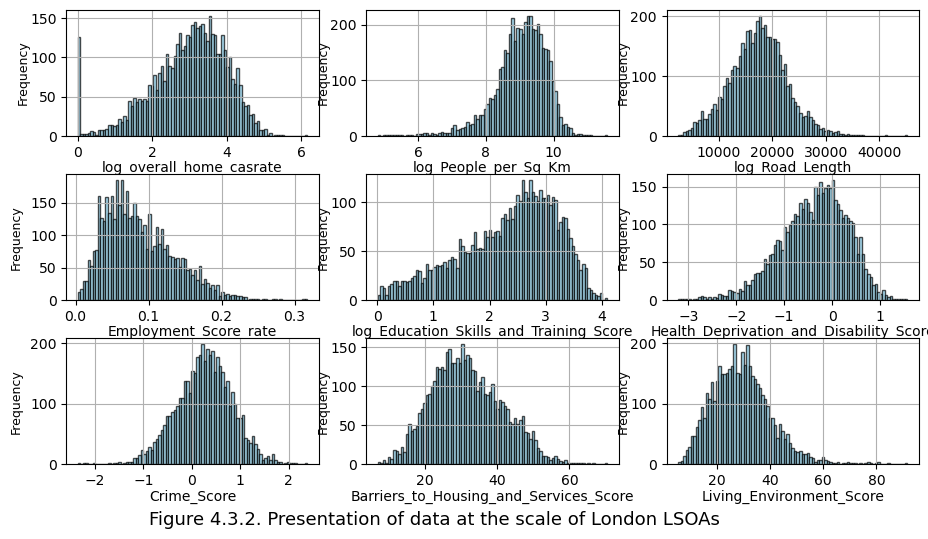

In [83]:
# Histograms of description of data (plotting)

# create subplot
fig, ax = plt.subplots(3, 3, figsize=(11, 5.9)) 

# Plotting the histogram
ax[0,0].hist(gdf_home_overall_2019_den.log_overall_home_den_casrate, bins=91, color='skyblue', edgecolor='black', alpha=0.7)
ax[0,1].hist(gdf_home_overall_2019_den['log_People_per_Sq_Km'], bins=91, color='skyblue', edgecolor='black', alpha=0.7)
ax[0,2].hist(gdf_home_overall_2019_den['Road_Length'], bins=91, color='skyblue', edgecolor='black', alpha=0.7)
ax[1,0].hist(gdf_home_overall_2019_den['Employment_Score_rate'], bins=91, color='skyblue', edgecolor='black', alpha=0.7)
ax[1,1].hist(gdf_home_overall_2019_den['log_Education_Skills_and_Training_Score'], bins=91, color='skyblue', edgecolor='black', alpha=0.7)
ax[1,2].hist(gdf_home_overall_2019_den['Health_Deprivation_and_Disability_Score'], bins=91, color='skyblue', edgecolor='black', alpha=0.7)
ax[2,0].hist(gdf_home_overall_2019_den['Crime_Score'], bins=91, color='skyblue', edgecolor='black', alpha=0.7)
ax[2,1].hist(gdf_home_overall_2019_den['Barriers_to_Housing_and_Services_Score'], bins=91, color='skyblue', edgecolor='black', alpha=0.7)
ax[2,2].hist(gdf_home_overall_2019_den['Living_Environment_Score'], bins=91, color='skyblue', edgecolor='black', alpha=0.7)

# hide unused subgraphs ax[2,2].
# ax[2,2].set_visible(False) # make ax[2,2] invisible

# Adding labels
ax[0,0].set_xlabel('log_overall_home_casrate', fontsize=10, labelpad=1)
ax[0,0].set_ylabel('Frequency', fontsize=9, labelpad=0.5)
ax[0,1].set_xlabel('log_People_per_Sq_Km', fontsize=10, labelpad=1)
ax[0,1].set_ylabel('Frequency', fontsize=9, labelpad=0.5)
ax[0,2].set_xlabel('log_Road_Length', fontsize=10, labelpad=1)
ax[0,2].set_ylabel('Frequency', fontsize=9, labelpad=0.5)
ax[1,0].set_xlabel('Employment_Score_rate', fontsize=10, labelpad=1)
ax[1,0].set_ylabel('Frequency', fontsize=9, labelpad=5)
ax[1,1].set_xlabel('log_Education_Skills_and_Training_Score', fontsize=10, labelpad=1)
ax[1,1].set_ylabel('Frequency', fontsize=9, labelpad=0.5)
ax[1,2].set_xlabel('Health_Deprivation_and_Disability_Score', fontsize=10, labelpad=1)
ax[1,2].set_ylabel('Frequency', fontsize=9, labelpad=0.5)
ax[2,0].set_xlabel('Crime_Score', fontsize=10, labelpad=1)
ax[2,0].set_ylabel('Frequency', fontsize=9, labelpad=5)
ax[2,1].set_xlabel('Barriers_to_Housing_and_Services_Score', fontsize=10, labelpad=1)
ax[2,1].set_ylabel('Frequency', fontsize=9, labelpad=0.5)
ax[2,2].set_xlabel('Living_Environment_Score', fontsize=10, labelpad=1)
ax[2,2].set_ylabel('Frequency', fontsize=9, labelpad=0.5)

# plt.title('Histogram of Residuals of the Linear Model')

fig.text(0.46, -0.0,
         'Figure 4.3.2. Presentation of data at the scale of London LSOAs',
         ha='center', va='bottom', fontsize=13)

# Adding grid lines (optional)
ax[0,0].grid(True)
ax[0,1].grid(True)
ax[0,2].grid(True)
ax[1,0].grid(True)
ax[1,1].grid(True)
ax[1,2].grid(True)
ax[2,0].grid(True)
ax[2,1].grid(True)
ax[2,2].grid(True)

# plt.savefig('descriptio', dpi=311, bbox_inches='tight')
plt.subplots_adjust(wspace=0.19, hspace=0.3)

# Display the plot
plt.show()

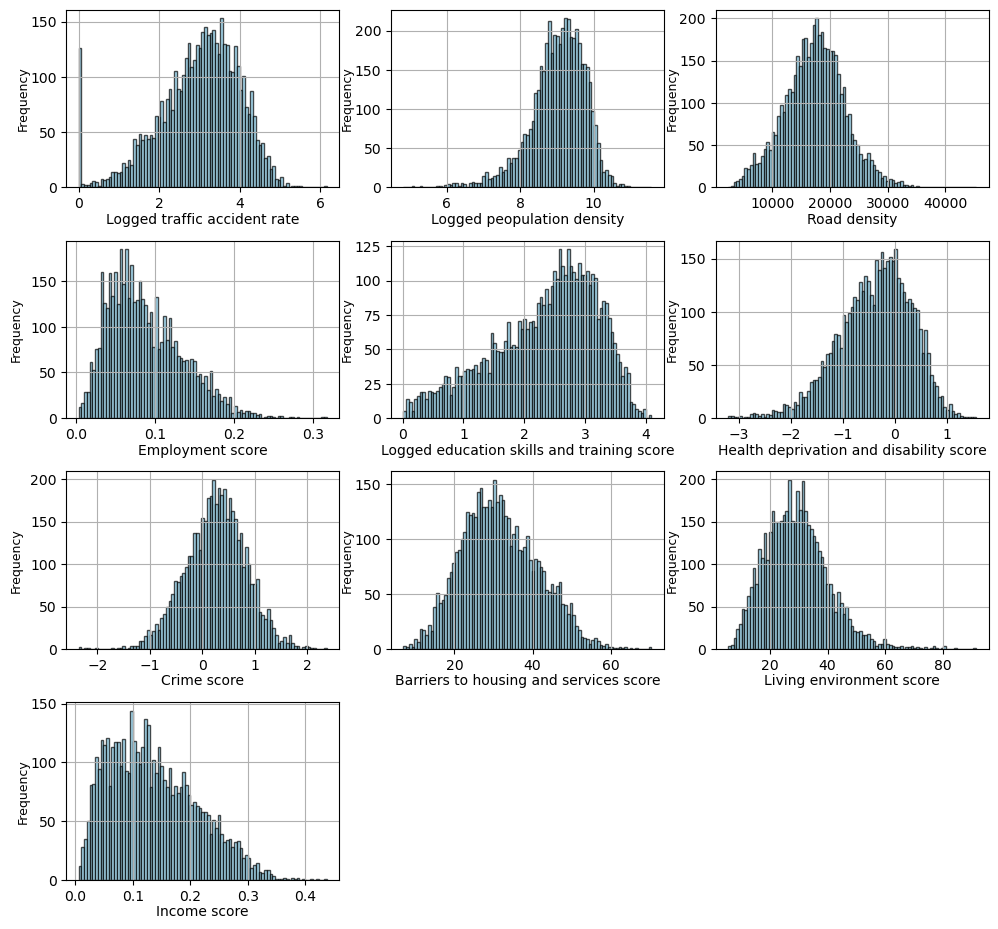

In [84]:
# Histograms of description of data (plotting)

# create subplot
fig, ax = plt.subplots(4, 3, figsize=(11.9, 11.3)) 

# Plotting the histogram
ax[0,0].hist(gdf_home_overall_2019_den.log_overall_home_den_casrate, bins=91, color='skyblue', edgecolor='black', alpha=0.7)
ax[0,1].hist(gdf_home_overall_2019_den['log_People_per_Sq_Km'], bins=91, color='skyblue', edgecolor='black', alpha=0.7)
ax[0,2].hist(gdf_home_overall_2019_den['Road_Length'], bins=91, color='skyblue', edgecolor='black', alpha=0.7)
ax[1,0].hist(gdf_home_overall_2019_den['Employment_Score_rate'], bins=91, color='skyblue', edgecolor='black', alpha=0.7)
ax[1,1].hist(gdf_home_overall_2019_den['log_Education_Skills_and_Training_Score'], bins=91, color='skyblue', edgecolor='black', alpha=0.7)
ax[1,2].hist(gdf_home_overall_2019_den['Health_Deprivation_and_Disability_Score'], bins=91, color='skyblue', edgecolor='black', alpha=0.7)
ax[2,0].hist(gdf_home_overall_2019_den['Crime_Score'], bins=91, color='skyblue', edgecolor='black', alpha=0.7)
ax[2,1].hist(gdf_home_overall_2019_den['Barriers_to_Housing_and_Services_Score'], bins=91, color='skyblue', edgecolor='black', alpha=0.7)
ax[2,2].hist(gdf_home_overall_2019_den['Living_Environment_Score'], bins=91, color='skyblue', edgecolor='black', alpha=0.7)
ax[3,0].hist(gdf_home_overall_2019_den['Income_Score_rate'], bins=91, color='skyblue', edgecolor='black', alpha=0.7)

# hide unused subgraphs ax[2,2].
ax[3,1].set_visible(False)
ax[3,2].set_visible(False)

# Adding labels
ax[0,0].set_xlabel('Logged traffic accident rate', fontsize=10, labelpad=1)
ax[0,0].set_ylabel('Frequency', fontsize=9, labelpad=0.5)
ax[0,1].set_xlabel('Logged peopulation density', fontsize=10, labelpad=1)
ax[0,1].set_ylabel('Frequency', fontsize=9, labelpad=0.5)
ax[0,2].set_xlabel('Road density', fontsize=10, labelpad=1)
ax[0,2].set_ylabel('Frequency', fontsize=9, labelpad=0.5)
ax[1,0].set_xlabel('Employment score', fontsize=10, labelpad=1)
ax[1,0].set_ylabel('Frequency', fontsize=9, labelpad=5)
ax[1,1].set_xlabel('Logged education skills and training score', fontsize=10, labelpad=1)
ax[1,1].set_ylabel('Frequency', fontsize=9, labelpad=0.5)
ax[1,2].set_xlabel('Health deprivation and disability score', fontsize=10, labelpad=1)
ax[1,2].set_ylabel('Frequency', fontsize=9, labelpad=0.5)
ax[2,0].set_xlabel('Crime score', fontsize=10, labelpad=1)
ax[2,0].set_ylabel('Frequency', fontsize=9, labelpad=5)
ax[2,1].set_xlabel('Barriers to housing and services score', fontsize=10, labelpad=1)
ax[2,1].set_ylabel('Frequency', fontsize=9, labelpad=0.5)
ax[2,2].set_xlabel('Living environment score', fontsize=10, labelpad=1)
ax[2,2].set_ylabel('Frequency', fontsize=9, labelpad=0.5)
ax[3,0].set_xlabel('Income score', fontsize=10, labelpad=1)
ax[3,0].set_ylabel('Frequency', fontsize=9, labelpad=0.5)

# plt.title('Histogram of Residuals of the Linear Model')

#fig.text(0.46, -0.0,
#         'Figure 4.3.2. Presentation of data at the scale of London LSOAs',
#         ha='center', va='bottom', fontsize=13)

# Adding grid lines (optional)
ax[0,0].grid(True)
ax[0,1].grid(True)
ax[0,2].grid(True)
ax[1,0].grid(True)
ax[1,1].grid(True)
ax[1,2].grid(True)
ax[2,0].grid(True)
ax[2,1].grid(True)
ax[2,2].grid(True)
ax[3,0].grid(True)

#plt.savefig('vis/3/logged_preprocessing', dpi=311, bbox_inches='tight')
plt.subplots_adjust(wspace=0.19, hspace=0.3)

# Display the plot
plt.show()

In [85]:
# simple correlation between different independent variables
correlation_matrix_X_home_overall = gdf_home_overall_2019_den[['log_People_per_Sq_Km', 'Road_Length', 'Income_Score_rate', 
                                                               'Employment_Score_rate', 
                                                               'log_Education_Skills_and_Training_Score', 
                                                               'Health_Deprivation_and_Disability_Score', 
                                                               'Crime_Score', 
                                                               'Barriers_to_Housing_and_Services_Score', 
                                                               'Living_Environment_Score']].corr()

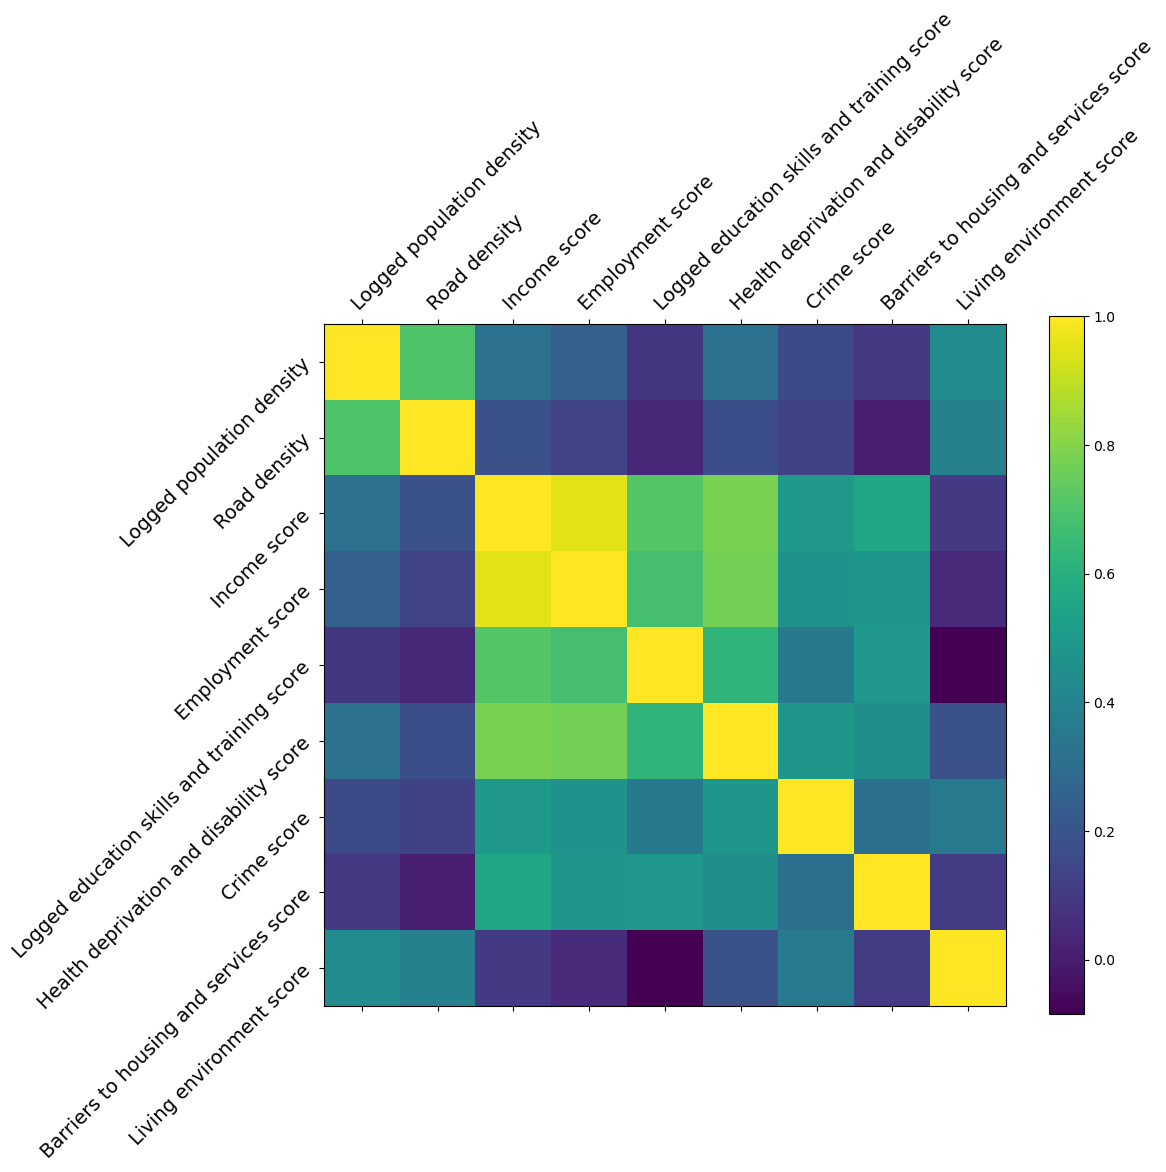

In [196]:
# Select the variables and calculate the correlation matrix
correlation_matrix_X_home_overall = gdf_home_overall_2019_den[['log_People_per_Sq_Km', 'Road_Length', 'Income_Score_rate', 
                                                               'Employment_Score_rate', 
                                                               'log_Education_Skills_and_Training_Score', 
                                                               'Health_Deprivation_and_Disability_Score', 
                                                               'Crime_Score', 
                                                               'Barriers_to_Housing_and_Services_Score', 
                                                               'Living_Environment_Score']].corr()

# Create a mapping of variable names to the desired format for the plot
name_mapping = {
    'log_People_per_Sq_Km': 'Logged population density',
    'Road_Length': 'Road density',
    'Income_Score_rate': 'Income score',
    'Employment_Score_rate': 'Employment score',
    'log_Education_Skills_and_Training_Score': 'Logged education skills and training score',
    'Health_Deprivation_and_Disability_Score': 'Health deprivation and disability score',
    'Crime_Score': 'Crime score',
    'Barriers_to_Housing_and_Services_Score': 'Barriers to housing and services score',
    'Living_Environment_Score': 'Living environment score'
}

# Plot the correlation matrix
plt.rcParams["axes.grid"] = False  # Disable grid lines on the plot
f = plt.figure(figsize=(11, 9))  # Set the figure size
plt.matshow(correlation_matrix_X_home_overall, fignum=f.number)  # Display the correlation matrix as a matrix plot

# Set x-axis and y-axis ticks and labels
plt.xticks(range(correlation_matrix_X_home_overall.shape[1]), 
           [name_mapping.get(col, col).replace('_', ' ') for col in correlation_matrix_X_home_overall.columns], 
           fontsize=14, rotation=45, ha='left', rotation_mode='anchor')  # Rotate labels on the x-axis for better readability
plt.yticks(range(correlation_matrix_X_home_overall.shape[1]), 
           [name_mapping.get(col, col).replace('_', ' ') for col in correlation_matrix_X_home_overall.columns], 
           fontsize=14, rotation=45)  # Set labels on the y-axis

# Add color bar to indicate correlation strength
cb = plt.colorbar()
cb.ax.tick_params(labelsize=10)  # Adjust color bar label size

# Add a title to the plot
#plt.title('Correlation Matrix', fontsize=13, y=-0.19)

plt.savefig('vis/3/co_matrix', dpi=311, bbox_inches='tight')

# Show the plot
plt.show()

In [86]:
#correlation_matrix_X_home_overall.to_csv('processed_data_v91/correlation_matrix_X_home_overall.csv', index=True)

In [87]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm

In [88]:
# VIF of independent variables

# Extract data from the independent variable
X_home_overall = gdf_home_overall_2019_den[['log_People_per_Sq_Km', 'Road_Length', 'Income_Score_rate', 
                                            'Employment_Score_rate', 
                                            'log_Education_Skills_and_Training_Score', 
                                            'Health_Deprivation_and_Disability_Score', 
                                            'Crime_Score', 'Barriers_to_Housing_and_Services_Score', 'Living_Environment_Score']]

# Add constant term
X_home_overall = sm.add_constant(X_home_overall)

# Calculate VIF
vif_data_home_overall = pd.DataFrame()
vif_data_home_overall["feature"] = X_home_overall.columns
vif_data_home_overall["VIF"] = [variance_inflation_factor(X_home_overall.values, i) for i in range(X_home_overall.shape[1])]
print(vif_data_home_overall)

                                   feature         VIF
0                                    const  289.169254
1                     log_People_per_Sq_Km    2.466774
2                              Road_Length    2.024074
3                        Income_Score_rate   14.743487
4                    Employment_Score_rate   11.846382
5  log_Education_Skills_and_Training_Score    2.319707
6  Health_Deprivation_and_Disability_Score    2.950288
7                              Crime_Score    1.628922
8   Barriers_to_Housing_and_Services_Score    1.602260
9                 Living_Environment_Score    1.602254


In [89]:
#vif_data_home_overall.to_csv('processed_data_v91/vif_data_home_overall.csv', index=True)

In [90]:
# VIF of independent variables

# Extract data from the independent variable
X_home_overall = gdf_home_overall_2019_den[['log_People_per_Sq_Km', 'Road_Length', 'Employment_Score_rate', 
                                            'log_Education_Skills_and_Training_Score', 
                                            'Health_Deprivation_and_Disability_Score', 
                                            'Crime_Score', 'Barriers_to_Housing_and_Services_Score', 'Living_Environment_Score']]

# Add constant term
X_home_overall = sm.add_constant(X_home_overall)

# Calculate VIF
vif_data_home_overall_reduced = pd.DataFrame()
vif_data_home_overall_reduced["feature"] = X_home_overall.columns
vif_data_home_overall_reduced["VIF"] = [variance_inflation_factor(X_home_overall.values, i) for i in range(X_home_overall.shape[1])]
print(vif_data_home_overall_reduced)

                                   feature         VIF
0                                    const  259.740194
1                     log_People_per_Sq_Km    2.301634
2                              Road_Length    2.023206
3                    Employment_Score_rate    3.160361
4  log_Education_Skills_and_Training_Score    2.206505
5  Health_Deprivation_and_Disability_Score    2.932176
6                              Crime_Score    1.593936
7   Barriers_to_Housing_and_Services_Score    1.453071
8                 Living_Environment_Score    1.601386


In [91]:
#vif_data_home_overall_reduced.to_csv('processed_data_v91/vif_data_home_overall_reduced.csv', index=True)

## 3.1 Global models

### 3.1.1 OLS regression

In [92]:
# Define the independent and dependent variables
y_overall = gdf_home_overall_2019_den['log_overall_home_den_casrate'].values
X_overall = gdf_home_overall_2019_den[['log_People_per_Sq_Km', 'Road_Length', 'Employment_Score_rate', 
         'log_Education_Skills_and_Training_Score', 'Health_Deprivation_and_Disability_Score', 
         'Crime_Score', 'Barriers_to_Housing_and_Services_Score', 'Living_Environment_Score']].values
# Standardised our data to have mean of 0 and standard deviation of 1
X_overall = (X_overall - X_overall.mean(axis=0)) / X_overall.std(axis=0)

y_overall = y_overall.reshape((-1,1))

y_overall = (y_overall - y_overall.mean(axis=0)) / y_overall.std(axis=0)

X_overall = np.array(X_overall).astype(float)
y_overall = np.array(y_overall).astype(float)

OLS_results = sm.OLS(y_overall, exog=sm.add_constant(X_overall)).fit()
OLS_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.578
Model:                            OLS   Adj. R-squared:                  0.578
Method:                 Least Squares   F-statistic:                     827.8
Date:                Tue, 20 Aug 2024   Prob (F-statistic):               0.00
Time:                        00:59:37   Log-Likelihood:                -4772.3
No. Observations:                4835   AIC:                             9563.
Df Residuals:                    4826   BIC:                             9621.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1.169e-16      0.009  -1.25e-14      1.000      -0.018       0.018
x1             0.6321      0.014     44.582      0.000       0.604       0.660
x2            -0.0087      0.013     -0.654      0.513      -0.035       0.017
x3             0.0851      0.017      5.123      0.000       0.053       0.118
x4             0.0493      0.014      3.552      0.000       0.022       0.077
x5             0.1052      0.016      6.572      0.000       0.074       0.137
x6             0.0523      0.012      4.436      0.000       0.029       0.075
x7             0.0692      0.011      6.146      0.000       0.047       0.091
x8             0.0137      0.012      1.160      0.246      -0.009       0.037
==============================================================================
Omnibus:                     1886.943   Durbin-Watson:                   1.821
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            10524.764
Skew:                          -1.782   Prob(JB):                         0.00
Kurtosis:                       9.288   Cond. No.                         3.96
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [93]:
#import numpy as np
#import geopandas as gpd
#import pysal
from pysal.lib import weights
from pysal.explore import esda
#from scipy import stats
#import statsmodels.api as sm

# Assume gdf_home_overall_2019_den is your GeoDataFrame
# Calculate the spatial weight matrix, here using Queen Contiguity as an example
w_ols = weights.Queen.from_dataframe(gdf_home_overall_2019_den)
w_ols.transform = 'R'

# Get the residuals
OLS_results_residuals = OLS_results.resid

# Calculate Global Moran's I
OLS_results_moran = esda.moran.Moran(OLS_results_residuals, w_ols)
print(f"Moran's I: {OLS_results_moran.I}, p-value: {OLS_results_moran.p_sim}")

/opt/conda/lib/python3.11/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)
/opt/conda/lib/python3.11/site-packages/quantecon/lss.py:19: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit
/opt/conda/lib/python3.11/site-packages/spaghetti/network.py:40: FutureWarning: The next major release of pysal/spaghetti (2.0.0) will drop support for all ``libpysal.cg`` geometries. This change is a first 

Moran's I: 0.06740916783189636, p-value: 0.001


## 3.1.2 Spatial Lag model

In [97]:
# Import the necessary libraries
import pandas as pd
import geopandas as gpd
import numpy as np
from libpysal.weights import Queen
from esda.moran import Moran
import statsmodels.api as sm
from spreg import ML_Lag, ML_Error

# Make sure numpy is imported correctly
print("Numpy version:", np.__version__)

# Construct spatial weighting matrix
w_overall = Queen.from_dataframe(gdf_home_overall_2019_den)

# Check for spatial autocorrelation of dependent variables
moran = Moran(gdf_home_overall_2019_den['log_overall_home_den_casrate'], w_overall)
print(f"Moran's I: {moran.I}, p-value: {moran.p_sim}")

# Define the independent and dependent variables
y_overall = gdf_home_overall_2019_den['log_overall_home_den_casrate'].values
X_overall = gdf_home_overall_2019_den[['log_People_per_Sq_Km', 'Road_Length', 'Employment_Score_rate', 
         'log_Education_Skills_and_Training_Score', 'Health_Deprivation_and_Disability_Score', 
         'Crime_Score', 'Barriers_to_Housing_and_Services_Score', 'Living_Environment_Score']].values
# Standardised our data to have mean of 0 and standard deviation of 1
X_overall = (X_overall - X_overall.mean(axis=0)) / X_overall.std(axis=0)

y_overall = y_overall.reshape((-1,1))

y_overall = (y_overall - y_overall.mean(axis=0)) / y_overall.std(axis=0)

X_overall = np.array(X_overall).astype(float)
y_overall = np.array(y_overall).astype(float)

# Add constant term
X_overall = sm.add_constant(X_overall)

# Confirm the shape of x_overall and y_overall
print("X_overall shape:", X_overall.shape)
print("y_overall shape:", y_overall.shape)

# Manually import numpy and scipy.stats before creating the model
import spreg.diagnostics as DIAG
DIAG.np = np

import scipy.stats as stats
DIAG.stats = stats

# Spatial lag modelling
lag_model_overall = ML_Lag(y_overall, X_overall, w=w_overall, name_y='log_overall_home_den_casrate', 
                           name_x=['const', 'log_People_per_Sq_Km', 'Road_Length', 'Employment_Score_rate',
                                   'log_Education_Skills_and_Training_Score', 'Health_Deprivation_and_Disability_Score', 
                                   'Crime_Score', 'Barriers_to_Housing_and_Services_Score', 'Living_Environment_Score'])
print(lag_model_overall.summary)

Numpy version: 1.24.4
Moran's I: 0.4364670325072356, p-value: 0.001
X_overall shape: (4835, 9)
y_overall shape: (4835, 1)


/opt/conda/lib/python3.11/site-packages/scipy/optimize/_minimize.py:913: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  warn("Method 'bounded' does not support relative tolerance in x; "


REGRESSION
----------
SUMMARY OF OUTPUT: MAXIMUM LIKELIHOOD SPATIAL LAG (METHOD = FULL)
-----------------------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :log_overall_home_den_casrate                Number of Observations:        4835
Mean dependent var  :     -0.0000                Number of Variables   :          10
S.D. dependent var  :      1.0001                Degrees of Freedom    :        4825
Pseudo R-squared    :      0.5871
Spatial Pseudo R-squared:  0.5800
Sigma-square ML     :       0.413                Log likelihood        :   -4732.863
S.E of regression   :       0.643                Akaike info criterion :    9485.725
                                                 Schwarz criterion     :    9550.562

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
-------------

In [99]:
#from esda.moran import Moran
# Calculate the residuals
residuals_lag_overall = lag_model_overall.u

# Moran's I for calculating residuals #
moran_residuals_lag_overall = Moran(residuals_lag_overall, w_overall)

In [100]:
print(f"Moran's I for residuals: {moran_residuals_lag_overall.I}, p-value: {moran_residuals_lag_overall.p_sim}")

Moran's I for residuals: 0.0019127147324761817, p-value: 0.397


In [101]:
# calculation of Residual Sum of Squares (RSS)
RSS = (residuals_lag_overall ** 2).sum()

print(f"Residual Sum of Squares (RSS): {RSS}")

Residual Sum of Squares (RSS): 1996.4244961859079


In [102]:
# Known AIC values
AIC = 9485.725  # This is obtained from the results of spatial lag modelling

# of model parameters k and sample size n
k = 10  # of variables in the model (with intercepts)
n = 4835  # Sample size

# Calculate AICc
AICc = AIC + (2 * k * (k + 1)) / (n - k - 1)
print(f"AICc: {AICc}")

AICc: 9485.7706053068


## 3.2 Local models

### 3.2.1 GWR

Reference source: https://github.com/huanfachen/Vaccine_uptake_analysis

In [103]:
import pandas as pd
import libpysal
import matplotlib.pyplot as plt
import mgwr
from mgwr.gwr import GWR, MGWR
import numpy as np
np.float = np.float64

import pysal
from pysal import model
import geopandas as gpd
import esda

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.inspection import PartialDependenceDisplay, partial_dependence

from matplotlib import colors

import copy

from importlib import reload
import run_OLS
reload(run_OLS)

import multiprocessing as mp

import utilities_plot
reload(utilities_plot)

import pickle

In [104]:
#This might be needed to turn off the OpenMP multi-threading
%env OMP_NUM_THREADS = 1

env: OMP_NUM_THREADS=1


In [105]:
#Parrallelization is more favored when you your data are large and/or your machine have many many cores.
#mgwr has soft dependency of numba, please install numba if you need better performance (pip install numba).

n_proc = 8 #two processors
pool = mp.Pool(n_proc) 

In [106]:
# Calculating neighbours based on the Queen's contiguity
wq = libpysal.weights.Queen.from_dataframe(gdf_home_overall_2019_den)

In [107]:
# Visualise the weights in the map
#f, ax = plt.subplots(1,1, figsize=(10,10))
#gdf_home_overall_2019_den.plot(ax=ax)
#wq.plot(gdf_home_overall_2019_den, ax=ax)

In [108]:
#Prepare dataset inputs
list_x_var = ['log_People_per_Sq_Km', 'Road_Length', 'Employment_Score_rate', 
              'log_Education_Skills_and_Training_Score', 'Health_Deprivation_and_Disability_Score', 'Crime_Score', 
              'Barriers_to_Housing_and_Services_Score', 'Living_Environment_Score'
             ]
g_y = gdf_home_overall_2019_den['log_overall_home_den_casrate'].values.reshape((-1,1))
g_X = gdf_home_overall_2019_den[list_x_var].values

# centroid
gdf_home_overall_2019_den['centroid'] = gdf_home_overall_2019_den.geometry.centroid
g_coords = np.array(list(zip(gdf_home_overall_2019_den['centroid'].x, gdf_home_overall_2019_den['centroid'].y)))

In [109]:
# Standardised our data to have mean of 0 and standard deviation of 1
g_X = (g_X - g_X.mean(axis=0)) / g_X.std(axis=0)

g_y = g_y.reshape((-1,1))

g_y = (g_y - g_y.mean(axis=0)) / g_y.std(axis=0)

g_X = np.array(g_X).astype(float)
g_y = np.array(g_y).astype(float)

In [110]:
# OLS regression
#ols = run_OLS.run_OLS(g_X, g_y, wq, list_x_var)

#### Select the bandwidth

In [111]:
# the variable of max_ind is used to select some or all rows for model calibration
# if you want to use a small subset, you can set max_ind = 100
# if you want to use the whole dataset, set max_ind = None

max_ind = None
# set it as None if all rows are used
# reference: https://mgwr.readthedocs.io/en/latest/generated/mgwr.sel_bw.Sel_BW.html

gwr_selector = mgwr.sel_bw.Sel_BW(g_coords[:max_ind], 
                  g_y[:max_ind], # Dependent variable
                  g_X[:max_ind], # Independent variable
                  multi=False)

In [113]:
%%time
# mgwr_bw = mgwr_selector.search(multi_bw_max=[200])
gwr_bw = gwr_selector.search() #add pool to Sel_BW.search pool=pool
print(gwr_bw)

729.0
CPU times: user 3min 44s, sys: 54 ms, total: 3min 44s
Wall time: 38.2 s


In [114]:
# mgwr_selector_no_limit_max_bandwidth is the copy of mgwr_selector, for selecting bandwidth without max bandwidth limit
# mgwr_selector_no_limit_max_bandwidth = copy.deepcopy(mgwr_selector)

In [115]:
df_bandwidth = pd.DataFrame({'var' : ['Intercept'] + list_x_var, 'bandwidth' : gwr_bw.tolist()})
display(df_bandwidth)

var  bandwidth
0                                Intercept      729.0
1                     log_People_per_Sq_Km      729.0
2                              Road_Length      729.0
3                    Employment_Score_rate      729.0
4  log_Education_Skills_and_Training_Score      729.0
5  Health_Deprivation_and_Disability_Score      729.0
6                              Crime_Score      729.0
7   Barriers_to_Housing_and_Services_Score      729.0
8                 Living_Environment_Score      729.0

#### Build the model

In [116]:
%%time
# build the GWR model
gwr_result = GWR(g_coords, g_y, g_X, gwr_bw).fit() #add pool to GWR.fit pool=pool
results = gwr_result

CPU times: user 16.8 s, sys: 1.84 ms, total: 16.8 s
Wall time: 2.82 s


In [117]:
results = gwr_result
print(results.summary())

Model type                                                         Gaussian
Number of observations:                                                4835
Number of covariates:                                                     9

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                           2038.224
Log-likelihood:                                                   -4772.326
AIC:                                                               9562.652
AICc:                                                              9564.698
BIC:                                                             -38903.805
R2:                                                                   0.578
Adj. R2:                                                              0.578

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

In [118]:
tvalues = results.tvalues

In [119]:
#tvalues

In [120]:
# 将 t 值矩阵转换为 DataFrame
tvalues_df = pd.DataFrame(tvalues, columns=['X0', 'X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8'])  # 根据自变量数量调整列名

In [ ]:
tvalues_df.to_csv('processed_data_v91/tvalues_df.csv', index=True)

#### Testing the spatial autocorrelation of residuals

In [121]:
results.resid_response

array([-1.85771577, -1.36064832,  0.44342863, ..., -0.06211066,
        0.31818624, -0.13586128])

In [122]:
mi = esda.moran.Moran(results.resid_response, w=wq, two_tailed=False)
# orther method
#pysal.model.spreg.diagnostics_sp.MoranRes(, w=wq)

In [124]:
# Filtering only significant result at 0.05 (95% confidence interval)
filtered_estimates = results.filter_tvals(alpha=.05)
filtered_estimates

# Can you check the estimates using 99% and 90% confidence interval
filtered_estimates90 = results.filter_tvals(alpha=.1)
filtered_estimates99 = results.filter_tvals(alpha=.01)

#### Visualising the results

In [125]:
# Convert arrays to data frame
data_params = pd.DataFrame(filtered_estimates)
data_localR2 = pd.DataFrame(results.localR2)
data_resid = pd.DataFrame(results.resid_response)

In [126]:
data_params

0          1         2         3         4         5         6  \
0    -4.082018  12.602823 -3.175249  3.732344  0.000000  3.325100  4.072015   
1    -3.999527  12.585932 -3.097612  3.344059  0.000000  3.515790  4.139595   
2    -4.417232  12.640925 -3.255614  3.575298  0.000000  3.554005  3.968709   
3    -3.041443  13.109758 -2.509706  2.288696  0.000000  3.489660  4.555862   
4     0.000000  13.468722  0.000000  0.000000  2.916826  0.000000  0.000000   
...        ...        ...       ...       ...       ...       ...       ...   
4830  0.000000  12.565405 -2.636076  3.092157  0.000000  2.678163  4.689995   
4831  0.000000  11.134294  0.000000  2.925385  0.000000  0.000000  2.534349   
4832  0.000000  12.975579 -2.257610  2.564202  0.000000  2.757770  4.655381   
4833  0.000000  12.811510  0.000000  0.000000  0.000000  0.000000  0.000000   
4834  0.000000  12.822745  0.000000  0.000000  0.000000  0.000000  0.000000   

             7    8  
0     3.592450  0.0  
1     3.440197  0.0  
2     3.653566  0.0  
3     2.726873  0.0  
4     0.000000  0.0  
...        ...  ...  
4830  2.681913  0.0  
4831  0.000000  0.0  
4832  2.430575  0.0  
4833  0.000000  0.0  
4834  0.000000  0.0  

[4835 rows x 9 columns]

In [127]:
gdf_home_overall_2019_den.columns

Index(['geometry', 'LSOA11CD', 'LSOA11NM', 'LAD11CD', 'LAD11NM',
       'Mid_2019_population', 'People_per_Sq_Km', 'Road_Length',
       'Income_Score_rate', 'Employment_Score_rate',
       'Education_Skills_and_Training_Score',
       'Health_Deprivation_and_Disability_Score', 'Crime_Score',
       'Barriers_to_Housing_and_Services_Score', 'Living_Environment_Score',
       'home_overall_number', 'overall_home_casrate', 'area_sq_km',
       'overall_home_den_casrate', 'local_moran', 'local_pvalue',
       'local_quadrant', 'cl', 'cl_label', 'risk_category_natural',
       'risk_level', 'log_overall_home_den_casrate', 'log_People_per_Sq_Km',
       'log_Education_Skills_and_Training_Score', 'centroid'],
      dtype='object')

In [128]:
list_x_var

['log_People_per_Sq_Km',
 'Road_Length',
 'Employment_Score_rate',
 'log_Education_Skills_and_Training_Score',
 'Health_Deprivation_and_Disability_Score',
 'Crime_Score',
 'Barriers_to_Housing_and_Services_Score',
 'Living_Environment_Score']

In [129]:
# Create the new dataframe
df1=pd.DataFrame(gdf_home_overall_2019_den["LSOA11CD"])
df2 = df1.assign(intercept=data_params[0],
                 log_People_per_Sq_Km=data_params[1],
                 log_Road_Length=data_params[2],
                 Employment_Score_rate=data_params[3],
                 log_Education_Skills_and_Training_Score=data_params[4],
                 Health_Deprivation_and_Disability_Score=data_params[5],
                 Crime_Score=data_params[6],
                 Barriers_to_Housing_and_Services_Score=data_params[7],
                 Living_Environment_Score=data_params[8],
#                 eth_other=data_params[9],
                 resid = data_resid[0],
                 localR2=data_localR2[0],
                )
df2.columns
df2

LSOA11CD  intercept  log_People_per_Sq_Km  log_Road_Length  \
0     E01000001  -4.082018             12.602823        -3.175249   
1     E01000002  -3.999527             12.585932        -3.097612   
2     E01000003  -4.417232             12.640925        -3.255614   
3     E01000005  -3.041443             13.109758        -2.509706   
4     E01000006   0.000000             13.468722         0.000000   
...         ...        ...                   ...              ...   
4830  E01032803   0.000000             12.565405        -2.636076   
4831  E01032805   0.000000             11.134294         0.000000   
4832  E01032834   0.000000             12.975579        -2.257610   
4833  E01033000   0.000000             12.811510         0.000000   
4834  E01033030   0.000000             12.822745         0.000000   

      Employment_Score_rate  log_Education_Skills_and_Training_Score  \
0                  3.732344                                 0.000000   
1                  3.344059                                 0.000000   
2                  3.575298                                 0.000000   
3                  2.288696                                 0.000000   
4                  0.000000                                 2.916826   
...                     ...                                      ...   
4830               3.092157                                 0.000000   
4831               2.925385                                 0.000000   
4832               2.564202                                 0.000000   
4833               0.000000                                 0.000000   
4834               0.000000                                 0.000000   

      Health_Deprivation_and_Disability_Score  Crime_Score  \
0                                    3.325100     4.072015   
1                                    3.515790     4.139595   
2                                    3.554005     3.968709   
3                                    3.489660     4.555862   
4                                    0.000000     0.000000   
...                                       ...          ...   
4830                                 2.678163     4.689995   
4831                                 0.000000     2.534349   
4832                                 2.757770     4.655381   
4833                                 0.000000     0.000000   
4834                                 0.000000     0.000000   

      Barriers_to_Housing_and_Services_Score  Living_Environment_Score  \
0                                   3.592450                       0.0   
1                                   3.440197                       0.0   
2                                   3.653566                       0.0   
3                                   2.726873                       0.0   
4                                   0.000000                       0.0   
...                                      ...                       ...   
4830                                2.681913                       0.0   
4831                                0.000000                       0.0   
4832                                2.430575                       0.0   
4833                                0.000000                       0.0   
4834                                0.000000                       0.0   

         resid   localR2  
0    -1.857716  0.454724  
1    -1.360648  0.457049  
2     0.443429  0.449940  
3    -2.655081  0.461756  
4     0.389939  0.582350  
...        ...       ...  
4830  0.251371  0.456247  
4831  0.445536  0.419720  
4832 -0.062111  0.450466  
4833  0.318186  0.555515  
4834 -0.135861  0.554803  

[4835 rows x 12 columns]

Merge the GWR results with the shapefile

In [130]:
gdf_home_overall_2019_den.columns

Index(['geometry', 'LSOA11CD', 'LSOA11NM', 'LAD11CD', 'LAD11NM',
       'Mid_2019_population', 'People_per_Sq_Km', 'Road_Length',
       'Income_Score_rate', 'Employment_Score_rate',
       'Education_Skills_and_Training_Score',
       'Health_Deprivation_and_Disability_Score', 'Crime_Score',
       'Barriers_to_Housing_and_Services_Score', 'Living_Environment_Score',
       'home_overall_number', 'overall_home_casrate', 'area_sq_km',
       'overall_home_den_casrate', 'local_moran', 'local_pvalue',
       'local_quadrant', 'cl', 'cl_label', 'risk_category_natural',
       'risk_level', 'log_overall_home_den_casrate', 'log_People_per_Sq_Km',
       'log_Education_Skills_and_Training_Score', 'centroid'],
      dtype='object')

In [131]:
# columns to drop
columns_to_drop = [
    'Mid_2019_population', 
    'People_per_Sq_Km', 
    'Road_Length', 
    'Income_Score_rate', 
    'Employment_Score_rate', 
    'Education_Skills_and_Training_Score', 
    'Health_Deprivation_and_Disability_Score', 
    'Crime_Score', 
    'Barriers_to_Housing_and_Services_Score', 
    'Living_Environment_Score', 
    'log_overall_home_den_casrate', 
    'log_People_per_Sq_Km', 
    'log_Education_Skills_and_Training_Score', 
    'centroid'
]

# drop
gdf_den_raw = gdf_home_overall_2019_den.drop(columns=columns_to_drop).copy()

In [132]:
# Merge our shapefile with the model's results using left_join
gdf_gwr_result = gdf_den_raw.merge(df2, left_on='LSOA11CD', right_on='LSOA11CD')
gdf_gwr_result.head()

geometry   LSOA11CD  \
0  POLYGON ((532105.093 182011.230, 532162.492 18...  E01000001   
1  POLYGON ((532746.814 181786.891, 532671.689 18...  E01000002   
2  POLYGON ((532135.146 182198.119, 532158.251 18...  E01000003   
3  POLYGON ((533807.947 180767.770, 533649.064 18...  E01000005   
4  POLYGON ((545122.050 184314.931, 545271.918 18...  E01000006   

                    LSOA11NM    LAD11CD               LAD11NM  \
0        City of London 001A  E09000001        City of London   
1        City of London 001B  E09000001        City of London   
2        City of London 001C  E09000001        City of London   
3        City of London 001E  E09000001        City of London   
4  Barking and Dagenham 016A  E09000002  Barking and Dagenham   

   home_overall_number  overall_home_casrate  area_sq_km  \
0                  0.0              0.000000    0.133321   
1                  0.0              0.000000    0.226191   
2                  4.0            223.964166    0.057303   
3                  0.0              0.000000    0.190739   
4                  8.0            382.043935    0.144196   

   overall_home_den_casrate  local_moran  ...  log_People_per_Sq_Km  \
0                  0.000000     0.304811  ...             12.602823   
1                  0.000000     0.439895  ...             12.585932   
2                 69.804414    -0.672189  ...             12.640925   
3                  0.000000     0.085780  ...             13.109758   
4                 55.480100     0.040320  ...             13.468722   

   log_Road_Length  Employment_Score_rate  \
0        -3.175249               3.732344   
1        -3.097612               3.344059   
2        -3.255614               3.575298   
3        -2.509706               2.288696   
4         0.000000               0.000000   

  log_Education_Skills_and_Training_Score  \
0                                0.000000   
1                                0.000000   
2                                0.000000   
3                                0.000000   
4                                2.916826   

  Health_Deprivation_and_Disability_Score Crime_Score  \
0                                3.325100    4.072015   
1                                3.515790    4.139595   
2                                3.554005    3.968709   
3                                3.489660    4.555862   
4                                0.000000    0.000000   

   Barriers_to_Housing_and_Services_Score  Living_Environment_Score     resid  \
0                                3.592450                       0.0 -1.857716   
1                                3.440197                       0.0 -1.360648   
2                                3.653566                       0.0  0.443429   
3                                2.726873                       0.0 -2.655081   
4                                0.000000                       0.0  0.389939   

    localR2  
0  0.454724  
1  0.457049  
2  0.449940  
3  0.461756  
4  0.582350  

[5 rows x 27 columns]

In [133]:
#import numpy as np
from scipy.stats import t

# gwr_result.params is the local parameter estimates in the GWR model
local_params = gwr_result.params  # This may need to be adjusted based on the actual GWR model result object

# Extract standard errors, this information is available in the GWR model results
standard_errors = gwr_result.bse  # Depending on your modelling results properties may need to be adjusted

# Calculate the t-value
t_values = local_params / standard_errors

# Calculate the p-value
p_values = 2 * (1 - t.cdf(np.abs(t_values), df=gwr_result.df_resid))

# Check the shape of the t-value and p-value
print(t_values.shape)
print(p_values.shape)

(4835, 9)
(4835, 9)


In [134]:
# Create a new DataFrame to hold the processed coefficients
significant_params = np.where(p_values < 0.05, local_params, 0)

# Add processed coefficients to GeoDataFrame
for i in range(significant_params.shape[1]):
    gdf_gwr_result[f'coef_{i}'] = significant_params[:, i]

In [135]:
gdf_gwr_result.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 4835 entries, 0 to 4834
Data columns (total 36 columns):
 #   Column                                   Non-Null Count  Dtype   
---  ------                                   --------------  -----   
 0   geometry                                 4835 non-null   geometry
 1   LSOA11CD                                 4835 non-null   object  
 2   LSOA11NM                                 4835 non-null   object  
 3   LAD11CD                                  4835 non-null   object  
 4   LAD11NM                                  4835 non-null   object  
 5   home_overall_number                      4835 non-null   float64 
 6   overall_home_casrate                     4835 non-null   float64 
 7   area_sq_km                               4835 non-null   float64 
 8   overall_home_den_casrate                 4835 non-null   float64 
 9   local_moran                              4835 non-null   float64 
 10  local_pvalue                

In [136]:
# create a Queen contiguity spatial weights matrix from the DataFrame 'gdf_bor'
w_gwr_gm = lps.weights.Queen.from_dataframe(gdf_gwr_result)
# Transform the spatial weights matrix to row-standardized form
w_gwr_gm.transform = 'r'
# selection of columns to be analysed
y_gwr_gm = gdf_gwr_result['resid']

# set the random seed for reproducibility
np.random.seed(914113)

# calculate Moran's I
mi_gwr_gm = Moran(y_gwr_gm, w_gwr_gm)

# create a DataFrame to hold results
gwr_gm = pd.DataFrame({
    "Moran's I": [mi_gwr_gm.I],
    "P-value": [mi_gwr_gm.p_sim]
})

In [137]:
gwr_gm

Moran's I  P-value
0  -0.006431    0.247

In [138]:
gdf_gwr_result.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 4835 entries, 0 to 4834
Data columns (total 36 columns):
 #   Column                                   Non-Null Count  Dtype   
---  ------                                   --------------  -----   
 0   geometry                                 4835 non-null   geometry
 1   LSOA11CD                                 4835 non-null   object  
 2   LSOA11NM                                 4835 non-null   object  
 3   LAD11CD                                  4835 non-null   object  
 4   LAD11NM                                  4835 non-null   object  
 5   home_overall_number                      4835 non-null   float64 
 6   overall_home_casrate                     4835 non-null   float64 
 7   area_sq_km                               4835 non-null   float64 
 8   overall_home_den_casrate                 4835 non-null   float64 
 9   local_moran                              4835 non-null   float64 
 10  local_pvalue                

In [ ]:
#gdf_home_overall_2019_raw.to_file('processed_data/gdf_overall.shp')

In [139]:
gdf_home_overall_2019_raw.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 4835 entries, 0 to 4834
Data columns (total 17 columns):
 #   Column                                   Non-Null Count  Dtype   
---  ------                                   --------------  -----   
 0   geometry                                 4835 non-null   geometry
 1   LSOA11CD                                 4835 non-null   object  
 2   LSOA11NM                                 4835 non-null   object  
 3   LAD11CD                                  4835 non-null   object  
 4   LAD11NM                                  4835 non-null   object  
 5   Mid_2019_population                      4835 non-null   int64   
 6   People_per_Sq_Km                         4835 non-null   float64 
 7   Road_Length                              4835 non-null   float64 
 8   Income_Score_rate                        4835 non-null   float64 
 9   Employment_Score_rate                    4835 non-null   float64 
 10  Education_Skills_and_Trainin

### 3.2.2 MGWR

#### Select the bandwidth

In [140]:
# Calibrate MGWR model

# the variable of max_ind is used to select some or all rows for model calibration
# if you want to use a small subset, you can set max_ind = 100
# if you want to use the whole dataset, set max_ind = None
max_ind = None

# reference: https://mgwr.readthedocs.io/en/latest/generated/mgwr.sel_bw.Sel_BW.html

mgwr_bandwidth_selector = mgwr.sel_bw.Sel_BW(g_coords[:max_ind], 
                  g_y[:max_ind], # Dependent variable
                  g_X[:max_ind], # Independent variable
                  multi=True)

In [141]:
%%time
# mgwr_bw = mgwr_selector.search(multi_bw_max=[200])
mgwr_bandwidth = mgwr_bandwidth_selector.search() # pool=pool

Backfitting:   0%|          | 0/200 [00:00<?, ?it/s]

CPU times: user 2h 36min 25s, sys: 635 ms, total: 2h 36min 25s
Wall time: 26min 14s


In [142]:
print(mgwr_bandwidth)

[ 209. 4824.  756. 4826. 4834. 1494.  965. 1331. 4834.]


In [143]:
df_bandwidth = pd.DataFrame({'var' : ['Intercept'] + list_x_var, 'bandwidth' : mgwr_bandwidth.tolist()})
display(df_bandwidth)

var  bandwidth
0                                Intercept      209.0
1                     log_People_per_Sq_Km     4824.0
2                              Road_Length      756.0
3                    Employment_Score_rate     4826.0
4  log_Education_Skills_and_Training_Score     4834.0
5  Health_Deprivation_and_Disability_Score     1494.0
6                              Crime_Score      965.0
7   Barriers_to_Housing_and_Services_Score     1331.0
8                 Living_Environment_Score     4834.0

#### Build the model

In [144]:
%%time
# build the GWR model
mgwr_result = MGWR(g_coords, g_y, g_X, mgwr_bandwidth_selector).fit() #add pool to GWR.fit pool=pool
results = mgwr_result

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

CPU times: user 24min 39s, sys: 4.36 s, total: 24min 43s
Wall time: 4min 55s


In [145]:
results = mgwr_result
results.summary()

Model type                                                         Gaussian
Number of observations:                                                4835
Number of covariates:                                                     9

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                           2038.224
Log-likelihood:                                                   -4772.326
AIC:                                                               9562.652
AICc:                                                              9564.698
BIC:                                                             -38903.805
R2:                                                                   0.578
Adj. R2:                                                              0.578

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

#### Testing the spatial autocorrelation of residuals

In [146]:
mi_mgwr = esda.moran.Moran(results.resid_response, w=wq, two_tailed=False)
# pysal.model.spreg.diagnostics_sp.MoranRes(, w=wq)

In [148]:
# Filtering only significant result at 0.05 (95% confidence interval)
filtered_estimates = results.filter_tvals(alpha=.05)
filtered_estimates

# Can you check the estimates using 99% and 90% confidence interval
filtered_estimates90 = results.filter_tvals(alpha=.1)
filtered_estimates99 = results.filter_tvals(alpha=.01)

#### Visualising the results

In [149]:
# Convert arrays to data frame
data_params = pd.DataFrame(filtered_estimates)
# data_localR2 = pd.DataFrame(results.localR2)
data_resid = pd.DataFrame(results.resid_response)

In [150]:
list_x_var

['log_People_per_Sq_Km',
 'Road_Length',
 'Employment_Score_rate',
 'log_Education_Skills_and_Training_Score',
 'Health_Deprivation_and_Disability_Score',
 'Crime_Score',
 'Barriers_to_Housing_and_Services_Score',
 'Living_Environment_Score']

In [151]:
# Create the new dataframe
df1=pd.DataFrame(gdf_home_overall_2019_den["LSOA11CD"])
df2 = df1.assign(intercept=data_params[0],
                 log_People_per_Sq_Km=data_params[1],
                 log_Road_Length=data_params[2],
                 Employment_Score_rate=data_params[3],
                 log_Education_Skills_and_Training_Score=data_params[4],
                 Health_Deprivation_and_Disability_Score=data_params[5],
                 Crime_Score=data_params[6],
                 Barriers_to_Housing_and_Services_Score=data_params[7],
                 Living_Environment_Score=data_params[8],
#                 eth_other=data_params[9],
                 resid = data_resid[0],
                 localR2=data_localR2[0],
                )
df2.columns
df2

LSOA11CD  intercept  log_People_per_Sq_Km  log_Road_Length  \
0     E01000001  -6.170740             36.403887        -3.974076   
1     E01000002  -5.822611             36.442871        -3.748992   
2     E01000003  -5.861742             36.397552        -3.945432   
3     E01000005  -3.727281             36.583527        -2.647263   
4     E01000006   4.202555             36.906058         0.000000   
...         ...        ...                   ...              ...   
4830  E01032803  -2.777547             36.568216        -2.661596   
4831  E01032805   2.574740             36.700664         0.000000   
4832  E01032834  -2.583348             36.637354        -2.193608   
4833  E01033000   0.000000             37.790750         0.000000   
4834  E01033030   0.000000             37.789949         0.000000   

      Employment_Score_rate  log_Education_Skills_and_Training_Score  \
0                  5.302562                                 2.896831   
1                  5.296890                                 2.901156   
2                  5.287626                                 2.890718   
3                  5.294417                                 2.925645   
4                  5.120197                                 2.970863   
...                     ...                                      ...   
4830               5.344241                                 2.939736   
4831               5.366544                                 2.980322   
4832               5.323885                                 2.945894   
4833               5.179970                                 2.805604   
4834               5.181520                                 2.806430   

      Health_Deprivation_and_Disability_Score  Crime_Score  \
0                                    6.094268     3.837240   
1                                    5.954924     3.948780   
2                                    5.961429     3.874428   
3                                    5.502082     4.102582   
4                                    2.179800     0.000000   
...                                       ...          ...   
4830                                 5.969686     3.413847   
4831                                 5.057157     2.091810   
4832                                 5.575427     3.643546   
4833                                 3.487781     0.000000   
4834                                 3.501857     0.000000   

      Barriers_to_Housing_and_Services_Score  Living_Environment_Score  \
0                                   2.133054                       0.0   
1                                   2.066365                       0.0   
2                                   2.123181                       0.0   
3                                   0.000000                       0.0   
4                                   0.000000                       0.0   
...                                      ...                       ...   
4830                                0.000000                       0.0   
4831                                0.000000                       0.0   
4832                                0.000000                       0.0   
4833                                0.000000                       0.0   
4834                                0.000000                       0.0   

         resid   localR2  
0    -1.779726  0.454724  
1    -1.416718  0.457049  
2     0.706341  0.449940  
3    -2.689860  0.461756  
4     0.372529  0.582350  
...        ...       ...  
4830  0.299237  0.456247  
4831  0.338809  0.419720  
4832 -0.172461  0.450466  
4833  0.313439  0.555515  
4834 -0.223393  0.554803  

[4835 rows x 12 columns]

In [152]:
# Merge our shapefile with the model's results using left_join
gdf_mgwr_result = gdf_den_raw.merge(df2, left_on='LSOA11CD', right_on='LSOA11CD')
gdf_mgwr_result.head()

geometry   LSOA11CD  \
0  POLYGON ((532105.093 182011.230, 532162.492 18...  E01000001   
1  POLYGON ((532746.814 181786.891, 532671.689 18...  E01000002   
2  POLYGON ((532135.146 182198.119, 532158.251 18...  E01000003   
3  POLYGON ((533807.947 180767.770, 533649.064 18...  E01000005   
4  POLYGON ((545122.050 184314.931, 545271.918 18...  E01000006   

                    LSOA11NM    LAD11CD               LAD11NM  \
0        City of London 001A  E09000001        City of London   
1        City of London 001B  E09000001        City of London   
2        City of London 001C  E09000001        City of London   
3        City of London 001E  E09000001        City of London   
4  Barking and Dagenham 016A  E09000002  Barking and Dagenham   

   home_overall_number  overall_home_casrate  area_sq_km  \
0                  0.0              0.000000    0.133321   
1                  0.0              0.000000    0.226191   
2                  4.0            223.964166    0.057303   
3                  0.0              0.000000    0.190739   
4                  8.0            382.043935    0.144196   

   overall_home_den_casrate  local_moran  ...  log_People_per_Sq_Km  \
0                  0.000000     0.304811  ...             36.403887   
1                  0.000000     0.439895  ...             36.442871   
2                 69.804414    -0.672189  ...             36.397552   
3                  0.000000     0.085780  ...             36.583527   
4                 55.480100     0.040320  ...             36.906058   

   log_Road_Length  Employment_Score_rate  \
0        -3.974076               5.302562   
1        -3.748992               5.296890   
2        -3.945432               5.287626   
3        -2.647263               5.294417   
4         0.000000               5.120197   

  log_Education_Skills_and_Training_Score  \
0                                2.896831   
1                                2.901156   
2                                2.890718   
3                                2.925645   
4                                2.970863   

  Health_Deprivation_and_Disability_Score Crime_Score  \
0                                6.094268    3.837240   
1                                5.954924    3.948780   
2                                5.961429    3.874428   
3                                5.502082    4.102582   
4                                2.179800    0.000000   

   Barriers_to_Housing_and_Services_Score  Living_Environment_Score     resid  \
0                                2.133054                       0.0 -1.779726   
1                                2.066365                       0.0 -1.416718   
2                                2.123181                       0.0  0.706341   
3                                0.000000                       0.0 -2.689860   
4                                0.000000                       0.0  0.372529   

    localR2  
0  0.454724  
1  0.457049  
2  0.449940  
3  0.461756  
4  0.582350  

[5 rows x 27 columns]

In [154]:
# create a Queen contiguity spatial weights matrix from the DataFrame 'gdf_bor'
w_mgwr_gm = lps.weights.Queen.from_dataframe(gdf_mgwr_result)
# Transform the spatial weights matrix to row-standardized form
w_mgwr_gm.transform = 'r'
# selection of columns to be analysed
y_mgwr_gm = gdf_mgwr_result['resid']

# set the random seed for reproducibility
np.random.seed(914113)

# calculate Moran's I
mi_mgwr_gm = Moran(y_mgwr_gm, w_mgwr_gm)

# create a DataFrame to hold results
mgwr_gm = pd.DataFrame({
    "Moran's I": [mi_mgwr_gm.I],
    "P-value": [mi_mgwr_gm.p_sim]
})

In [155]:
mgwr_gm

Moran's I  P-value
0  -0.020386    0.008

### From GWR

In [ ]:
gdf_gwr_result.info()

In [ ]:
# Select columns to be analysed
columns_to_describe_risks = ['coef_0', 'coef_1', 'coef_2', 
                             'coef_3', 'coef_4', 'coef_5', 
                             'coef_6', 
                             'coef_7', 
                             'coef_8']

# Get summary statistics using the .describe() method
statistical_summary_risks = gdf_gwr_result[columns_to_describe_risks].describe()

# Convert the describe result into a new DataFrame
df_gwr_cs_risks_raw = pd.DataFrame(statistical_summary_risks)

df_gwr_cs_risks = df_gwr_cs_risks_raw.transpose()

In [ ]:
df_gwr_cs_risks

In [ ]:
# Filter the rows with the value 'High Risk' in the 'risk_level' column to generate a new DataFrame
gdf_gwr_high = gdf_gwr_result[gdf_gwr_result['risk_level'] == 'High Risk']

In [ ]:
# Select columns to be analysed
columns_to_describe_high = ['coef_0', 'coef_1', 'coef_2', 
                             'coef_3', 'coef_4', 'coef_5', 
                             'coef_6', 
                             'coef_7', 
                             'coef_8']

# Get summary statistics using the .describe() method
statistical_summary_high = gdf_gwr_high[columns_to_describe_high].describe()

# Convert the describe result into a new DataFrame
df_gwr_cs_high_raw = pd.DataFrame(statistical_summary_high)

df_gwr_cs_high = df_gwr_cs_high_raw.transpose()

In [ ]:
df_gwr_cs_high

In [ ]:
# Filter the rows with the value 'Low Risk' in the 'risk_level' column to generate a new DataFrame
gdf_gwr_low = gdf_gwr_result[gdf_gwr_result['risk_level'] == 'Low Risk']

In [ ]:
# Select columns to be analysed
columns_to_describe_low = ['coef_0', 'coef_1', 'coef_2', 
                             'coef_3', 'coef_4', 'coef_5', 
                             'coef_6', 
                             'coef_7', 
                             'coef_8']

# Get summary statistics using the .describe() method
statistical_summary_low = gdf_gwr_low[columns_to_describe_low].describe()

# Convert the describe result into a new DataFrame
df_gwr_cs_low_raw = pd.DataFrame(statistical_summary_low)

df_gwr_cs_low = df_gwr_cs_low_raw.transpose()

In [ ]:
df_gwr_cs_low

In [ ]:
df_gwr_cs_risks.to_csv('processed_data_v91/df_gwr_cs_risks.csv', index=True)
df_gwr_cs_high.to_csv('processed_data_v91/df_gwr_cs_high.csv', index=True)
df_gwr_cs_low.to_csv('processed_data_v91/df_gwr_cs_low.csv', index=True)

In [ ]:
import matplotlib.pyplot as plt
import geopandas as gpd
from matplotlib.colors import LinearSegmentedColormap, Normalize
from matplotlib_scalebar.scalebar import ScaleBar
import matplotlib.lines as mlines

# Custom colour mapping
color_mapping_risk_level = {
    'Low Risk': 'green',
    'Medium Risk': 'lightgrey',
    'High Risk': 'red'
}

color_mapping_zero = {
    'Colorbar ->': 'white',
    'Value is zero': 'lightblue'
}

def add_north_arrow(ax, xy=(0.9, 0.9), size=14, pad=0.1):
    """
    Adds a compass to the given axis
    :param ax: Matplotlib axis object
    :param xy: position of the compass (top right corner)
    :param size: Arrow size
    :param pad: distance between the arrow and the text
    """
    # Create a compass arrow
    arrow = FancyArrow(x=xy[0], y=xy[1], dx=0, dy=0.019, width=0.03, color='black', transform=ax.transAxes, 
                       head_width=0.054, head_length=0.0519)
    ax.add_patch(arrow)

    # Create ‘N’ text
    text = AnchoredOffsetbox(loc='center', child=TextArea("N", textprops=dict(size=size)),
                             pad=pad, frameon=False, bbox_to_anchor=(xy[0], xy[1] + 0.1), 
                             bbox_transform=ax.transAxes, borderpad=0)
    ax.add_artist(text)

# Create colour gradients
yellow_cmap = LinearSegmentedColormap.from_list('yellow_gradient', ['lightyellow', 'yellow', 'orange'])

# Add a column to gdf_gwr_result for storing the borderline colour
gdf_gwr_result['edge_color'] = gdf_gwr_result['risk_level'].map({
    'High Risk': 'black',
    'Low Risk': 'black',
    'Medium Risk': 'black'  # Medium risk boundary colour set to black
})

# Create subgraphs
fig, axes = plt.subplots(3, 3, figsize=(19, 14.1), gridspec_kw={'wspace': 0.091, 'hspace': 0.0})

# Draw the first sub-map (a)
gdf_gwr_result['risk_color'] = gdf_gwr_result['risk_level'].map(color_mapping_risk_level)
gdf_gwr_result.plot(ax=axes[0, 0], color=gdf_gwr_result['risk_color'], edgecolor='black', linewidth=0.0919)
axes[0, 0].text(0.019, 1, '(a)', transform=axes[0, 0].transAxes, fontsize=19, verticalalignment='top', fontweight='bold')
axes[0, 0].set_axis_off()
# Add scale bar to the plot
scalebar = ScaleBar(1, location='lower left')
axes[0, 0].add_artist(scalebar)
handles = [mlines.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=label) 
           for label, color in color_mapping_risk_level.items()]
# Set the legend, reduce the size of the legend and title
legend = axes[0, 0].legend(
    handles=handles,
    title='Legend',
    loc='lower right',
    title_fontsize='11.9',
    fontsize='9',
    fancybox=False,
    borderpad=0.019,
    labelspacing=0.119
)
# Add north arrow to the plot
add_north_arrow(axes[0, 0])

# Draw the second subgraph (b)
gdf_gwr_result['coef_1_color'] = gdf_gwr_result['coef_1'].apply(lambda x: 'lightblue' if x == 0 else yellow_cmap((x - gdf_gwr_result['coef_1'].min()) / (gdf_gwr_result['coef_1'].max() - gdf_gwr_result['coef_1'].min())))
# The first time a polygon is drawn, there are no boundary lines
gdf_gwr_result.plot(ax=axes[0, 1], color=gdf_gwr_result['coef_1_color'], edgecolor='none', linewidth=0.0419)
# Drawing again, only the boundary line
gdf_gwr_result.boundary.plot(ax=axes[0, 1], edgecolor=gdf_gwr_result['edge_color'], linewidth=0.0419)
axes[0, 1].text(0.019, 1, '(b)', transform=axes[0, 1].transAxes, fontsize=19, verticalalignment='top', fontweight='bold')
axes[0, 1].set_axis_off()
# Add scale bar to the plot
scalebar = ScaleBar(1, location='lower left')
axes[0, 1].add_artist(scalebar)
# Add north arrow to the plot
add_north_arrow(axes[0, 1])
# Add colorbar
norm_b = Normalize(vmin=gdf_gwr_result['coef_1'].min(), vmax=gdf_gwr_result['coef_1'].max())
sm_b = plt.cm.ScalarMappable(cmap=yellow_cmap, norm=norm_b)
sm_b.set_array([])
cbar_b = plt.colorbar(sm_b, ax=axes[0, 1], orientation='vertical', fraction=0.031, pad=0.0)
cbar_b.ax.tick_params(labelsize=8)
handles_zero = [mlines.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=label) 
           for label, color in color_mapping_zero.items()]
# Set the legend, reduce the size of the legend and title
legend = axes[0, 1].legend(
    handles=handles_zero,
    title='Legend',
    loc='lower right',
    title_fontsize='11.9',
    fontsize='9',
    fancybox=False,
    borderpad=0.019,
    labelspacing=0.119
)

# Drawing the third subgraph (c)
gdf_gwr_result['coef_2_color'] = gdf_gwr_result['coef_2'].apply(lambda x: 'lightblue' if x == 0 else yellow_cmap((x - gdf_gwr_result['coef_2'].min()) / (gdf_gwr_result['coef_2'].max() - gdf_gwr_result['coef_2'].min())))
gdf_gwr_result.plot(ax=axes[0, 2], color=gdf_gwr_result['coef_2_color'], edgecolor='none', linewidth=0.0419)
gdf_gwr_result.boundary.plot(ax=axes[0, 2], edgecolor=gdf_gwr_result['edge_color'], linewidth=0.0419)
axes[0, 2].text(0.019, 1, '(c)', transform=axes[0, 2].transAxes, fontsize=19, verticalalignment='top', fontweight='bold')
axes[0, 2].set_axis_off()
# Add scale bar to the plot
scalebar = ScaleBar(1, location='lower left')
axes[0, 2].add_artist(scalebar)
# Add north arrow to the plot
add_north_arrow(axes[0, 2])
# Add colorbar
norm_c = Normalize(vmin=gdf_gwr_result['coef_2'].min(), vmax=gdf_gwr_result['coef_2'].max())
sm_c = plt.cm.ScalarMappable(cmap=yellow_cmap, norm=norm_c)
sm_c.set_array([])
cbar_c = plt.colorbar(sm_c, ax=axes[0, 2], orientation='vertical', fraction=0.031, pad=0.0)
cbar_c.ax.tick_params(labelsize=8)
# Set the legend, reduce the size of the legend and title
legend = axes[0, 2].legend(
    handles=handles_zero,
    title='Legend',
    loc='lower right',
    title_fontsize='11.9',
    fontsize='9',
    fancybox=False,
    borderpad=0.019,
    labelspacing=0.119
)

# Draw the fourth subplot (d)
gdf_gwr_result['coef_3_color'] = gdf_gwr_result['coef_3'].apply(lambda x: 'lightblue' if x == 0 else yellow_cmap((x - gdf_gwr_result['coef_3'].min()) / (gdf_gwr_result['coef_3'].max() - gdf_gwr_result['coef_3'].min())))
gdf_gwr_result.plot(ax=axes[1, 0], color=gdf_gwr_result['coef_3_color'], edgecolor='none', linewidth=0.0419)
gdf_gwr_result.boundary.plot(ax=axes[1, 0], edgecolor=gdf_gwr_result['edge_color'], linewidth=0.0419)
axes[1, 0].text(0.019, 1, '(d)', transform=axes[1, 0].transAxes, fontsize=19, verticalalignment='top', fontweight='bold')
axes[1, 0].set_axis_off()
# Add scale bar to the plot
scalebar = ScaleBar(1, location='lower left')
axes[1, 0].add_artist(scalebar)
# Add north arrow to the plot
add_north_arrow(axes[1, 0])
# Add colorbar
norm_d = Normalize(vmin=gdf_gwr_result['coef_3'].min(), vmax=gdf_gwr_result['coef_3'].max())
sm_d = plt.cm.ScalarMappable(cmap=yellow_cmap, norm=norm_d)
sm_d.set_array([])
cbar_d = plt.colorbar(sm_d, ax=axes[1, 0], orientation='vertical', fraction=0.031, pad=0.0)
cbar_d.ax.tick_params(labelsize=8)
# Set the legend, reduce the size of the legend and title
legend = axes[1, 0].legend(
    handles=handles_zero,
    title='Legend',
    loc='lower right',
    title_fontsize='11.9',
    fontsize='9',
    fancybox=False,
    borderpad=0.019,
    labelspacing=0.119
)

#  (e)
gdf_gwr_result['coef_4_color'] = gdf_gwr_result['coef_4'].apply(lambda x: 'lightblue' if x == 0 else yellow_cmap((x - gdf_gwr_result['coef_4'].min()) / (gdf_gwr_result['coef_4'].max() - gdf_gwr_result['coef_4'].min())))
gdf_gwr_result.plot(ax=axes[1, 1], color=gdf_gwr_result['coef_4_color'], edgecolor='none', linewidth=0.0419)
gdf_gwr_result.boundary.plot(ax=axes[1, 1], edgecolor=gdf_gwr_result['edge_color'], linewidth=0.0419)
axes[1, 1].text(0.019, 1, '(e)', transform=axes[1, 1].transAxes, fontsize=19, verticalalignment='top', fontweight='bold')
axes[1, 1].set_axis_off()
# Add scale bar to the plot
scalebar = ScaleBar(1, location='lower left')
axes[1, 1].add_artist(scalebar)
# Add north arrow to the plot
add_north_arrow(axes[1, 1])
# Add colorbar
norm_e = Normalize(vmin=gdf_gwr_result['coef_4'].min(), vmax=gdf_gwr_result['coef_4'].max())
sm_e = plt.cm.ScalarMappable(cmap=yellow_cmap, norm=norm_e)
sm_e.set_array([])
cbar_e = plt.colorbar(sm_e, ax=axes[1, 1], orientation='vertical', fraction=0.031, pad=0.0)
cbar_e.ax.tick_params(labelsize=8)

legend = axes[1, 1].legend(
    handles=handles_zero,
    title='Legend',
    loc='lower right',
    title_fontsize='11.9',
    fontsize='9',
    fancybox=False,
    borderpad=0.019,
    labelspacing=0.119
)

#  (f)
gdf_gwr_result['coef_5_color'] = gdf_gwr_result['coef_5'].apply(lambda x: 'lightblue' if x == 0 else yellow_cmap((x - gdf_gwr_result['coef_5'].min()) / (gdf_gwr_result['coef_5'].max() - gdf_gwr_result['coef_5'].min())))
gdf_gwr_result.plot(ax=axes[1, 2], color=gdf_gwr_result['coef_5_color'], edgecolor='none', linewidth=0.0419)
gdf_gwr_result.boundary.plot(ax=axes[1, 2], edgecolor=gdf_gwr_result['edge_color'], linewidth=0.0419)
axes[1, 2].text(0.019, 1, '(f)', transform=axes[1, 2].transAxes, fontsize=19, verticalalignment='top', fontweight='bold')
axes[1, 2].set_axis_off()
# Add scale bar to the plot
scalebar = ScaleBar(1, location='lower left')
axes[1, 2].add_artist(scalebar)
# Add north arrow to the plot
add_north_arrow(axes[1, 2])
# Add colorbar
norm_f = Normalize(vmin=gdf_gwr_result['coef_5'].min(), vmax=gdf_gwr_result['coef_5'].max())
sm_f = plt.cm.ScalarMappable(cmap=yellow_cmap, norm=norm_f)
sm_f.set_array([])
cbar_f = plt.colorbar(sm_f, ax=axes[1, 2], orientation='vertical', fraction=0.031, pad=0.0)
cbar_f.ax.tick_params(labelsize=8)

legend = axes[1, 2].legend(
    handles=handles_zero,
    title='Legend',
    loc='lower right',
    title_fontsize='11.9',
    fontsize='9',
    fancybox=False,
    borderpad=0.019,
    labelspacing=0.119
)

#  (g)
gdf_gwr_result['coef_6_color'] = gdf_gwr_result['coef_6'].apply(lambda x: 'lightblue' if x == 0 else yellow_cmap((x - gdf_gwr_result['coef_6'].min()) / (gdf_gwr_result['coef_6'].max() - gdf_gwr_result['coef_6'].min())))
gdf_gwr_result.plot(ax=axes[2, 0], color=gdf_gwr_result['coef_6_color'], edgecolor='none', linewidth=0.0419)
gdf_gwr_result.boundary.plot(ax=axes[2, 0], edgecolor=gdf_gwr_result['edge_color'], linewidth=0.0419)
axes[2, 0].text(0.019, 1, '(g)', transform=axes[2, 0].transAxes, fontsize=19, verticalalignment='top', fontweight='bold')
axes[2, 0].set_axis_off()
# Add scale bar to the plot
scalebar = ScaleBar(1, location='lower left')
axes[2, 0].add_artist(scalebar)
# Add north arrow to the plot
add_north_arrow(axes[2, 0])
# Add colorbar
norm_g = Normalize(vmin=gdf_gwr_result['coef_6'].min(), vmax=gdf_gwr_result['coef_6'].max())
sm_g = plt.cm.ScalarMappable(cmap=yellow_cmap, norm=norm_g)
sm_g.set_array([])
cbar_g = plt.colorbar(sm_g, ax=axes[2, 0], orientation='vertical', fraction=0.031, pad=0.0)
cbar_g.ax.tick_params(labelsize=8)

legend = axes[2, 0].legend(
    handles=handles_zero,
    title='Legend',
    loc='lower right',
    title_fontsize='11.9',
    fontsize='9',
    fancybox=False,
    borderpad=0.019,
    labelspacing=0.119
)

# (h)
gdf_gwr_result['coef_7_color'] = gdf_gwr_result['coef_7'].apply(lambda x: 'lightblue' if x == 0 else yellow_cmap((x - gdf_gwr_result['coef_7'].min()) / (gdf_gwr_result['coef_7'].max() - gdf_gwr_result['coef_7'].min())))
gdf_gwr_result.plot(ax=axes[2, 1], color=gdf_gwr_result['coef_7_color'], edgecolor='none', linewidth=0.0419)
gdf_gwr_result.boundary.plot(ax=axes[2, 1], edgecolor=gdf_gwr_result['edge_color'], linewidth=0.0419)
axes[2, 1].text(0.019, 1, '(h)', transform=axes[2, 1].transAxes, fontsize=19, verticalalignment='top', fontweight='bold')
axes[2, 1].set_axis_off()
# Add scale bar to the plot
scalebar = ScaleBar(1, location='lower left')
axes[2, 1].add_artist(scalebar)
# Add north arrow to the plot
add_north_arrow(axes[2, 1])
# Add colorbar
norm_h = Normalize(vmin=gdf_gwr_result['coef_7'].min(), vmax=gdf_gwr_result['coef_7'].max())
sm_h = plt.cm.ScalarMappable(cmap=yellow_cmap, norm=norm_h)
sm_h.set_array([])
cbar_h = plt.colorbar(sm_h, ax=axes[2, 1], orientation='vertical', fraction=0.031, pad=0.0)
cbar_h.ax.tick_params(labelsize=8)

legend = axes[2, 1].legend(
    handles=handles_zero,
    title='Legend',
    loc='lower right',
    title_fontsize='11.9',
    fontsize='9',
    fancybox=False,
    borderpad=0.019,
    labelspacing=0.119
)

#  (i)
gdf_gwr_result['coef_8_color'] = gdf_gwr_result['coef_8'].apply(lambda x: 'lightblue' if x == 0 else yellow_cmap((x - gdf_gwr_result['coef_8'].min()) / (gdf_gwr_result['coef_8'].max() - gdf_gwr_result['coef_8'].min())))
gdf_gwr_result.plot(ax=axes[2, 2], color=gdf_gwr_result['coef_8_color'], edgecolor='none', linewidth=0.0419)
gdf_gwr_result.boundary.plot(ax=axes[2, 2], edgecolor=gdf_gwr_result['edge_color'], linewidth=0.0419)
axes[2, 2].text(0.019, 1, '(i)', transform=axes[2, 2].transAxes, fontsize=19, verticalalignment='top', fontweight='bold')
axes[2, 2].set_axis_off()
# Add scale bar to the plot
scalebar = ScaleBar(1, location='lower left')
axes[2, 2].add_artist(scalebar)
# Add north arrow to the plot
add_north_arrow(axes[2, 2])
# Add colorbar
norm_i = Normalize(vmin=gdf_gwr_result['coef_8'].min(), vmax=gdf_gwr_result['coef_8'].max())
sm_i = plt.cm.ScalarMappable(cmap=yellow_cmap, norm=norm_i)
sm_i.set_array([])
cbar_i = plt.colorbar(sm_i, ax=axes[2, 2], orientation='vertical', fraction=0.031, pad=0.0)
cbar_i.ax.tick_params(labelsize=8)

legend = axes[2, 2].legend(
    handles=handles_zero,
    title='Legend',
    loc='lower right',
    title_fontsize='11.9',
    fontsize='9',
    fancybox=False,
    borderpad=0.019,
    labelspacing=0.119
)

# Save the combined plot as an image file
plt.savefig('vis/6/GWR_figure_for_5_v914113.png', dpi=300, bbox_inches='tight')

plt.show()

## 3.3 Analysis for high and low risk areas for research objectives (2)(b)

#### 1. Data pre-processing

In [ ]:

df_mixed_raw = df_extractcasualty_raw[['AREFNO', 
                                      'CREFNO', 'Casualty Class', 'Casualty Sex', 'Casualty Age', 'No. of Casualties']].copy()


df_mixed_raw = df_mixed_raw.merge(df_extractattendant_raw[['Accident Ref', 'Speed Limit']],
                                  how='left', 
                                  left_on='AREFNO', 
                                  right_on='Accident Ref')

In [ ]:

df_mixed_raw = df_mixed_raw.drop(columns=['Accident Ref'])

In [ ]:
# Delete rows where the value in the 'Casualty Sex' column is equal to "'-1 UNKNOWN"
df_mixed_raw = df_mixed_raw[df_mixed_raw['Casualty Sex'] != "'-1 UNKNOWN"]

# Remove rows where the 'Casualty Age' column is blank (NaN or empty string)
df_mixed_raw = df_mixed_raw[df_mixed_raw['Casualty Age'].replace('', pd.NA).notna()]

In [ ]:
df_mixed_raw.head()

In [ ]:
df_mixed_raw.info()

In [ ]:
df_lsoa_2019_raw.info()

In [ ]:
# Convert AREFNO and CREFNO to strings and add leading zeros to AREFNO
df_mixed_raw['AREFNO_str'] = '0' + df_mixed_raw['AREFNO'].astype(str)
df_mixed_raw['CREFNO_str'] = df_mixed_raw['CREFNO'].astype(str)

# Create a match column
df_lsoa_2019_raw['AREFNO_match'] = df_lsoa_2019_raw['Casualty_ID'].str[:11]
df_lsoa_2019_raw['CREFNO_match'] = df_lsoa_2019_raw['Casualty_ID'].str[-1]

# Merge
df_mixed = df_lsoa_2019_raw.merge(df_mixed_raw, left_on=[
    'AREFNO_match', 'CREFNO_match'], right_on=['AREFNO_str', 'CREFNO_str'], how='inner')

In [ ]:
# Clean up columns that are no longer needed
df_mixed.drop(columns=['AREFNO_str', 'CREFNO_str', 'AREFNO_match', 'CREFNO_match'], inplace=True)

In [ ]:
# Clean up columns that are no longer needed
df_mixed.drop(columns=['AREFNO', 'CREFNO'], inplace=True)

In [ ]:
# Clean up columns that are no longer needed
df_mixed.drop(columns=['Date', 'Year', 'Casualty_Home_Borough', 'Collision_ID', 'Vehicle_ID'], inplace=True)

In [ ]:
df_mixed.columns = df_mixed.columns.str.replace(' ', '_').copy()
df_mixed.columns = df_mixed.columns.str.replace('.', '').copy()

In [ ]:
#df_mixed.info()

In [ ]:
#gdf_home_overall_2019_den.info()

In [ ]:
# add the new 'risk_level' column to df_mixed GeoDataFrame
df_mixed = df_mixed.merge(gdf_home_overall_2019_den[['LSOA11CD', 'risk_level']],
                                  left_on='Casualty_Home_LSOA_Code', right_on='LSOA11CD', how='left')

In [ ]:
df_mixed.drop(columns=['LSOA11CD'], inplace=True)

In [ ]:
df_mixed.info()

In [ ]:
gdf_home_overall_2019_den.head()

In [ ]:
gdf_home_overall_2019_den.info()

In [ ]:
#import geopandas as gpd
#import pandas as pd
from shapely.geometry import Point

In [ ]:
# First get the centroid of gdf_home_overall_2019_den and add it to a new column 'centroid'
gdf_home_overall_2019_den['centroid'] = gdf_home_overall_2019_den['geometry'].centroid

# Use 'Casualty_Home_LSOA_Code' and 'Collision_Location_LSOA_Code' in df_mixed to match the centroid
# Get the centroid corresponding to Casualty_Home_LSOA_Code
df_mixed = df_mixed.merge(gdf_home_overall_2019_den[['LSOA11CD', 'centroid']],
                          how='left',
                          left_on='Casualty_Home_LSOA_Code',
                          right_on='LSOA11CD')

# Rename the centroid columns to make them more distinct
df_mixed.rename(columns={'centroid': 'home_centroid'}, inplace=True)

# Get the centroid corresponding to Collision_Location_LSOA_Code
df_mixed = df_mixed.merge(gdf_home_overall_2019_den[['LSOA11CD', 'centroid']],
                          how='left',
                          left_on='Collision_Location_LSOA_Code',
                          right_on='LSOA11CD')

# Rename the centroid columns to make them more distinct
df_mixed.rename(columns={'centroid': 'collision_centroid'}, inplace=True)

# Calculate the distance between the two (using the distance of the centroid point)
df_mixed['distance'] = df_mixed.apply(
    lambda row: row[
    'home_centroid'].distance(row[
                              'collision_centroid']) if pd.notnull(row[
                                                                   'home_centroid']) and pd.notnull(row[
                                                                                                    'collision_centroid']) else None,
    axis=1
)

In [ ]:
# Clean up the unnecessary middle columns
df_mixed.drop(columns=['LSOA11CD_x', 'LSOA11CD_y', 'home_centroid', 'collision_centroid'], inplace=True)

In [ ]:
# Show the head of the new df_mixed[['Casualty_Home_LSOA_Code', 'Collision_Location_LSOA_Code', 'distance']]
print(df_mixed[['Casualty_Home_LSOA_Code', 'Collision_Location_LSOA_Code', 'distance']].head())

In [ ]:
# Convert distance to kilometers
df_mixed['distance'] = df_mixed['distance'] / 1000

In [ ]:
df_mixed.to_csv('processed_data_v91/df_mixed.csv', index=False)

In [ ]:
# Use the merge method to merge each LSOA code twice
df_collision = df_mixed.merge(gdf_home_overall_2019_den[['LSOA11CD', 'People_per_Sq_Km', 'Road_Length', 
                                                         'Income_Score_rate', 
                                                         'Employment_Score_rate', 
                                                         'Education_Skills_and_Training_Score', 
                                                         'Health_Deprivation_and_Disability_Score', 
                                                         'Crime_Score', 
                                                         'Barriers_to_Housing_and_Services_Score', 
                                                         'Living_Environment_Score']],
                              how='left', left_on='Collision_Location_LSOA_Code', right_on='LSOA11CD', suffixes=('', '_collision'))
df_home = df_collision.merge(gdf_home_overall_2019_den[['LSOA11CD', 'People_per_Sq_Km', 'Road_Length', 'Income_Score_rate', 
                                                        'Employment_Score_rate', 
                                                        'Education_Skills_and_Training_Score', 
                                                        'Health_Deprivation_and_Disability_Score', 
                                                        'Crime_Score', 
                                                        'Barriers_to_Housing_and_Services_Score', 
                                                        'Living_Environment_Score']],
                             how='left', left_on='Casualty_Home_LSOA_Code', right_on='LSOA11CD', suffixes=('', '_home'))

In [ ]:
df_home.columns

In [ ]:
# Calculate the change of each indicator
df_home['popdencha'] = df_home['People_per_Sq_Km'] - df_home['People_per_Sq_Km_home']
df_home['roalencha'] = df_home['Road_Length'] - df_home['Road_Length_home']
df_home['incomecha'] = df_home['Income_Score_rate'] - df_home['Income_Score_rate_home']
df_home['employcha'] = df_home['Employment_Score_rate'] - df_home['Employment_Score_rate_home']
df_home['edutracha'] = df_home['Education_Skills_and_Training_Score'] - df_home['Education_Skills_and_Training_Score_home']
df_home['headischa'] = df_home['Health_Deprivation_and_Disability_Score'] - df_home['Health_Deprivation_and_Disability_Score_home']
df_home['cricha'] = df_home['Crime_Score'] - df_home['Crime_Score_home']
df_home['bahosecha'] = df_home['Barriers_to_Housing_and_Services_Score'] - df_home['Barriers_to_Housing_and_Services_Score_home']
df_home['livenvcha'] = df_home['Living_Environment_Score'] - df_home['Living_Environment_Score_home']

In [ ]:
# Clean up columns that are no longer needed
df_home.drop(columns=['LSOA11CD', 'People_per_Sq_Km', 'Road_Length', 
                      'Income_Score_rate', 'Employment_Score_rate', 'Education_Skills_and_Training_Score', 
                      'Health_Deprivation_and_Disability_Score',
                      'Crime_Score', 'Barriers_to_Housing_and_Services_Score', 'Living_Environment_Score','LSOA11CD_home', 
                      'People_per_Sq_Km_home', 'Road_Length_home', 'Income_Score_rate_home',
                      'Employment_Score_rate_home', 
                      'Education_Skills_and_Training_Score_home', 
                      'Health_Deprivation_and_Disability_Score_home',
                      'Crime_Score_home', 'Barriers_to_Housing_and_Services_Score_home', 'Living_Environment_Score_home'], 
             inplace=True)

In [ ]:
df_home.info()

In [ ]:
# Filter the rows with the value 'High Risk' in the 'risk_level' column to generate a new DataFrame
df_high = df_home[df_home['risk_level'] == 'High Risk']

# Filter the rows with the value 'Low Risk' in the 'risk_level' column to generate a new DataFrame
df_low = df_home[df_home['risk_level'] == 'Low Risk']

In [ ]:
df_home.to_csv('processed_data_v91/df_home.csv', index=False)
df_high.to_csv('processed_data_v91/df_high.csv', index=False)
df_low.to_csv('processed_data_v91/df_low.csv', index=False)

In [ ]:
# Delete the columns that are not currently needed
df_high1 = df_high.drop(columns=['Casualty_Home_LSOA_Code', 'Collision_Location_LSOA_Code', 'local', 'risk_level'])
df_low1 = df_low.drop(columns=['Casualty_Home_LSOA_Code', 'Collision_Location_LSOA_Code', 'local', 'risk_level'])

In [ ]:
df_high1.to_csv('processed_data_v91/df_high1.csv', index=False)
df_low1.to_csv('processed_data_v91/df_low1.csv', index=False)

In [ ]:
df_high1.info()

#### 2. High and low risk groups analysis

In [ ]:
df_home

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import re


df_high_risk = df_home[df_home['risk_level'] == 'High Risk']
df_low_risk = df_home[df_home['risk_level'] == 'Low Risk']


fig, axes = plt.subplots(2, 3, figsize=(18, 12))

severity_high = df_high_risk['Casualty_Severity'].value_counts(normalize=True)
severity_low = df_low_risk['Casualty_Severity'].value_counts(normalize=True)

index = range(len(severity_high))
bar_width = 0.35

bars1 = axes[0, 0].barh(index, severity_high, bar_width, color='red', alpha=0.5, label='High Risk')
bars2 = axes[0, 0].barh([i + bar_width for i in index], severity_low, bar_width, color='green', alpha=0.5, label='Low Risk')

for bar in bars1:
    axes[0, 0].annotate(f'{bar.get_width():.3f}', (bar.get_width(), bar.get_y() + bar.get_height() / 2), ha='left', va='center')

for bar in bars2:
    axes[0, 0].annotate(f'{bar.get_width():.3f}', (bar.get_width(), bar.get_y() + bar.get_height() / 2), ha='left', va='center')

axes[0, 0].set_title('Casualty severity comparison by risk level')
axes[0, 0].set_yticks([i + bar_width / 2 for i in index])
axes[0, 0].set_yticklabels(severity_high.index)
axes[0, 0].legend()
axes[0, 0].text(-0.1, 1.1, '(a)', transform=axes[0, 0].transAxes, fontsize=16, fontweight='bold')


travel_high = df_high_risk['Casualty_Mode_of_Travel'].value_counts(normalize=True)
travel_low = df_low_risk['Casualty_Mode_of_Travel'].value_counts(normalize=True)

index = range(len(travel_high))
bar_width = 0.35

bars1 = axes[0, 1].barh(index, travel_high, bar_width, color='red', alpha=0.5, label='High Risk')
bars2 = axes[0, 1].barh([i + bar_width for i in index], travel_low, bar_width, color='green', alpha=0.5, label='Low Risk')

for bar in bars1:
    axes[0, 1].annotate(f'{bar.get_width():.3f}', (bar.get_width(), bar.get_y() + bar.get_height() / 2), ha='left', va='center')

for bar in bars2:
    axes[0, 1].annotate(f'{bar.get_width():.3f}', (bar.get_width(), bar.get_y() + bar.get_height() / 2), ha='left', va='center')


axes[0, 1].set_yticks([i + bar_width / 2 for i in index])
axes[0, 1].set_yticklabels([label.capitalize() for label in travel_high.index])

axes[0, 1].set_title('Casualty mode of travel comparison by risk level')
axes[0, 1].legend()
axes[0, 1].text(-0.1, 1.1, '(b)', transform=axes[0, 1].transAxes, fontsize=16, fontweight='bold')

class_high = df_high_risk['Casualty_Class'].value_counts(normalize=True)
class_low = df_low_risk['Casualty_Class'].value_counts(normalize=True)

index = range(len(class_high))
bar_width = 0.35

bars1 = axes[0, 2].barh(index, class_high, bar_width, color='red', alpha=0.5, label='High Risk')
bars2 = axes[0, 2].barh([i + bar_width for i in index], class_low, bar_width, color='green', alpha=0.5, label='Low Risk')

for bar in bars1:
    axes[0, 2].annotate(f'{bar.get_width():.3f}', (bar.get_width(), bar.get_y() + bar.get_height() / 2), ha='left', va='center')

for bar in bars2:
    axes[0, 2].annotate(f'{bar.get_width():.3f}', (bar.get_width(), bar.get_y() + bar.get_height() / 2), ha='left', va='center')


axes[0, 2].set_yticks([i + bar_width / 2 for i in index])
axes[0, 2].set_yticklabels([re.sub(r'\d+|\s+', '', label).capitalize() for label in class_high.index])

axes[0, 2].set_title('Casualty class comparison by risk level')
axes[0, 2].legend()
axes[0, 2].text(-0.1, 1.1, '(c)', transform=axes[0, 2].transAxes, fontsize=16, fontweight='bold')


sex_high = df_high_risk['Casualty_Sex'].value_counts(normalize=True)
sex_low = df_low_risk['Casualty_Sex'].value_counts(normalize=True)

index = range(len(sex_high))
bar_width = 0.35

bars1 = axes[1, 0].barh(index, sex_high, bar_width, color='red', alpha=0.5, label='High Risk')
bars2 = axes[1, 0].barh([i + bar_width for i in index], sex_low, bar_width, color='green', alpha=0.5, label='Low Risk')

for bar in bars1:
    axes[1, 0].annotate(f'{bar.get_width():.3f}', (bar.get_width(), bar.get_y() + bar.get_height() / 2), ha='left', va='center')

for bar in bars2:
    axes[1, 0].annotate(f'{bar.get_width():.3f}', (bar.get_width(), bar.get_y() + bar.get_height() / 2), ha='left', va='center')

# 去掉数字和空格，首字母大写
axes[1, 0].set_yticks([i + bar_width / 2 for i in index])
axes[1, 0].set_yticklabels([re.sub(r'\d+|\s+', '', label).capitalize() for label in sex_high.index])

axes[1, 0].set_title('Casualty sex comparison by risk level')
axes[1, 0].legend()
axes[1, 0].text(-0.1, 1.1, '(d)', transform=axes[1, 0].transAxes, fontsize=16, fontweight='bold')

# 第二行第二个图 (e): 'Speed_Limit' 的分类比例水平柱状图
speed_high = df_high_risk['Speed_Limit'].value_counts(normalize=True)
speed_low = df_low_risk['Speed_Limit'].value_counts(normalize=True)

index = range(len(speed_high))
bar_width = 0.35

bars1 = axes[1, 1].barh(index, speed_high, bar_width, color='red', alpha=0.5, label='High Risk')
bars2 = axes[1, 1].barh([i + bar_width for i in index], speed_low, bar_width, color='green', alpha=0.5, label='Low Risk')

for bar in bars1:
    axes[1, 1].annotate(f'{bar.get_width():.3f}', (bar.get_width(), bar.get_y() + bar.get_height() / 2), ha='left', va='center')

for bar in bars2:
    axes[1, 1].annotate(f'{bar.get_width():.3f}', (bar.get_width(), bar.get_y() + bar.get_height() / 2), ha='left', va='center')

axes[1, 1].set_title('Speed limit comparison by risk level')
axes[1, 1].set_yticks([i + bar_width / 2 for i in index])
axes[1, 1].set_yticklabels([str(label).capitalize() for label in speed_high.index])

axes[1, 1].legend()
axes[1, 1].text(-0.1, 1.1, '(e)', transform=axes[1, 1].transAxes, fontsize=16, fontweight='bold')


axes[1, 2].axis('off')


plt.tight_layout()

# Save the combined plot as an image file
#plt.savefig('vis/6/categorical variables comparison by risk level figure for 5 v914113.png', dpi=300, bbox_inches='tight')

plt.show()

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns




df_high_risk = df_home[df_home['risk_level'] == 'High Risk']
df_low_risk = df_home[df_home['risk_level'] == 'Low Risk']

fig, axes = plt.subplots(4, 3, figsize=(18, 24))

columns = ['Casualty_Age', 'distance', 'popdencha', 'roalencha', 'incomecha', 'employcha', 
           'edutracha', 'headischa', 'cricha', 'bahosecha', 'livenvcha', 'No_of_Casualties']
positions = [(0, 0), (0, 1), (0, 2), (1, 0), (1, 1), (1, 2), (2, 0), (2, 1), (2, 2), (3, 0), (3, 1), (3, 2)]
labels = ['(a)', '(b)', '(c)', '(d)', '(e)', '(f)', '(g)', '(h)', '(i)', '(j)', '(k)', '(l)']

x_labels = ['Casualty age', 'Travel distance', 'Population density change', 'Density of road length change', 
            'Income score change', 'Employment score change', 'Education skills and training score change', 
            'Health deprivation and disability score change', 'Crime score change', 
            'Barriers to housing and services score change', 'Living environment score change', 
            'Number of casualties in traffic accidents per victim']


for i, col in enumerate(columns):
    row, col_pos = positions[i]
    
    sns.kdeplot(df_low_risk[col], ax=axes[row, col_pos], color='green', label='Low Risk')
    sns.kdeplot(df_high_risk[col], ax=axes[row, col_pos], color='red', label='High Risk')
    
    axes[row, col_pos].set_xlabel(x_labels[i])  # 设置横坐标标题
    axes[row, col_pos].set_title(f'{x_labels[i]} distribution')
    axes[row, col_pos].text(-0.1, 1.05, labels[i], transform=axes[row, col_pos].transAxes, fontsize=16, fontweight='bold')
    axes[row, col_pos].legend()


plt.tight_layout()

#plt.savefig('vis/6/numerical variables comparison by risk level figure for 5 v914113.png', dpi=300, bbox_inches='tight')

plt.show()

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


df_high_risk = df_home[df_home['risk_level'] == 'High Risk']
df_low_risk = df_home[df_home['risk_level'] == 'Low Risk']


fig, axes = plt.subplots(4, 3, figsize=(18, 24))

columns = ['Casualty_Age', 'distance', 'popdencha', 'roalencha', 'incomecha', 'employcha', 
           'edutracha', 'headischa', 'cricha', 'bahosecha', 'livenvcha', 'No_of_Casualties']
positions = [(0, 0), (0, 1), (0, 2), (1, 0), (1, 1), (1, 2), (2, 0), (2, 1), (2, 2), (3, 0), (3, 1), (3, 2)]
labels = ['(a)', '(b)', '(c)', '(d)', '(e)', '(f)', '(g)', '(h)', '(i)', '(j)', '(k)', '(l)']


x_labels = ['Casualty age', 'Travel distance', 'Population density change', 'Density of road length change', 
            'Income score change', 'Employment score change', 'Education skills and training score change', 
            'Health deprivation and disability score change', 'Crime score change', 
            'Barriers to housing and services score change', 'Living environment score change', 
            'Number of casualties in traffic accidents per victim']


for i, col in enumerate(columns):
    row, col_pos = positions[i]
    
    sns.kdeplot(df_low_risk[col], ax=axes[row, col_pos], color='green', label='Low Risk')
    sns.kdeplot(df_high_risk[col], ax=axes[row, col_pos], color='red', label='High Risk')
    
    axes[row, col_pos].set_xlabel(x_labels[i]) 
    axes[row, col_pos].set_title(f'{x_labels[i]} distribution')
    axes[row, col_pos].text(-0.1, 1.05, labels[i], transform=axes[row, col_pos].transAxes, fontsize=16, fontweight='bold')
    axes[row, col_pos].legend()
    
    if col in ['popdencha', 'roalencha', 'incomecha', 'employcha', 
               'edutracha', 'headischa', 'cricha', 'bahosecha', 'livenvcha']:
        axes[row, col_pos].axvline(x=0, color='black', linestyle='--', linewidth=0.591)

# 调整子图布局
plt.tight_layout()

plt.savefig('vis/6/numerical variables comparison by risk level figure for 5 v914113a.png', dpi=300, bbox_inches='tight')

plt.show()

# Others not used in this dissertation are below

#### 3. High risk groups analysis

In [ ]:
df_high3 = df_high1.copy()

##### 3.1 Data Preprocessing

In [ ]:
# Convert the numeric type of categorical data to a string
df_high1['Speed_Limit'] = df_high1['Speed_Limit'].astype(str)

# If there are missing values, fill or delete them
# df_high1.fillna(方法填充) 或 df_high1.dropna(inplace=True)

# Set the 'Casualty_ID' column as the index of the DataFrame
df_high1.set_index('Casualty_ID', inplace=True)

In [ ]:
# Filter out rows where the 'Casualty_Severity' column is not equal to 'Slight'
df_high1_fa_ser = df_high1.loc[df_high1['Casualty_Severity'] != 'Slight']

In [ ]:
df_high1_fa_ser.info()

In [ ]:
df_high3_fa_ser = df_high1_fa_ser.copy()

In [ ]:
#import pandas as pd
from sklearn.preprocessing import StandardScaler
from kmodes.kprototypes import KPrototypes
#import matplotlib.pyplot as plt

In [ ]:
# Select numeric columns
numeric_cols = ['Casualty_Age', 'distance', 'popdencha', 'roalencha', 'incomecha',
                'employcha', 'edutracha', 'headischa', 'cricha', 'bahosecha', 'livenvcha', 'No_of_Casualties']

# Create a normalizer instance
scaler = StandardScaler()

# Standardize numerical data
df_high3_fa_ser[numeric_cols] = scaler.fit_transform(df_high3_fa_ser[numeric_cols])

##### 3.2 Determine the optimal number of clusters

In [ ]:
# Initialize the cost array
costs_high3 = []

# Determine the index of the categorical variable
categorical_indices = [df_high3_fa_ser.columns.tolist().index(col) for col in [
    'Casualty_Severity', 'Casualty_Mode_of_Travel', 'Casualty_Class', 'Casualty_Sex', 'Speed_Limit']]

try:
    for k in range(2, 10):  # Try different numbers of clusters
        kproto = KPrototypes(n_clusters=k, init='Cao', n_init=5, verbose=0, random_state=914113)
        kproto.fit(df_high3_fa_ser, categorical=categorical_indices)
        costs_high3.append(kproto.cost_)
        print(f'Cluster number {k} cost: {kproto.cost_}')
except Exception as e:
    print(f"An error occurred: {e}")

# Check if the cost data is collected correctly
if costs_high3:
    plt.figure(figsize=(10, 5))
    plt.plot(range(2, 10), costs_high3, marker='o')
#    plt.title('Elbow Method For Optimal k')
    plt.xlabel('Number of clusters')
    plt.ylabel('Cost')
    plt.grid(True)
    plt.savefig('vis/6/Elbow Method For Optimal k figure for 5 v914113.png', dpi=300, bbox_inches='tight')
    plt.show()
else:
    print("No cost data collected. Please check the KPrototypes clustering execution.")

##### 3.1 Cluster analysis

In [ ]:
# Choose a k value that seems appropriate, such as from the elbow plot
optimal_k = 3
kproto_high3 = KPrototypes(n_clusters=optimal_k, init='Cao', n_init=5, verbose=0, random_state=914113)
clusters = kproto_high3.fit_predict(df_high3_fa_ser, categorical=categorical_indices)

# Add clustering results to DataFrame
df_high3_fa_ser['Cluster'] = clusters

In [ ]:
# Assuming 'scaler' is the StandardScaler instance used to standardize the data
df_high3_fa_ser[numeric_cols] = scaler.inverse_transform(df_high3_fa_ser[numeric_cols])

In [ ]:
df_high3_fa_ser.to_csv('processed_data_v91/df_high3_fa_ser.csv', index=False)

In [ ]:
# Add clustering results to DataFrame
# Use .loc[] to ensure that the column is added directly on the original DataFrame
df_high1_fa_ser.loc[:, 'Cluster'] = clusters

In [ ]:
df_high1_fa_ser.to_csv('processed_data_v91/df_high1_fa_ser.csv', index=False)

In [ ]:
df_high1_fa_ser.info()

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import re

# Filter by the value in the 'Cluster' column
df_cluster_0 = df_high1_fa_ser[df_high1_fa_ser['Cluster'] == 0]
df_cluster_1 = df_high1_fa_ser[df_high1_fa_ser['Cluster'] == 1]
df_cluster_2 = df_high1_fa_ser[df_high1_fa_ser['Cluster'] == 2]

# Create subplots with a layout of 2 rows and 3 columns
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# First row, first plot (a): Horizontal bar chart for the proportion of 'Casualty_Severity' categories
severity_0 = df_cluster_0['Casualty_Severity'].value_counts(normalize=True)
severity_2 = df_cluster_2['Casualty_Severity'].value_counts(normalize=True)
severity_1 = df_cluster_1['Casualty_Severity'].value_counts(normalize=True)

# Align indexes
all_severities = severity_0.index.union(severity_2.index).union(severity_1.index)
severity_0 = severity_0.reindex(all_severities, fill_value=0)
severity_2 = severity_2.reindex(all_severities, fill_value=0)
severity_1 = severity_1.reindex(all_severities, fill_value=0)

index = range(len(all_severities))
bar_width = 0.25

bars1 = axes[0, 0].barh(index, severity_0, bar_width, color='red', alpha=0.5, label='Highest risk group')
bars2 = axes[0, 0].barh([i + bar_width for i in index], severity_2, bar_width, color='orange', alpha=0.5, label='Higher risk group')
bars3 = axes[0, 0].barh([i + 2 * bar_width for i in index], severity_1, bar_width, color='green', alpha=0.5, label='High risk group')

for bar in bars1:
    axes[0, 0].annotate(f'{bar.get_width():.3f}', (bar.get_width(), bar.get_y() + bar.get_height() / 2), ha='left', va='center')

for bar in bars2:
    axes[0, 0].annotate(f'{bar.get_width():.3f}', (bar.get_width(), bar.get_y() + bar.get_height() / 2), ha='left', va='center')

for bar in bars3:
    axes[0, 0].annotate(f'{bar.get_width():.3f}', (bar.get_width(), bar.get_y() + bar.get_height() / 2), ha='left', va='center')

axes[0, 0].set_title('Casualty severity comparison by Cluster')
axes[0, 0].set_yticks([i + bar_width for i in index])
axes[0, 0].set_yticklabels(all_severities)
axes[0, 0].legend()
axes[0, 0].text(-0.1, 1.1, '(a)', transform=axes[0, 0].transAxes, fontsize=16, fontweight='bold')

# First row, second plot (b): Horizontal bar chart for the proportion of 'Casualty_Mode_of_Travel' categories
travel_0 = df_cluster_0['Casualty_Mode_of_Travel'].value_counts(normalize=True)
travel_2 = df_cluster_2['Casualty_Mode_of_Travel'].value_counts(normalize=True)
travel_1 = df_cluster_1['Casualty_Mode_of_Travel'].value_counts(normalize=True)

# Align indexes
all_travels = travel_0.index.union(travel_2.index).union(travel_1.index)
travel_0 = travel_0.reindex(all_travels, fill_value=0)
travel_2 = travel_2.reindex(all_travels, fill_value=0)
travel_1 = travel_1.reindex(all_travels, fill_value=0)

index = range(len(all_travels))
bar_width = 0.25

bars1 = axes[0, 1].barh(index, travel_0, bar_width, color='red', alpha=0.5, label='Highest risk group')
bars2 = axes[0, 1].barh([i + bar_width for i in index], travel_2, bar_width, color='orange', alpha=0.5, label='Higher risk group')
bars3 = axes[0, 1].barh([i + 2 * bar_width for i in index], travel_1, bar_width, color='green', alpha=0.5, label='High risk group')

for bar in bars1:
    axes[0, 1].annotate(f'{bar.get_width():.3f}', (bar.get_width(), bar.get_y() + bar.get_height() / 2), ha='left', va='center')

for bar in bars2:
    axes[0, 1].annotate(f'{bar.get_width():.3f}', (bar.get_width(), bar.get_y() + bar.get_height() / 2), ha='left', va='center')

for bar in bars3:
    axes[0, 1].annotate(f'{bar.get_width():.3f}', (bar.get_width(), bar.get_y() + bar.get_height() / 2), ha='left', va='center')

axes[0, 1].set_title('Casualty mode of travel comparison by Cluster')
axes[0, 1].set_yticks([i + bar_width for i in index])
axes[0, 1].set_yticklabels([label.capitalize() for label in all_travels])
axes[0, 1].legend()
axes[0, 1].text(-0.1, 1.1, '(b)', transform=axes[0, 1].transAxes, fontsize=16, fontweight='bold')

# First row, third plot (c): Horizontal bar chart for the proportion of 'Casualty_Class' categories
class_0 = df_cluster_0['Casualty_Class'].value_counts(normalize=True)
class_2 = df_cluster_2['Casualty_Class'].value_counts(normalize=True)
class_1 = df_cluster_1['Casualty_Class'].value_counts(normalize=True)

# Align indexes
all_classes = class_0.index.union(class_2.index).union(class_1.index)
class_0 = class_0.reindex(all_classes, fill_value=0)
class_2 = class_2.reindex(all_classes, fill_value=0)
class_1 = class_1.reindex(all_classes, fill_value=0)

index = range(len(all_classes))
bar_width = 0.25

bars1 = axes[0, 2].barh(index, class_0, bar_width, color='red', alpha=0.5, label='Highest risk group')
bars2 = axes[0, 2].barh([i + bar_width for i in index], class_2, bar_width, color='orange', alpha=0.5, label='Higher risk group')
bars3 = axes[0, 2].barh([i + 2 * bar_width for i in index], class_1, bar_width, color='green', alpha=0.5, label='High risk group')

for bar in bars1:
    axes[0, 2].annotate(f'{bar.get_width():.3f}', (bar.get_width(), bar.get_y() + bar.get_height() / 2), ha='left', va='center')

for bar in bars2:
    axes[0, 2].annotate(f'{bar.get_width():.3f}', (bar.get_width(), bar.get_y() + bar.get_height() / 2), ha='left', va='center')

for bar in bars3:
    axes[0, 2].annotate(f'{bar.get_width():.3f}', (bar.get_width(), bar.get_y() + bar.get_height() / 2), ha='left', va='center')

axes[0, 2].set_yticks([i + bar_width for i in index])
axes[0, 2].set_yticklabels([re.sub(r'\d+|\s+', '', label).capitalize() for label in all_classes])

axes[0, 2].set_title('Casualty class comparison by Cluster')
axes[0, 2].legend()
axes[0, 2].text(-0.1, 1.1, '(c)', transform=axes[0, 2].transAxes, fontsize=16, fontweight='bold')

# Second row, first plot (d): Horizontal bar chart for the proportion of 'Casualty_Sex' categories
sex_0 = df_cluster_0['Casualty_Sex'].value_counts(normalize=True)
sex_2 = df_cluster_2['Casualty_Sex'].value_counts(normalize=True)
sex_1 = df_cluster_1['Casualty_Sex'].value_counts(normalize=True)

# Align indexes
all_sexes = sex_0.index.union(sex_2.index).union(sex_1.index)
sex_0 = sex_0.reindex(all_sexes, fill_value=0)
sex_2 = sex_2.reindex(all_sexes, fill_value=0)
sex_1 = sex_1.reindex(all_sexes, fill_value=0)

index = range(len(all_sexes))
bar_width = 0.25

bars1 = axes[1, 0].barh(index, sex_0, bar_width, color='red', alpha=0.5, label='Highest risk group')
bars2 = axes[1, 0].barh([i + bar_width for i in index], sex_2, bar_width, color='orange', alpha=0.5, label='Higher risk group')
bars3 = axes[1, 0].barh([i + 2 * bar_width for i in index], sex_1, bar_width, color='green', alpha=0.5, label='High risk group')

for bar in bars1:
    axes[1, 0].annotate(f'{bar.get_width():.3f}', (bar.get_width(), bar.get_y() + bar.get_height() / 2), ha='left', va='center')

for bar in bars2:
    axes[1, 0].annotate(f'{bar.get_width():.3f}', (bar.get_width(), bar.get_y() + bar.get_height() / 2), ha='left', va='center')

for bar in bars3:
    axes[1, 0].annotate(f'{bar.get_width():.3f}', (bar.get_width(), bar.get_y() + bar.get_height() / 2), ha='left', va='center')

axes[1, 0].set_yticks([i + bar_width for i in index])
axes[1, 0].set_yticklabels([re.sub(r'\d+|\s+', '', label).capitalize() for label in all_sexes])

axes[1, 0].set_title('Casualty sex comparison by Cluster')
axes[1, 0].legend()
axes[1, 0].text(-0.1, 1.1, '(d)', transform=axes[1, 0].transAxes, fontsize=16, fontweight='bold')

# Second row, second plot (e): Horizontal bar chart for the proportion of 'Speed_Limit' categories
speed_0 = df_cluster_0['Speed_Limit'].value_counts(normalize=True)
speed_2 = df_cluster_2['Speed_Limit'].value_counts(normalize=True)
speed_1 = df_cluster_1['Speed_Limit'].value_counts(normalize=True)

# Align indexes
all_speeds = speed_0.index.union(speed_2.index).union(speed_1.index)
speed_0 = speed_0.reindex(all_speeds, fill_value=0)
speed_2 = speed_2.reindex(all_speeds, fill_value=0)
speed_1 = speed_1.reindex(all_speeds, fill_value=0)

index = range(len(all_speeds))
bar_width = 0.25

bars1 = axes[1, 1].barh(index, speed_0, bar_width, color='red', alpha=0.5, label='Highest risk group')
bars2 = axes[1, 1].barh([i + bar_width for i in index], speed_2, bar_width, color='orange', alpha=0.5, label='Higher risk group')
bars3 = axes[1, 1].barh([i + 2 * bar_width for i in index], speed_1, bar_width, color='green', alpha=0.5, label='High risk group')

for bar in bars1:
    axes[1, 1].annotate(f'{bar.get_width():.3f}', (bar.get_width(), bar.get_y() + bar.get_height() / 2), ha='left', va='center')

for bar in bars2:
    axes[1, 1].annotate(f'{bar.get_width():.3f}', (bar.get_width(), bar.get_y() + bar.get_height() / 2), ha='left', va='center')

for bar in bars3:
    axes[1, 1].annotate(f'{bar.get_width():.3f}', (bar.get_width(), bar.get_y() + bar.get_height() / 2), ha='left', va='center')

axes[1, 1].set_title('Speed limit comparison by Cluster')
axes[1, 1].set_yticks([i + bar_width for i in index])
axes[1, 1].set_yticklabels([str(label).capitalize() for label in all_speeds])

axes[1, 1].legend()
axes[1, 1].text(-0.1, 1.1, '(e)', transform=axes[1, 1].transAxes, fontsize=16, fontweight='bold')

# Hide the last empty subplot
axes[1, 2].axis('off')

# Adjust subplot layout
plt.tight_layout()

# Save the combined plot as an image file
#plt.savefig('vis/6/high risk groups categorical variables comparison by Cluster figure for 5 v914113.png', dpi=300, bbox_inches='tight')

plt.show()

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Filter by the value in the 'Cluster' column
df_cluster_0 = df_high1_fa_ser[df_high1_fa_ser['Cluster'] == 0]
df_cluster_1 = df_high1_fa_ser[df_high1_fa_ser['Cluster'] == 1]
df_cluster_2 = df_high1_fa_ser[df_high1_fa_ser['Cluster'] == 2]

# Create subplots with a layout of 4 rows and 3 columns
fig, axes = plt.subplots(4, 3, figsize=(18, 24))

# Define the names of the columns and the corresponding subplot positions
columns = ['Casualty_Age', 'distance', 'popdencha', 'roalencha', 'incomecha', 'employcha', 
           'edutracha', 'headischa', 'cricha', 'bahosecha', 'livenvcha', 'No_of_Casualties']
positions = [(0, 0), (0, 1), (0, 2), (1, 0), (1, 1), (1, 2), (2, 0), (2, 1), (2, 2), (3, 0), (3, 1), (3, 2)]
labels = ['(a)', '(b)', '(c)', '(d)', '(e)', '(f)', '(g)', '(h)', '(i)', '(j)', '(k)', '(l)']

# Define new x-axis labels
x_labels = ['Casualty age', 'Travel distance', 'Population density change', 'Density of road length change', 
            'Income score change', 'Employment score change', 'Education skills and training score change', 
            'Health deprivation and disability score change', 'Crime score change', 
            'Barriers to housing and services score change', 'Living environment score change', 
            'Number of casualties in traffic accidents per victim']

# Loop through each column and plot the density plot
for i, col in enumerate(columns):
    row, col_pos = positions[i]
    
    sns.kdeplot(df_cluster_0[col], ax=axes[row, col_pos], color='red', label='Highest risk group')
    sns.kdeplot(df_cluster_2[col], ax=axes[row, col_pos], color='orange', label='Higher risk group')
    sns.kdeplot(df_cluster_1[col], ax=axes[row, col_pos], color='green', label='High risk group')
    
    axes[row, col_pos].set_xlabel(x_labels[i])  # Set x-axis label
    axes[row, col_pos].set_title(f'{x_labels[i]} distribution')
    axes[row, col_pos].text(-0.1, 1.05, labels[i], transform=axes[row, col_pos].transAxes, fontsize=16, fontweight='bold')
    axes[row, col_pos].legend()

# Adjust subplot layout
plt.tight_layout()

#plt.savefig('vis/6/high risk groups numerical variables comparison by Cluster figure for 5 v914113.png', dpi=300, bbox_inches='tight')

plt.show()

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Filter by the value in the 'Cluster' column
df_cluster_0 = df_high1_fa_ser[df_high1_fa_ser['Cluster'] == 0]
df_cluster_1 = df_high1_fa_ser[df_high1_fa_ser['Cluster'] == 1]
df_cluster_2 = df_high1_fa_ser[df_high1_fa_ser['Cluster'] == 2]

# Create subplots with a layout of 4 rows and 3 columns
fig, axes = plt.subplots(4, 3, figsize=(18, 24))

# Define the names of the columns and the corresponding subplot positions
columns = ['Casualty_Age', 'distance', 'popdencha', 'roalencha', 'incomecha', 'employcha', 
           'edutracha', 'headischa', 'cricha', 'bahosecha', 'livenvcha', 'No_of_Casualties']
positions = [(0, 0), (0, 1), (0, 2), (1, 0), (1, 1), (1, 2), (2, 0), (2, 1), (2, 2), (3, 0), (3, 1), (3, 2)]
labels = ['(a)', '(b)', '(c)', '(d)', '(e)', '(f)', '(g)', '(h)', '(i)', '(j)', '(k)', '(l)']

# Define new x-axis labels
x_labels = ['Casualty age', 'Travel distance', 'Population density change', 'Density of road length change', 
            'Income score change', 'Employment score change', 'Education skills and training score change', 
            'Health deprivation and disability score change', 'Crime score change', 
            'Barriers to housing and services score change', 'Living environment score change', 
            'Number of casualties in traffic accidents per victim']

# Loop through each column and plot the density plot
for i, col in enumerate(columns):
    row, col_pos = positions[i]
    
    sns.kdeplot(df_cluster_0[col], ax=axes[row, col_pos], color='red', label='Highest risk group')
    sns.kdeplot(df_cluster_2[col], ax=axes[row, col_pos], color='orange', label='Higher risk group')
    sns.kdeplot(df_cluster_1[col], ax=axes[row, col_pos], color='green', label='High risk group')
    
    axes[row, col_pos].set_xlabel(x_labels[i])  # Set x-axis label
    axes[row, col_pos].set_title(f'{x_labels[i]} distribution')
    axes[row, col_pos].text(-0.1, 1.05, labels[i], transform=axes[row, col_pos].transAxes, fontsize=16, fontweight='bold')
    axes[row, col_pos].legend()

    # Add a black dashed line at x=0 for specific subplots (c to k)
    if col in ['popdencha', 'roalencha', 'incomecha', 'employcha', 
               'edutracha', 'headischa', 'cricha', 'bahosecha', 'livenvcha']:
        axes[row, col_pos].axvline(x=0, color='black', linestyle='--', linewidth=0.591)

# Adjust subplot layout
plt.tight_layout()

plt.savefig('vis/6/high risk groups numerical variables comparison by Cluster figure for 5_914113.png', dpi=300, bbox_inches='tight')

plt.show()

### Other codes that may not be used

##### 1. Data Preprocessing

In [ ]:
#import pandas as pd
from sklearn.preprocessing import StandardScaler
from kmodes.kprototypes import KPrototypes
#import matplotlib.pyplot as plt

In [ ]:
# Select numeric columns
numeric_cols = ['Casualty_Age', 'distance', 'popdencha', 'roalencha', 'incomecha',
                'employcha', 'edutracha', 'headischa', 'cricha', 'bahosecha', 'livenvcha', 'No_of_Casualties']

# Create a normalizer instance
scaler = StandardScaler()

# Standardize numerical data
df_high3[numeric_cols] = scaler.fit_transform(df_high3[numeric_cols])

In [ ]:
import numpy as np
from kmodes.kprototypes import KPrototypes

# Find the index of the categorical variable
categorical_indices = [df_high1_fa_ser.columns.tolist().index(col) for col in [
    'Casualty_Severity', 'Casualty_Mode_of_Travel', 'Casualty_Class', 'Casualty_Sex', 'Speed_Limit']]

# Try different numbers of clusters
costs_high_try = []

# Try using random initialization
for num_clusters in range(2, 13):
    kproto_high_try = KPrototypes(n_clusters=num_clusters, init='random', n_init=10, random_state=42)
    clusters = kproto_high_try.fit_predict(df_high1_fa_ser, categorical=categorical_indices)
    costs_high_try.append(kproto_high_try.cost_)

In [ ]:
# 绘制成本曲线
# import matplotlib.pyplot as plt

plt.plot(range(2, 13), costs_high_try)
plt.title('Elbow Method For Optimal k')
plt.xlabel('Number of clusters')
plt.ylabel('Cost')
plt.show()

In [ ]:
# Check data type
print(df_high1.dtypes)

In [ ]:
# 找出分类变量的索引
categorical_indices = [df_high1.columns.tolist().index(col) for col in ['Casualty_Severity', 'Casualty_Mode_of_Travel', 'Casualty_Class', 'Casualty_Sex', 'Speed_Limit']]

# 尝试不同的聚类数目
costs = []
for num_clusters in range(2, 10):
    kproto = KPrototypes(n_clusters=num_clusters, init='Cao')
    clusters = kproto.fit_predict(df_high1, categorical=categorical_indices)
    costs.append(kproto.cost_)

In [ ]:
# 绘制成本曲线
# import matplotlib.pyplot as plt

plt.plot(range(2, 10), costs)
plt.title('Elbow Method For Optimal k')
plt.xlabel('Number of clusters')
plt.ylabel('Cost')
plt.show()

In [ ]:
# Assume that 4 clusters are selected
optimal_k = 5
kproto_high = KPrototypes(n_clusters=optimal_k, init='Cao', verbose=1)
clusters_high = kproto_high.fit_predict(df_high1, categorical=categorical_indices)

# Add the clustering results to the original data frame
df_high1['Cluster'] = clusters_high

In [ ]:
# Print unique cluster labels to verify the results
print(np.unique(clusters_high))

In [ ]:
df_high1.to_csv('processed_data_v91/df_high1.csv', index=False)

In [ ]:
# Visualize the clustering results
import seaborn as sns
#sns.pairplot(df_high1, hue='Cluster', vars=['Casualty_Age', 'distance', 'popdencha'])
#plt.show()

In [ ]:
# 打印DataFrame和特征列表以确认内容和结构
print(cluster_centers_high1)
print(features)

# 尝试绘制雷达图，确保 r 和 theta 参数正确设置
fig = px.line_polar(cluster_centers_high1, r=cluster_centers_high1[features].values.tolist(), theta=features, line_close=True, color='Cluster', template="plotly", direction='clockwise')
fig.update_traces(fill='toself')
fig.show()

In [ ]:
import plotly.express as px
#import pandas as pd

# Calculate the mean of each cluster, only for numerical features
cluster_centers_high1 = df_high1.groupby('Cluster').mean(numeric_only=True).reset_index()

# Select the features to be displayed in the radar chart. You can adjust them to the numerical features you are interested in
features = ['Casualty_Age', 'distance', 'popdencha', 'roalencha', 'incomecha', 'employcha', 'edutracha', 'headischa', 'cricha', 'bahosecha', 'livenvcha']

# Create a radar chart
fig = px.line_polar(cluster_centers_high1, r=cluster_centers_high1[features].values.tolist(), 
                    theta=features, line_close=True, color='Cluster', template="plotly", direction='clockwise')

# Improve visual display
fig.update_traces(fill='toself')

# Display the chart
fig.show()

##### 2. Determine the optimal number of clusters

In [ ]:
# 初始化成本数组
costs_high3 = []

# 确定分类变量的索引
categorical_indices = [df_high3.columns.tolist().index(col) for col in ['Casualty_Severity', 'Casualty_Mode_of_Travel', 'Casualty_Class', 'Casualty_Sex', 'Speed_Limit']]

try:
    for k in range(2, 10):  # 尝试不同的聚类数目
        kproto = KPrototypes(n_clusters=k, init='Cao', n_init=5, verbose=1, random_state=42)
        kproto.fit(df_high3, categorical=categorical_indices)
        costs_high3.append(kproto.cost_)
        print(f'Cluster number {k} cost: {kproto.cost_}')
except Exception as e:
    print(f"An error occurred: {e}")

# 检查是否正确收集了成本数据
if costs_high3:
    plt.figure(figsize=(10, 5))
    plt.plot(range(2, 10), costs_high3, marker='o')
    plt.title('Elbow Method For Optimal k')
    plt.xlabel('Number of clusters')
    plt.ylabel('Cost')
    plt.grid(True)
    plt.show()
else:
    print("No cost data collected. Please check the KPrototypes clustering execution.")

In [ ]:
# Determine the index of the categorical variable
#categorical_indices = [df_high3.columns.tolist().index(col) for col in [
#    'Casualty_Severity', 'Casualty_Mode_of_Travel', 'Casualty_Class', 'Casualty_Sex', 'Speed_Limit']]

#costs_high3 = []
#for k in range(2, 10):  # Try different numbers of clusters
#    kproto_high3 = KPrototypes(n_clusters=k, init='Cao', n_init=5, verbose=1, random_state=42)
#    clusters = kproto_high3.fit_predict(df_high3, categorical=categorical_indices)
#    costs.append(kproto_high3.cost_)

In [ ]:
# Draw the cost graph to find the elbow point
plt.figure(figsize=(10, 5))
plt.plot(range(2, 10), costs_high3, marker='o')
plt.title('Elbow Method For Optimal k')
plt.xlabel('Number of clusters')
plt.ylabel('Cost')
plt.grid(True)
plt.show()

##### 3. Cluster analysis

In [ ]:
# Choose a k value that seems appropriate, such as from the elbow plot
optimal_k = 4
kproto_high3 = KPrototypes(n_clusters=optimal_k, init='Cao', n_init=5, verbose=0, random_state=42)
clusters = kproto_high3.fit_predict(df_high3, categorical=categorical_indices)

# Add clustering results to DataFrame
df_high3['Cluster'] = clusters

In [ ]:
df_high3.to_csv('processed_data_v91/df_high3.csv', index=False)

##### 4. Visualize clustering results

In [ ]:
# 选择两个特征进行可视化
plt.figure(figsize=(10, 6))
plt.scatter(df_high1['Casualty_Age'], df_high1['distance'], c=df_high1['Cluster'], cmap='viridis', alpha=0.5)
plt.title('Cluster Visualization')
plt.xlabel('Normalized Casualty Age')
plt.ylabel('Normalized Distance')
plt.colorbar(label='Cluster')
plt.show()

##### 5. Evaluate clustering results

In [ ]:
from sklearn.metrics import silhouette_score

# 计算轮廓系数
silhouette_avg = silhouette_score(df_high1[numeric_cols + ['Cluster']], df_high1['Cluster'])
print(f'Silhouette Score: {silhouette_avg}')

In [ ]:
#import pandas as pd
from kmodes.kprototypes import KPrototypes

#### Low risk

In [ ]:
# Convert the numeric type of categorical data to a string
df_low1['Speed_Limit'] = df_low1['Speed_Limit'].astype(str)

# If there are missing values, fill or delete them
# df_high1.fillna(方法填充) 或 df_high1.dropna(inplace=True)

# Set the 'Casualty_ID' column as the index of the DataFrame
df_low1.set_index('Casualty_ID', inplace=True)

In [ ]:
# Check data type
print(df_low1.dtypes)

In [ ]:
# 找出分类变量的索引
categorical_indices = [df_low1.columns.tolist().index(col) for col in ['Casualty_Severity', 'Casualty_Mode_of_Travel', 'Casualty_Class', 'Casualty_Sex', 'Speed_Limit']]

# 尝试不同的聚类数目
costs_low1 = []
for num_clusters in range(2, 13):
    kproto = KPrototypes(n_clusters=num_clusters, init='Cao')
    clusters = kproto.fit_predict(df_high1, categorical=categorical_indices)
    costs.append(kproto.cost_)

In [ ]:
# 绘制成本曲线
# import matplotlib.pyplot as plt

plt.plot(range(2, 13), costs_low1)
plt.title('Elbow Method For Optimal k')
plt.xlabel('Number of clusters')
plt.ylabel('Cost')
plt.show()

## 3.2 Local Casualty

In [ ]:
mean_accident_rate_home_local = gdf_home_local_2019_den['local_home_den_casrate'].mean()
var_accident_rate_home_local = gdf_home_local_2019_den['local_home_den_casrate'].var()
print(f"Mean: {mean_accident_rate_home_local}, Variance: {var_accident_rate_home_local}")

In [ ]:
# Histograms of description of data (plotting)

# create subplot
fig, ax = plt.subplots(3, 3, figsize=(11, 5.9)) 

# Plotting the histogram
ax[0,0].hist(gdf_home_local_2019_den.local_home_den_casrate, bins=91, color='skyblue', edgecolor='black', alpha=0.7)
ax[0,1].hist(gdf_home_local_2019_den['People_per_Sq_Km'], bins=91, color='skyblue', edgecolor='black', alpha=0.7)
ax[0,2].hist(gdf_home_local_2019_den['Road_Length'], bins=91, color='skyblue', edgecolor='black', alpha=0.7)
ax[1,0].hist(gdf_home_local_2019_den['Employment_Score_rate'], bins=91, color='skyblue', edgecolor='black', alpha=0.7)
ax[1,1].hist(gdf_home_local_2019_den['Education_Skills_and_Training_Score'], bins=91, color='skyblue', edgecolor='black', alpha=0.7)
ax[1,2].hist(gdf_home_local_2019_den['Health_Deprivation_and_Disability_Score'], bins=91, color='skyblue', edgecolor='black', alpha=0.7)
ax[2,0].hist(gdf_home_local_2019_den['Crime_Score'], bins=91, color='skyblue', edgecolor='black', alpha=0.7)
ax[2,1].hist(gdf_home_local_2019_den['Barriers_to_Housing_and_Services_Score'], bins=91, color='skyblue', edgecolor='black', alpha=0.7)
ax[2,2].hist(gdf_home_local_2019_den['Living_Environment_Score'], bins=91, color='skyblue', edgecolor='black', alpha=0.7)

# hide unused subgraphs ax[2,2].
# ax[2,2].set_visible(False) # make ax[2,2] invisible

# Adding labels
ax[0,0].set_xlabel('local_home_casrate', fontsize=10, labelpad=1)
ax[0,0].set_ylabel('Frequency', fontsize=9, labelpad=0.5)
ax[0,1].set_xlabel('People_per_Sq_Km', fontsize=10, labelpad=1)
ax[0,1].set_ylabel('Frequency', fontsize=9, labelpad=0.5)
ax[0,2].set_xlabel('Road_Length', fontsize=10, labelpad=1)
ax[0,2].set_ylabel('Frequency', fontsize=9, labelpad=0.5)
ax[1,0].set_xlabel('Employment_Score_rate', fontsize=10, labelpad=1)
ax[1,0].set_ylabel('Frequency', fontsize=9, labelpad=5)
ax[1,1].set_xlabel('Education_Skills_and_Training_Score', fontsize=10, labelpad=1)
ax[1,1].set_ylabel('Frequency', fontsize=9, labelpad=0.5)
ax[1,2].set_xlabel('Health_Deprivation_and_Disability_Score', fontsize=10, labelpad=1)
ax[1,2].set_ylabel('Frequency', fontsize=9, labelpad=0.5)
ax[2,0].set_xlabel('Crime_Score', fontsize=10, labelpad=1)
ax[2,0].set_ylabel('Frequency', fontsize=9, labelpad=5)
ax[2,1].set_xlabel('Barriers_to_Housing_and_Services_Score', fontsize=10, labelpad=1)
ax[2,1].set_ylabel('Frequency', fontsize=9, labelpad=0.5)
ax[2,2].set_xlabel('Living_Environment_Score', fontsize=10, labelpad=1)
ax[2,2].set_ylabel('Frequency', fontsize=9, labelpad=0.5)

# plt.title('Histogram of Residuals of the Linear Model')

fig.text(0.46, -0.0,
         'Figure 4.3.2. Presentation of data at the scale of London LSOAs',
         ha='center', va='bottom', fontsize=13)

# Adding grid lines (optional)
ax[0,0].grid(True)
ax[0,1].grid(True)
ax[0,2].grid(True)
ax[1,0].grid(True)
ax[1,1].grid(True)
ax[1,2].grid(True)
ax[2,0].grid(True)
ax[2,1].grid(True)
ax[2,2].grid(True)

# plt.savefig('descriptio', dpi=311, bbox_inches='tight')
plt.subplots_adjust(wspace=0.19, hspace=0.3)

# Display the plot
plt.show()

In [ ]:
# 导入必要的库
import pandas as pd
import geopandas as gpd
import numpy as np
from libpysal.weights import Queen
from esda.moran import Moran
import statsmodels.api as sm
from spreg import ML_Lag, ML_Error

# 确认 numpy 已正确导入
print("Numpy version:", np.__version__)

# 构建空间权重矩阵
w_local = Queen.from_dataframe(gdf_home_local_2019_den)

# 检查因变量的空间自相关性
moran = Moran(gdf_home_local_2019_den['local_home_den_casrate'], w_local)
print(f"Moran's I: {moran.I}, p-value: {moran.p_sim}")

# 定义自变量和因变量
y_local = gdf_home_local_2019_den['local_home_den_casrate'].values
X_local = gdf_home_local_2019_den[['People_per_Sq_Km', 'Road_Length', 'Employment_Score_rate', 
         'Education_Skills_and_Training_Score', 'Health_Deprivation_and_Disability_Score', 
         'Crime_Score', 'Barriers_to_Housing_and_Services_Score', 'Living_Environment_Score']].values

# 增加常数项
X_local = sm.add_constant(X_local)

# 确认 X_local 和 y_local 的形状
print("X_local shape:", X_local.shape)
print("y_local shape:", y_local.shape)

# 在创建模型之前手动导入 numpy 和 scipy.stats
import spreg.diagnostics as DIAG
DIAG.np = np

import scipy.stats as stats
DIAG.stats = stats

# 构建空间滞后模型
lag_model_local = ML_Lag(y_local, X_local, w=w_local, name_y='local_home_den_casrate', 
                           name_x=['const', 'People_per_Sq_Km', 'Road_Length', 'Employment_Score_rate',
                                   'Education_Skills_and_Training_Score', 'Health_Deprivation_and_Disability_Score', 
                                   'Crime_Score', 'Barriers_to_Housing_and_Services_Score', 'Living_Environment_Score'])
print(lag_model_local.summary)

### 1.1.3 Local casualty

In [ ]:
df_lsoa_2019_raw.info()

In [ ]:
df_homelsoa_local_raw = df_lsoa_2019_raw[df_lsoa_2019_raw['local'] == 1].copy()
# Perform statistics on the Casualty_Home_LSOA_Code column
df_homelsoa_local_raw = df_homelsoa_local_raw.groupby(
    'Casualty_Home_LSOA_Code').size().reset_index(name='home_local_number').copy()

In [ ]:
df_homelsoa_local_raw.info()

In [ ]:
# add the new column to gdf_2019_raw GeoDataFrame
gdf_home_local_2019_raw = gdf_2019_raw.merge(
    df_homelsoa_local_raw, left_on='LSOA11CD', right_on='Casualty_Home_LSOA_Code', how='left')

In [ ]:
gdf_home_local_2019_raw.info()

In [ ]:
# Use the fillna method to fill NaN values ​​with 0
gdf_home_local_2019_raw['home_local_number'] = gdf_home_local_2019_raw['home_local_number'].fillna(0)
gdf_home_local_2019_raw = gdf_home_local_2019_raw.drop(columns=['Casualty_Home_LSOA_Code']).copy()

In [ ]:
# convert the coordinate system of gdf_home_local_2019_raw to EPSG:27700
gdf_home_local_2019_raw = gdf_home_local_2019_raw.to_crs('EPSG:27700')

In [ ]:
gdf_home_local_2019_den = gdf_home_local_2019_raw.copy()
# 首先计算每个单元的面积（以平方千米为单位） (因为默认面积单位是平方米，转换为平方千米)
gdf_home_local_2019_den['area_sq_km'] = gdf_home_local_2019_den['geometry'].area / 10**6
# 然后计算每平方千米的事故数量
gdf_home_local_2019_den['local_home_den_casrate'] = gdf_home_local_2019_den['home_local_number'] / gdf_home_local_2019_den['area_sq_km']

In [ ]:
gdf_home_local_2019_den.info()

### 1.1.2 Global casualty

In [ ]:
df_lsoa_2019_raw.info()

In [ ]:
df_homelsoa_global_raw = df_lsoa_2019_raw[df_lsoa_2019_raw['local'] == 0].copy()
# Perform statistics on the Casualty_Home_LSOA_Code column
df_homelsoa_global_raw = df_homelsoa_global_raw.groupby(
    'Casualty_Home_LSOA_Code').size().reset_index(name='home_global_number').copy()

In [ ]:
df_homelsoa_global_raw.info()

In [ ]:
# add the new column to gdf_2019_raw GeoDataFrame
gdf_home_global_2019_raw = gdf_2019_raw.merge(
    df_homelsoa_global_raw, left_on='LSOA11CD', right_on='Casualty_Home_LSOA_Code', how='left')
# Use the fillna method to fill NaN values ​​with 0
gdf_home_global_2019_raw['home_global_number'] = gdf_home_global_2019_raw['home_global_number'].fillna(0)
gdf_home_global_2019_raw = gdf_home_global_2019_raw.drop(columns=['Casualty_Home_LSOA_Code']).copy()

In [ ]:
# convert the coordinate system of gdf_home_global_2019_raw to EPSG:27700
gdf_home_global_2019_raw = gdf_home_global_2019_raw.to_crs('EPSG:27700')

In [ ]:
gdf_home_global_2019_den = gdf_home_global_2019_raw.copy()
# 首先计算每个单元的面积（以平方千米为单位） (因为默认面积单位是平方米，转换为平方千米)
gdf_home_global_2019_den['area_sq_km'] = gdf_home_global_2019_den['geometry'].area / 10**6
# 然后计算每平方千米的事故数量
gdf_home_global_2019_den['global_home_den_casrate'] = gdf_home_global_2019_den['home_global_number'] / gdf_home_global_2019_den['area_sq_km']

In [ ]:
gdf_home_global_2019_den.info()

In [ ]:
gdf_home_local_2019_den.info()

In [ ]:
# create a Queen contiguity spatial weights matrix from the DataFrame 'gdf_home_local_2019_den'
w_home_local_gm = lps.weights.Queen.from_dataframe(gdf_home_local_2019_den)
# Transform the spatial weights matrix to row-standardized form
w_home_local_gm.transform = 'r'
# selection of columns to be analysed
y_home_local_gm = gdf_home_local_2019_den['local_home_den_casrate']

# set the random seed for reproducibility
np.random.seed(914113)

# calculate Moran's I
mi_home_local_gm = Moran(y_home_local_gm, w_home_local_gm)

# create a DataFrame to hold results
df_home_local_gm = pd.DataFrame({
    "Moran's I": [mi_home_local_gm.I],
    "P-value": [mi_home_local_gm.p_sim]
})

In [ ]:
df_home_local_gm

In [ ]:
# Local Moran's I for home local LSOAs

# 创建Queen邻接权重矩阵
w_home_local_lm = Queen.from_dataframe(gdf_home_local_2019_den)
w_home_local_lm.transform = 'r'

# 选择要分析的列
y_home_local_lm = gdf_home_local_2019_den['local_home_den_casrate']

# 计算局部Moran's I
moran_loc_home_local_lm = Moran_Local(y_home_local_lm, w_home_local_lm)

# 将局部Moran's I结果添加到GeoDataFrame中
gdf_home_local_2019_den['local_moran'] = moran_loc_home_local_lm.Is
gdf_home_local_2019_den['local_pvalue'] = moran_loc_home_local_lm.p_sim
gdf_home_local_2019_den['local_quadrant'] = moran_loc_home_local_lm.q

# 创建一个新的列来表示显著性和分区
sig = 1 * (gdf_home_local_2019_den['local_pvalue'] <= 0.05)
gdf_home_local_2019_den['cl'] = sig * gdf_home_local_2019_den['local_quadrant']

# 根据分区编号分配标签
labels = ['Not significant', 'HH', 'LH', 'LL', 'HL']
gdf_home_local_2019_den['cl_label'] = gdf_home_local_2019_den['cl'].apply(lambda x: labels[x])



# Jenkspy for home local LSOAs

#import pandas as pd
#import numpy as np
#import jenkspy

# 过滤掉值为 0 的数据
values_local = gdf_home_local_2019_den['local_home_den_casrate']
values_non_zero_local = values_local[values_local > 0]

# 使用 jenkspy 进行自然断点分类
breaks_local = jenkspy.jenks_breaks(values_non_zero_local, n_classes=3)

# 定义一个函数来根据分类结果分配风险类别
def classify_risk(row, breaks):
    if row == 0:
        return 'Low Risk'
    elif row <= breaks[1]:
        return 'Low Risk'
    elif row <= breaks[2]:
        return 'Medium Risk'
    else:
        return 'High Risk'

# 将分类函数应用于数据框
gdf_home_local_2019_den['risk_category_natural'] = gdf_home_local_2019_den['local_home_den_casrate'].apply(
    classify_risk, breaks=breaks_local)



# Risk level for home local LSOAs

# 定义新列 'risk_level'
def determine_risk_level(row):
    if row['cl_label'] in ['HH', 'HL']:
        return 'High Risk'
    elif row['cl_label'] in ['LH', 'LL']:
        return 'Low Risk'
    elif row['cl_label'] == 'Not significant':
        if row['risk_category_natural'] == 'High Risk':
            return 'High Risk'
        elif row['risk_category_natural'] == 'Medium Risk':
            return 'Medium Risk'
        elif row['risk_category_natural'] == 'Low Risk':
            return 'Low Risk'
    return None

gdf_home_local_2019_den['risk_level'] = gdf_home_local_2019_den.apply(determine_risk_level, axis=1)

In [ ]:
# Local Moran's I for home local LSOAs
print(gdf_home_local_2019_den[['local_moran', 'local_pvalue', 'cl', 'cl_label']].head())
# Jenkspy for home local LSOAs
breaks_local, gdf_home_local_2019_den.head()
# Risk level for home local LSOAs
print(gdf_home_local_2019_den[['cl_label', 'risk_category_natural', 'risk_level']])

In [ ]:
# Define the color mappings for each plot
color_mapping_natural = {
    'Low Risk': 'blue',
    'Medium Risk': 'lightgrey',
    'High Risk': 'red'
}

color_mapping_cl_label = {
    'Not significant': 'lightgrey',
    'HH': 'red',
    'LH': 'green',
    'LL': 'blue',
    'HL': 'orange'
}

color_mapping_risk_level = {
    'Low Risk': 'green',
    'Medium Risk': 'lightgrey',
    'High Risk': 'red'
}

# Plotting the three subplots
fig, axs = plt.subplots(1, 3, figsize=(30, 10), gridspec_kw={'wspace': 0.019})

# First plot: risk_category_natural
for risk_category, color in color_mapping_natural.items():
    subset = gdf_home_local_2019_den[gdf_home_local_2019_den['risk_category_natural'] == risk_category]
    subset.plot(ax=axs[0], color=color, edgecolor='black', linewidth=0.19)
axs[0].text(0.01, 0.99, '(a)', transform=axs[0].transAxes, fontsize=16, verticalalignment='top')
handles = [mlines.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=label) 
           for label, color in color_mapping_natural.items()]
legend = axs[0].legend(handles=handles, title='Legend', loc='lower right', title_fontsize='13', fancybox=False)
plt.setp(legend.get_title(), ha='left', fontweight='bold')
axs[0].set_axis_off()

# Second plot: cl_label
for label, color in color_mapping_cl_label.items():
    subset = gdf_home_local_2019_den[gdf_home_local_2019_den['cl_label'] == label]
    subset.plot(ax=axs[1], color=color, edgecolor='black', linewidth=0.19)
axs[1].text(0.01, 0.99, '(b)', transform=axs[1].transAxes, fontsize=16, verticalalignment='top')
handles = [mlines.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=label) 
           for label, color in color_mapping_cl_label.items()]
legend = axs[1].legend(handles=handles, title='Legend', loc='lower right', title_fontsize='13', fancybox=False)
plt.setp(legend.get_title(), ha='left', fontweight='bold')
axs[1].set_axis_off()

# Third plot: risk_level
for risk_category, color in color_mapping_risk_level.items():
    subset = gdf_home_local_2019_den[gdf_home_local_2019_den['risk_level'] == risk_category]
    subset.plot(ax=axs[2], color=color, edgecolor='black', linewidth=0.19)
axs[2].text(0.01, 0.99, '(c)', transform=axs[2].transAxes, fontsize=16, verticalalignment='top')
handles = [mlines.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=label) 
           for label, color in color_mapping_risk_level.items()]
legend = axs[2].legend(handles=handles, title='Legend', loc='lower right', title_fontsize='13', fancybox=False)
plt.setp(legend.get_title(), ha='left', fontweight='bold')
axs[2].set_axis_off()

# Display the combined plot
plt.show()

In [ ]:
gdf_home_local_2019_den.to_csv('processed_data_den/gdf_home_local_2019_den.csv',index=False)

In [ ]:
gdf_home_global_2019_den.info()

In [ ]:
# create a Queen contiguity spatial weights matrix from the DataFrame 'gdf_home_global_2019_den'
w_home_global_gm = lps.weights.Queen.from_dataframe(gdf_home_global_2019_den)
# Transform the spatial weights matrix to row-standardized form
w_home_global_gm.transform = 'r'
# selection of columns to be analysed
y_home_global_gm = gdf_home_global_2019_den['global_home_den_casrate']

# set the random seed for reproducibility
np.random.seed(914113)

# calculate Moran's I
mi_home_global_gm = Moran(y_home_global_gm, w_home_global_gm)

# create a DataFrame to hold results
df_home_global_gm = pd.DataFrame({
    "Moran's I": [mi_home_global_gm.I],
    "P-value": [mi_home_global_gm.p_sim]
})

In [ ]:
df_home_global_gm

In [ ]:
# Local Moran's I for home global LSOAs

# 创建Queen邻接权重矩阵
w_home_global_lm = Queen.from_dataframe(gdf_home_global_2019_den)
w_home_global_lm.transform = 'r'

# 选择要分析的列
y_home_global_lm = gdf_home_global_2019_den['global_home_den_casrate']

# 计算局部Moran's I
moran_loc_home_global_lm = Moran_Local(y_home_global_lm, w_home_global_lm)

# 将局部Moran's I结果添加到GeoDataFrame中
gdf_home_global_2019_den['local_moran'] = moran_loc_home_global_lm.Is
gdf_home_global_2019_den['local_pvalue'] = moran_loc_home_global_lm.p_sim
gdf_home_global_2019_den['local_quadrant'] = moran_loc_home_global_lm.q

# 创建一个新的列来表示显著性和分区
sig = 1 * (gdf_home_global_2019_den['local_pvalue'] <= 0.05)
gdf_home_global_2019_den['cl'] = sig * gdf_home_global_2019_den['local_quadrant']

# 根据分区编号分配标签
labels = ['Not significant', 'HH', 'LH', 'LL', 'HL']
gdf_home_global_2019_den['cl_label'] = gdf_home_global_2019_den['cl'].apply(lambda x: labels[x])



# Jenkspy for home global LSOAs

#import pandas as pd
#import numpy as np
#import jenkspy

# 过滤掉值为 0 的数据
values_global = gdf_home_global_2019_den['global_home_den_casrate']
values_non_zero_global = values_global[values_global > 0]

# 使用 jenkspy 进行自然断点分类
breaks_global = jenkspy.jenks_breaks(values_non_zero_global, n_classes=3)

# 定义一个函数来根据分类结果分配风险类别
def classify_risk(row, breaks):
    if row == 0:
        return 'Low Risk'
    elif row <= breaks[1]:
        return 'Low Risk'
    elif row <= breaks[2]:
        return 'Medium Risk'
    else:
        return 'High Risk'

# 将分类函数应用于数据框
gdf_home_global_2019_den['risk_category_natural'] = gdf_home_global_2019_den['global_home_den_casrate'].apply(
    classify_risk, breaks=breaks_global)



# Risk level for home local LSOAs

# 定义新列 'risk_level'
def determine_risk_level(row):
    if row['cl_label'] in ['HH', 'HL']:
        return 'High Risk'
    elif row['cl_label'] in ['LH', 'LL']:
        return 'Low Risk'
    elif row['cl_label'] == 'Not significant':
        if row['risk_category_natural'] == 'High Risk':
            return 'High Risk'
        elif row['risk_category_natural'] == 'Medium Risk':
            return 'Medium Risk'
        elif row['risk_category_natural'] == 'Low Risk':
            return 'Low Risk'
    return None

gdf_home_global_2019_den['risk_level'] = gdf_home_global_2019_den.apply(determine_risk_level, axis=1)

In [ ]:
breaks_local, gdf_home_global_2019_den.head()

In [ ]:
# Local Moran's I for home global LSOAs
print(gdf_home_global_2019_den[['local_moran', 'local_pvalue', 'cl', 'cl_label']].head())
# Jenkspy for home global LSOAs
breaks_local, gdf_home_global_2019_den.head()
# Risk level for home global LSOAs
print(gdf_home_global_2019_den[['cl_label', 'risk_category_natural', 'risk_level']])

In [ ]:
# Define the color mappings for each plot
color_mapping_natural = {
    'Low Risk': 'blue',
    'Medium Risk': 'lightgrey',
    'High Risk': 'red'
}

color_mapping_cl_label = {
    'Not significant': 'lightgrey',
    'HH': 'red',
    'LH': 'green',
    'LL': 'blue',
    'HL': 'orange'
}

color_mapping_risk_level = {
    'Low Risk': 'green',
    'Medium Risk': 'lightgrey',
    'High Risk': 'red'
}

# Plotting the three subplots
fig, axs = plt.subplots(1, 3, figsize=(30, 10), gridspec_kw={'wspace': 0.019})

# First plot: risk_category_natural
for risk_category, color in color_mapping_natural.items():
    subset = gdf_home_global_2019_den[gdf_home_global_2019_den['risk_category_natural'] == risk_category]
    subset.plot(ax=axs[0], color=color, edgecolor='black', linewidth=0.19)
axs[0].text(0.01, 0.99, '(a)', transform=axs[0].transAxes, fontsize=16, verticalalignment='top')
handles = [mlines.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=label) 
           for label, color in color_mapping_natural.items()]
legend = axs[0].legend(handles=handles, title='Legend', loc='lower right', title_fontsize='13', fancybox=False)
plt.setp(legend.get_title(), ha='left', fontweight='bold')
axs[0].set_axis_off()

# Second plot: cl_label
for label, color in color_mapping_cl_label.items():
    subset = gdf_home_global_2019_den[gdf_home_global_2019_den['cl_label'] == label]
    subset.plot(ax=axs[1], color=color, edgecolor='black', linewidth=0.19)
axs[1].text(0.01, 0.99, '(b)', transform=axs[1].transAxes, fontsize=16, verticalalignment='top')
handles = [mlines.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=label) 
           for label, color in color_mapping_cl_label.items()]
legend = axs[1].legend(handles=handles, title='Legend', loc='lower right', title_fontsize='13', fancybox=False)
plt.setp(legend.get_title(), ha='left', fontweight='bold')
axs[1].set_axis_off()

# Third plot: risk_level
for risk_category, color in color_mapping_risk_level.items():
    subset = gdf_home_global_2019_den[gdf_home_global_2019_den['risk_level'] == risk_category]
    subset.plot(ax=axs[2], color=color, edgecolor='black', linewidth=0.19)
axs[2].text(0.01, 0.99, '(c)', transform=axs[2].transAxes, fontsize=16, verticalalignment='top')
handles = [mlines.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=label) 
           for label, color in color_mapping_risk_level.items()]
legend = axs[2].legend(handles=handles, title='Legend', loc='lower right', title_fontsize='13', fancybox=False)
plt.setp(legend.get_title(), ha='left', fontweight='bold')
axs[2].set_axis_off()

# Display the combined plot
plt.show()

In [ ]:
gdf_home_global_2019_den.to_csv('processed_data_den/gdf_home_global_2019_den.csv',index=False)